# Week HW 18

Last Audit: HW18

# Import


In [1]:
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import min_, max_
from scipy.stats import multivariate_normal, norm
import pickle
import os
import glob
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import math

params = {
    "WLSACCESSID": "73a6e3bf-2a9d-41e8-85eb-dd9b9eda802b",
    "WLSSECRET": "c394298a-96ea-4c8c-9d5e-ef2bd5032427",
    "LICENSEID": 2563044,
}

env = gp.Env(params=params)
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2563044
Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw


# Settings


In [2]:
#####################

salvage_value = 0
cost = 500
price = 1000
holding_cost = 0

model_prefix = f"linear_constraint_med_with_holding_cost_{holding_cost}"

#####################

data_size = 50
train_size = 0.5
testing_size = 0.5
k_fold = 2

T = 10
service_level = 0.95  # 服務水準
M = 5000000

ASSIGNED_FS = np.arange(0.1, 1.0, 0.1)
ASSIGNED_TS = list(range(2, T))  # 2 到 T-1

np.random.seed(0)

# Gurobi Model Constants
THREADS = 12
TIME_LIMIT = 2000
MIPGAP = 0.1
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))

# Utils


## Models' Parameters

In [3]:
def save_model_parameters(
    name: str,
    alpha_values=None,
    beta_values=None,
    f_values=None,
    tau_values=None,
    data_size=data_size,
    current_timestamp=CURRENT_TIMESTAMP,
):
    os.makedirs("models", exist_ok=True)

    params = {}
    if alpha_values is not None:
        params["alpha"] = alpha_values
    if beta_values is not None:
        params["beta"] = beta_values
    if f_values is not None:
        params["f_values"] = f_values
    if tau_values is not None:
        params["tau_values"] = tau_values

    # 如果有參數才進行保存
    if params:
        with open(f"models/{name}_{data_size}_{current_timestamp}.pkl", "wb") as f:
            pickle.dump(params, f)
        print(
            f"Model parameters saved as models/{name}_{data_size}_{current_timestamp}.pkl"
        )
    else:
        print("No parameters provided to save.")

In [4]:
def delete_model_parameters(name: str, data_size: int):
    # 構建檔案的路徑
    file_path = f"models/{name}_{data_size}_{CURRENT_TIMESTAMP}.pkl"

    # 檢查檔案是否存在
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Model parameters file '{file_path}' has been deleted.")
    else:
        print(f"File '{file_path}' does not exist.")

In [5]:
def show_models(model_prefix):
    file_paths = sorted(glob.glob(f"models/{model_prefix}_*.pkl"))

    # 逐一讀取並打印每個檔案的內容
    for file_path in file_paths:
        with open(file_path, "rb") as f:
            params = pickle.load(f)
            print(f"Contents of {file_path}:")
            print(params)
            print()  # 空行分隔每個檔案的內容

In [6]:
show_models(model_prefix)

Contents of models/linear_constraint_med_with_holding_cost_0_s2_100_202411271120.pkl:
{'alpha': array([1.22289394, 0.        , 3.96153466])}

Contents of models/linear_constraint_med_with_holding_cost_0_s2_200_202411271119.pkl:
{'alpha': array([ 69.77926805,   4.29391753, 124.0104279 ])}

Contents of models/linear_constraint_med_with_holding_cost_0_s2_40_202411271120.pkl:
{'alpha': array([0.88382231, 0.        , 9.78531581])}

Contents of models/linear_constraint_med_with_holding_cost_0_s2_50_202411271119.pkl:
{'alpha': array([275257.34539944,  29965.43240897, 515228.66545612])}

Contents of models/linear_constraint_med_with_holding_cost_0_s5_40_202411271120.pkl:
{'alpha': array([2.38911085, 0.        , 5.23686469]), 'beta': array([[-5.72595584],
       [-5.72595587],
       [-5.72595584],
       [-5.72595582],
       [-5.72595584],
       [-5.72595587],
       [-5.72595585],
       [-5.72595589]]), 'f_values': array([8.19362742, 5.64628841, 7.34685848, 0.41087502, 4.94083429,
       7

## Visualization 

In [7]:
def plot_strategies_profits_scatter(save_type, dfs):

    if len(dfs) <= 1:
        print("No dataframes to plot.")
        return None

    # 生成所有兩兩配對
    pairs = list(itertools.combinations(range(len(dfs)), 2))
    num_pairs = len(pairs)

    # 計算網格大小
    grid_size = math.ceil(math.sqrt(num_pairs))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle("Scatter Plots of Profits (Matrix View)")

    # 繪製每個配對的散佈圖
    for idx, (i, j) in enumerate(pairs):
        row, col = divmod(idx, grid_size)

        if (dfs[i] is None or len(dfs[i]) == 0) or (dfs[j] is None or len(dfs[j]) == 0):
            continue

        profits_i = dfs[i]["profits"]
        profits_j = dfs[j]["profits"]

        if len(profits_i) != len(profits_j):
            continue

        ax = axes[row, col]
        ax.scatter(profits_i, profits_j, alpha=0.6, label=f"Profits {i} vs Profits {j}")
        ax.set_xlabel(f"Profits {i}")
        ax.set_ylabel(f"Profits {j}")

        # 繪製 45 度虛線
        max_val = max(profits_i.max(), profits_j.max())
        min_val = min(profits_i.min(), profits_j.min())
        ax.plot([min_val, max_val], [min_val, max_val], "k--", lw=1)

        ax.legend()
        ax.set_title(f"Profits {i} vs Profits {j}")

    # 隱藏未使用的子圖軸
    for idx in range(num_pairs, grid_size * grid_size):
        row, col = divmod(idx, grid_size)
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    name = "plot_strategies_profits_scatter"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [8]:
def plot_relative_profit_deviation(save_type, baseline_profit, max_profits):
    """
    繪製多個策略相對於基準的平均利潤偏差。

    :param baseline_profit: 基準利潤值
    :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
    """
    print(f"Baseline is: {baseline_profit}")
    for i, profit in enumerate(max_profits):
        print(f"S{i+1}'s profit: {profit}")

    # 計算相對值
    ratios = {}
    for idx, max_profit in enumerate(max_profits, start=1):
        if max_profit is not None and max_profit != -1:
            ratio = max_profit / baseline_profit
            ratios[f"S{idx}"] = ratio - 1  # 相對偏差

    # 設置 y 軸範圍
    if ratios:
        y_min = min(ratios.values()) - 0.1
        y_max = max(ratios.values()) + 0.1
    else:
        y_min, y_max = -0.1, 0.1

    # 創建圖表顯示結果
    plt.figure(figsize=(12, 8))

    if ratios:
        bars = plt.bar(
            ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
        )

        # 在每個柱狀圖上標出數值
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval:.4f}",
                ha="center",
                va="bottom",
            )

    # 添加基準線，表示基準值（No Opt）
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # 設置圖表標題和軸標籤
    plt.title("Relative Avg Profit Deviation from Baseline (1)")
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline (1)")
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_deviation"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [9]:
def plot_relative_profit_comparison(
    save_type,
    train_baseline_profit,
    test_baseline_profit,
    test_max_profits,
    train_max_profits,
):

    # Calculate relative deviations from baseline for test and train data
    test_ratios, train_ratios = {}, {}
    for idx, (test_profit, train_profit) in enumerate(
        zip(test_max_profits, train_max_profits), start=1
    ):
        if test_profit is not None and test_profit != -1:
            test_ratio = test_profit / test_baseline_profit - 1  # Relative deviation
            test_ratios[f"S{idx}"] = test_ratio
        if train_profit is not None and train_profit != -1:
            train_ratio = train_profit / train_baseline_profit - 1  # Relative deviation
            train_ratios[f"S{idx}"] = train_ratio

    # Define the range of the y-axis
    y_min = (
        min(min(test_ratios.values(), default=0), min(train_ratios.values(), default=0))
        - 0.1
    )
    y_max = (
        max(max(test_ratios.values(), default=0), max(train_ratios.values(), default=0))
        + 0.1
    )

    # Create bar plot for relative profit deviation comparison
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    indices = np.arange(len(train_ratios))

    # Plot bars for train and test ratios, with train on the left for each pair
    train_bars = plt.bar(
        indices - bar_width / 2,
        train_ratios.values(),
        bar_width,
        label="Train Data",
        color="salmon",
    )
    test_bars = plt.bar(
        indices + bar_width / 2,
        test_ratios.values(),
        bar_width,
        label="Test Data",
        color="skyblue",
    )

    # Add baseline line
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # Add labels for each bar
    for bar in train_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )
    for bar in test_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )

    # Set plot labels and title
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline")
    plt.title("Relative Profit Deviation Comparison between Train and Test Data")
    plt.xticks(indices, train_ratios.keys())
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_comparison"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [10]:
def plot_Q0_Q1_distribution(save_type, stimulation_results_dfs):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is None or len(df) == 0:
            continue

        df["Q0"] = pd.to_numeric(df["Q0"], errors="coerce")
        df["Q1"] = pd.to_numeric(df["Q1"], errors="coerce")
        df.dropna(subset=["Q0", "Q1"], inplace=True)

        plt.figure(figsize=(10, 6))
        plt.hist(df["Q0"], bins=20, alpha=0.6, label="Q0", edgecolor="black")
        plt.hist(df["Q1"], bins=20, alpha=0.6, label="Q1", edgecolor="black")
        plt.title(f"Histogram of Q0 and Q1 for stimulation_results_df_{idx}")
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)

        name = "plot_Q0_Q1_distribution"

        os.makedirs("plots", exist_ok=True)
        save_path = (
            f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
        )

        plt.savefig(save_path, format="png", bbox_inches="tight")
        print(f"Plot saved as {save_path}")

        plt.show()

In [11]:
import seaborn as sns


def plot_profits_deviation_box_plot(
    save_type, stimulation_results_dfs, baseline_avg_profits
):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is not None and "profits" in df.columns:
            df["profits"] = pd.to_numeric(df["profits"], errors="coerce")
            df.dropna(subset=["profits"], inplace=True)

            # Calculate deviation
            df["Deviation"] = df["profits"] - baseline_avg_profits

            # Plot deviation as a boxplot
            plt.figure(figsize=(8, 6))
            sns.boxplot(y=df["Deviation"])
            plt.axhline(0, color="red", linestyle="--", label="Baseline")
            plt.title(
                f"Boxplot of Deviation of Profits from Baseline for stimulation_results_df_{idx}"
            )
            plt.ylabel("Deviation")
            plt.legend()
            plt.grid(True, axis="y")

            name = "plot_profits_deviation_box_plot"

            os.makedirs("plots", exist_ok=True)
            save_path = (
                f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
            )

            plt.savefig(save_path, format="png", bbox_inches="tight")
            print(f"Plot saved as {save_path}")

            plt.show()
        else:
            print(f"Skipping stimulation_results_df_{idx}: Missing 'profits' column.")

## Others

In [12]:
def organize_stimulation_result(stimulation_df, Q_star, Qk_hat_df_train):

    # 檢查運算正確
    if stimulation_df is None or len(stimulation_df) == 0:
        return None, None

    Qk_hat_list = []
    for index, row in stimulation_df.iterrows():
        Qk_hat_list.append(Qk_hat_df_train.iloc[index, int(row["R"])])

    stimulation_df["Q_star"] = Q_star
    stimulation_df["Qk_hat"] = Qk_hat_list
    stimulation_df["Qk_hat-Q0"] = stimulation_df["Qk_hat"] - stimulation_df["Q0"]

    stimulation_df_selected = stimulation_df[
        [
            "R",
            "Q_star",
            "F",
            "Q0",
            "demand_up",
            "Sold0s",
            "Left0s",
            "lost0s",
            "Qk_hat",
            "Qk_hat-Q0",
            "Q1",
            "Q1_plus_lefts",
            "demand_down",
            "Sold1s",
            "Left1s",
            "lost1s",
        ]
    ]
    stimulation_df_selected["Q0-Sold0s(left0)"] = (
        stimulation_df_selected["Q0"] - stimulation_df_selected["Sold0s"]
    )
    stimulation_df_selected["demand_up-Q0(lost0)"] = (
        stimulation_df_selected["demand_up"] - stimulation_df_selected["Q0"]
    )
    stimulation_df_selected["Q1_plus_lefts-Sold1s(left1)"] = (
        stimulation_df_selected["Q1_plus_lefts"] - stimulation_df_selected["Sold1s"]
    )

    stimulation_df_selected["demand_down-Q1_plus_lefts(lost1)"] = (
        stimulation_df_selected["demand_down"]
        - stimulation_df_selected["Q1_plus_lefts"]
    )

    stimulation_df_selected["Q0-Sold0s(left0)_clip"] = (
        stimulation_df_selected["Q0"] - stimulation_df_selected["Sold0s"]
    ).clip(lower=0)

    stimulation_df_selected["demand_up-Q0(lost0)_clip"] = (
        stimulation_df_selected["demand_up"] - stimulation_df_selected["Q0"]
    ).clip(lower=0)

    stimulation_df_selected["Q1_plus_lefts-Sold1s(left1)_clip"] = (
        stimulation_df_selected["Q1_plus_lefts"] - stimulation_df_selected["Sold1s"]
    ).clip(lower=0)

    stimulation_df_selected["demand_down-Q1_plus_lefts(lost1)_clip"] = (
        stimulation_df_selected["demand_down"]
        - stimulation_df_selected["Q1_plus_lefts"]
    ).clip(lower=0)

    results = {
        "Metric": [
            "Left0s - Q0-Sold0s(left0)",
            "Lost0s - demand_up-Q0(lost0)",
            "Left1s - Q1_plus_lefts-Sold1s(left1)",
            "Lost1s - demand_down-Q1_plus_lefts(lost1)",
        ],
        "Average Difference": [
            round(
                (
                    stimulation_df_selected["Left0s"]
                    - (stimulation_df_selected["Q0-Sold0s(left0)_clip"])
                ).mean(),
                3,
            ),
            round(
                (
                    stimulation_df_selected["lost0s"]
                    - (stimulation_df_selected["demand_up-Q0(lost0)_clip"])
                ).mean(),
                3,
            ),
            round(
                (
                    stimulation_df_selected["Left1s"]
                    - (stimulation_df_selected["Q1_plus_lefts-Sold1s(left1)_clip"])
                ).mean(),
                3,
            ),
            round(
                (
                    stimulation_df_selected["lost1s"]
                    - (stimulation_df_selected["demand_down-Q1_plus_lefts(lost1)_clip"])
                ).mean(),
                3,
            ),
        ],
    }

    return stimulation_df_selected, pd.DataFrame(results)

In [13]:
# Function to replace negative values with 0
def replace_negative_with_zero(df):
    return df.applymap(lambda x: max(x, 0))

In [14]:
def check_values(
    Q1_vars,
    Q_hat_adjusteds,
    Q0_vars,
    Sold_0s,
    total_demand_up_to_k_minus_1_vars,
    Sold_1s,
    total_demand_from_k_to_T_vars,
    Q1_plus_lefts,
    Left_0s,
    Lost_0s,
    Left_1s,
    Lost_1s,
):

    # 用於存儲每個條件的統計結果
    results = {
        "Condition": [],
        "Average_Error_Percentage": [],
        "Max_Error_Percentage": [],
        "Min_Error_Percentage": [],
        "Max_Error": [],
        "Min_Error": [],
    }

    # 定義存儲每個條件下的誤差和誤差百分比
    conditions_errors = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 存儲每個條件下的誤差百分比
    conditions_error_percentage = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 遍歷每一個變量集合
    for i in range(len(Q1_vars)):
        # 提取變量的值
        Q1 = Q1_vars[i].X
        Q_hat_adjusted = Q_hat_adjusteds[i].X
        Q0 = Q0_vars[i].X
        Sold_0 = Sold_0s[i].X
        total_demand_up_to_k_minus_1 = total_demand_up_to_k_minus_1_vars[i].X
        Sold_1 = Sold_1s[i].X
        total_demand_from_k_to_T = total_demand_from_k_to_T_vars[i].X
        Q1_plus_left = Q1_plus_lefts[i].X
        Left_0 = Left_0s[i].X
        Lost_0 = Lost_0s[i].X
        Left_1 = Left_1s[i].X
        Lost_1 = Lost_1s[i].X

        # 計算理論值
        theoretical_sold_0 = min(total_demand_up_to_k_minus_1, Q0)
        theoretical_left_0 = max(Q0 - theoretical_sold_0, 0)
        theoretical_Q1_plus_left = Q1 + theoretical_left_0  # Q1_plus_left 的理論值
        theoretical_sold_1 = min(total_demand_from_k_to_T, theoretical_Q1_plus_left)
        theoretical_left_1 = max(theoretical_Q1_plus_left - theoretical_sold_1, 0)
        theoretical_lost_0 = max(total_demand_up_to_k_minus_1 - Q0, 0)
        theoretical_lost_1 = max(total_demand_from_k_to_T - theoretical_Q1_plus_left, 0)

        # 檢查條件 2：Sold_0 一定等於理論值
        if not (Sold_0 == theoretical_sold_0):
            error = abs(Sold_0 - theoretical_sold_0)
            conditions_errors["Sold_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_0s"].append(
                (error / theoretical_sold_0) * 100 if theoretical_sold_0 != 0 else 0
            )

        # 檢查條件 3：Sold_1 一定等於理論值
        if not (Sold_1 == theoretical_sold_1):
            error = abs(Sold_1 - theoretical_sold_1)
            conditions_errors["Sold_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_1s"].append(
                (error / theoretical_sold_1) * 100 if theoretical_sold_1 != 0 else 0
            )

        # 檢查條件 4：Left_0 一定等於理論值
        if not (Left_0 == theoretical_left_0):
            error = abs(Left_0 - theoretical_left_0)
            conditions_errors["Left_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_0s"].append(
                (error / theoretical_left_0) * 100 if theoretical_left_0 != 0 else 0
            )

        # 檢查條件 5：Left_1 一定等於理論值
        if not (Left_1 == theoretical_left_1):
            error = abs(Left_1 - theoretical_left_1)
            conditions_errors["Left_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_1s"].append(
                (error / theoretical_left_1) * 100 if theoretical_left_1 != 0 else 0
            )

        # 檢查條件 6：Lost_0 一定等於理論值
        if not (Lost_0 == theoretical_lost_0):
            error = abs(Lost_0 - theoretical_lost_0)
            conditions_errors["Lost_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_0s"].append(
                (error / theoretical_lost_0) * 100 if theoretical_lost_0 != 0 else 0
            )

        # 檢查條件 7：Lost_1 一定等於理論值
        if not (Lost_1 == theoretical_lost_1):
            error = abs(Lost_1 - theoretical_lost_1)
            conditions_errors["Lost_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_1s"].append(
                (error / theoretical_lost_1) * 100 if theoretical_lost_1 != 0 else 0
            )

    # 計算每個條件的統計結果
    for condition, errors in conditions_errors.items():
        error_percentages = conditions_error_percentage[condition]
        if errors:
            # 統計數據，並將所有數值四捨五入至小數點后三位
            avg_error_percentage = (
                round(sum(error_percentages) / len(error_percentages), 3)
                if error_percentages
                else 0.0
            )
            max_error_percentage = (
                round(max(error_percentages), 3) if error_percentages else 0.0
            )
            min_error_percentage = (
                round(min(error_percentages), 3) if error_percentages else 0.0
            )
            max_error = round(max(errors), 3) if errors else 0.0
            min_error = round(min(errors), 3) if errors else 0.0

            # 存儲結果
            results["Condition"].append(condition)
            results["Average_Error_Percentage"].append(avg_error_percentage)
            results["Max_Error_Percentage"].append(max_error_percentage)
            results["Min_Error_Percentage"].append(min_error_percentage)
            results["Max_Error"].append(max_error)
            results["Min_Error"].append(min_error)

    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [15]:
# Calculate service level
def calculate_service_level(*, salvage_value, cost, price):

    cu = price - cost
    co = cost - salvage_value
    service_lv = cu / (co + cu)

    return service_lv

In [16]:
def make_s3_related_strtegies_result(
    *,
    all_Rs,
    losses,
    lefts,
    profits,
    operation_profits,
    alpha_values,
    beta_values,
    F_vars,
    Q0_vars,
    Q1_vars,
    f_values,
    tau_values,
    holding_costs_0s,
    holding_costs_1s,
    all_left0s,
    all_left1s,
    all_lost0s,
    all_lost1s,
    all_Qk_hat,
    all_sold0s,
    all_sold1s,
    all_demand_up,
    all_demand_down,
    all_Q1_plus_lefts,
):

    results_dict = {
        "average_profits": [sum(profits) / len(profits) if profits else 0],
        "average_losses": [sum(losses) / len(losses) if losses else 0],
        "average_lefts": [sum(lefts) / len(lefts) if lefts else 0],
        "average_operation_profits": [
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        ],
        "alpha_values": [alpha_values],
        "beta_values": [beta_values],
        "tau_values": [tau_values],
    }
    stimulations_result = {
        "R(T)": all_Rs,
        "R": [x - 2 for x in all_Rs],
        "F": F_vars,
        "f_values": f_values,
        "profits": profits,
        "losses": losses,
        "lefts": lefts,
        "operation_profits": operation_profits,
        "Q0": Q0_vars,
        "Q1": Q1_vars,
        "hc0": holding_costs_0s,
        "hc1": holding_costs_1s,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
        "Qk_hat": all_Qk_hat,
        "Sold0s": all_sold0s,
        "Sold1s": all_sold1s,
        "demand_up": all_demand_up,
        "demand_down": all_demand_down,
        "Q1_plus_lefts": all_Q1_plus_lefts,
    }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(stimulations_result)

# Generate Data


## Data1: Training data for LR


### Making full data


In [17]:
np.random.seed(0)

full_df = pd.DataFrame(
    {
        "X1": np.random.uniform(100, 150, data_size),
        "X2": np.random.uniform(-30, -10, data_size),
    }
)

full_df

X1         X2
0   127.440675 -18.596065
1   135.759468 -21.227970
2   130.138169 -10.232523
3   127.244159 -27.959104
4   121.182740 -25.822465
5   132.294706 -26.773810
6   121.879361 -16.937833
7   144.588650 -24.934168
8   148.183138 -20.673785
9   119.172076 -25.111488
10  139.586252 -26.820608
11  126.444746 -27.792497
12  128.402228 -16.873408
13  146.279832 -27.236341
14  103.551803 -26.068353
15  104.356465 -22.625497
16  101.010920 -13.580135
17  141.630992 -28.057974
18  138.907838 -13.241102
19  143.500607 -28.078032
20  148.930917 -10.470811
21  139.957928 -20.626976
22  123.073968 -10.464778
23  139.026459 -17.903090
24  105.913721 -15.214728
25  131.996051 -29.216244
26  107.167664 -24.343861
27  147.233446 -27.596069
28  126.092416 -24.077196
29  120.733097 -27.625446
30  113.227781 -23.640336
31  138.711684 -21.714740
32  122.807517 -28.717050
33  128.421697 -16.150558
34  100.939490 -18.667971
35  130.881775 -24.692210
36  130.604786 -19.535039
37  130.846700 -28.121190
38  147.187404 -18.481070
39  134.091015 -11.414076
40  117.975395 -23.628621
41  121.851598 -16.651792
42  134.881560 -27.364043
43  103.011274 -15.673456
44  133.338336 -24.211878
45  133.531893 -26.336173
46  110.519128 -18.269741
47  106.446315 -29.597849
48  115.771418 -13.421199
49  118.185539 -29.906090

In [18]:
features_num = full_df.shape[1]
features_num

2

### Split training and testing data


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def train_data_split_and_normalize_k_fold(data, train_size=0.8, k_fold=2):
    folds = []
    scalers = []

    for i in range(k_fold):
        # Randomly split the data into train and test sets
        train_data, test_data = train_test_split(
            data, train_size=train_size, random_state=i
        )
        test_data.reset_index(drop=True, inplace=True)
        train_data.reset_index(drop=True, inplace=True)

        # Normalize the train and test data
        scaler = StandardScaler()
        train_data_normalized = scaler.fit_transform(train_data)
        test_data_normalized = scaler.transform(test_data)

        # Convert normalized data back to DataFrame
        train_data_normalized = pd.DataFrame(
            train_data_normalized, columns=data.columns
        )
        test_data_normalized = pd.DataFrame(test_data_normalized, columns=data.columns)

        # Append the fold and scaler
        folds.append((train_data_normalized, test_data_normalized))
        scalers.append(scaler)

    return folds, scalers


training_data_folds, scalers = train_data_split_and_normalize_k_fold(
    full_df, train_size, k_fold=k_fold
)

# Print each fold's train and test sizes and normalized data
for i, (train, test) in enumerate(training_data_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print("Train (normalized):")
    print(train.head())
    print("Test (normalized):")
    print(test.head())
    print()

Fold 1:
Train size: (25, 2), Test size: (25, 2)
Train (normalized):
         X1        X2
0  1.541254  2.019991
1 -1.992899  1.112594
2  1.483702  0.240484
3  1.337216 -0.904095
4  0.237881 -1.249411
Test (normalized):
         X1        X2
0 -0.216485 -0.353107
1 -0.189368 -1.001095
2  0.822052 -0.831587
3 -0.542875  0.941962
4  0.094892  2.061550

Fold 2:
Train size: (25, 2), Test size: (25, 2)
Train (normalized):
         X1        X2
0 -0.237118 -0.735362
1  0.259300  1.066969
2 -1.446176 -0.781183
3 -0.782637 -0.328729
4  1.024920 -0.921363
Test (normalized):
         X1        X2
0  1.549334 -1.065868
1  0.428003 -0.524743
2 -0.457065 -0.326546
3  1.546176  0.632685
4  0.377009  2.169777



## Data2: demand_df


### mu of each time(t)


In [20]:
# 設定 b0, b1, b2
b0 = 0.3
b1 = 0.17
b2 = 0.2


def cal_mu_matrix_with_random_noise(data_size, T, training_df, sigma_t):
    np.random.seed(0)

    # 初始化 mu_matrix
    mu_matrix = np.zeros((data_size, T))

    # 生成每個 t 的隨機數
    random_noises = np.random.normal(0, sigma_t, T)

    # 計算 mu_matrix
    for t in range(1, T + 1):
        mu_matrix[:, t - 1] = (
            b1 * training_df["X1"] + b2 * training_df["X2"] + b0 * random_noises[t - 1]
        )

    return mu_matrix

In [21]:
# mu_matrix = cal_mu_matrix(data_size, T, full_df)
mu_matrix = cal_mu_matrix_with_random_noise(data_size, T, full_df, sigma_t=1)

print(f"mu_matrix shape: {mu_matrix.shape}")
print(f"mu_matrix[0]: \n{mu_matrix[0]}")

mu_matrix shape: (50, 10)
mu_matrix[0]: 
[18.47491757 18.06574903 18.23932326 18.61796982 18.50596926 17.6525185
 18.23072839 17.9002947  17.91473621 18.06888142]


### sigma matrix


In [22]:
X = full_df.values  # 轉換為 NumPy 矩陣
feature_num = X.shape[1]  # 特徵數量

# 生成輸入特徵矩陣 X (shape: feature_num * data_size)
np.random.seed(0)
X = np.random.rand(feature_num, data_size)

# 隨機生成常數項 c 和係數向量 coefficients
c = np.random.uniform(0, 1)
coefficients = np.random.uniform(-1, 1, (feature_num, T))  # shape: (feature_num, T)
print(f"coefficients.shape: {coefficients.shape}")
print(f"coefficients: {coefficients}")

coefficients.shape: (2, 10)
coefficients: [[-0.45998405  0.47038804  0.92437709 -0.50249371  0.15231467  0.18408386
   0.14450381 -0.55383673  0.90549802 -0.10574924]
 [ 0.69281734  0.39895855 -0.4051261   0.62759564 -0.20698852  0.76220639
   0.16254575  0.76347072  0.38506318  0.45050856]]


In [23]:
# 進行矩陣運算
# X.T 的形狀為 (data_size, feature_num)，X.T @ coefficients 的形狀為 (data_size, T)
linear_combination = c + X.T @ coefficients

# 使用 sigmoid 函數將值映射到 [0, 1] 之間
sigma_matrix = 1 / (1 + np.exp(-linear_combination))  # shape: (data_size, T)

# 再將值縮放到 [2, 10] 的範圍
sigma_matrix = 2 + sigma_matrix * 8  # shape: (data_size, T)

# 輸出 sigma_matrix 的形狀和內容
sigma_matrix_shape = sigma_matrix.shape
sigma_matrix_content = sigma_matrix

sigma_matrix_shape, sigma_matrix_content

((50, 10),
 array([[7.5545925 , 8.09568202, 7.77555286, 7.45064612, 7.2441454 ,
         8.16727318, 7.60421028, 7.53549838, 8.4102581 , 7.64903433],
        [7.26096999, 8.13280781, 8.09245244, 7.15371426, 7.33834024,
         8.06697829, 7.60865829, 7.1955186 , 8.53379246, 7.51941856],
        [7.97999166, 8.3604397 , 7.57858175, 7.84095898, 7.10095093,
         8.59018207, 7.72941204, 7.99994936, 8.66084101, 7.94052381],
        [6.97568302, 7.80865689, 8.06166191, 6.91939404, 7.41542125,
         7.61442659, 7.47360002, 6.8926208 , 8.1631005 , 7.28515595],
        [7.21566136, 7.78566609, 7.82449567, 7.15796688, 7.34392385,
         7.712197  , 7.47333574, 7.17010289, 8.0641764 , 7.39337687],
        [6.96551176, 7.92003796, 8.16170578, 6.89366124, 7.42087399,
         7.71979296, 7.51529444, 6.87226866, 8.31981594, 7.31380961],
        [7.73500841, 8.06762212, 7.55001869, 7.63433448, 7.1822152 ,
         8.22693234, 7.59985161, 7.74324064, 8.32081402, 7.72973532],
        [6.87197

### corr matrix


In [24]:
# Generate correlation matrix
np.random.seed(0)

A = np.random.uniform(-1, 1, (T, T))
corr_matrix = np.dot(A, A.T)

D = np.diag(1 / np.sqrt(np.diag(corr_matrix)))
corr_matrix = D @ corr_matrix @ D

print(f"corr_matrix shape: {corr_matrix.shape}")
print(f"corr_matrix: \n{corr_matrix}")

corr_matrix shape: (10, 10)
corr_matrix: 
[[ 1.          0.35424279  0.5557836   0.58741064 -0.38777369 -0.16148427
  -0.0990728  -0.27594366 -0.48889127 -0.02092469]
 [ 0.35424279  1.          0.64567134  0.34424882 -0.53396229 -0.11871438
  -0.3666009   0.07223015  0.10995817 -0.04912633]
 [ 0.5557836   0.64567134  1.          0.259728   -0.42849166 -0.23652044
  -0.55154321  0.01056255 -0.4142461  -0.12870872]
 [ 0.58741064  0.34424882  0.259728    1.         -0.43371556 -0.07896157
   0.16623268 -0.63102156  0.08913915  0.24417687]
 [-0.38777369 -0.53396229 -0.42849166 -0.43371556  1.          0.37139904
   0.30031034  0.29401969 -0.15371929 -0.10854857]
 [-0.16148427 -0.11871438 -0.23652044 -0.07896157  0.37139904  1.
   0.65829169  0.52050763 -0.34173775  0.14741869]
 [-0.0990728  -0.3666009  -0.55154321  0.16623268  0.30031034  0.65829169
   1.          0.03894138 -0.00977194  0.48587032]
 [-0.27594366  0.07223015  0.01056255 -0.63102156  0.29401969  0.52050763
   0.03894138  1.

### cov matrix


In [25]:
# Generate covariance matrices
cov_matrices = []
for i in range(data_size):
    cov_matrix = np.zeros((T, T))  # 每一個模擬都會有 T*T 的共變異矩陣
    for j in range(T):
        for k in range(T):
            cov_matrix[j, k] = (
                corr_matrix[j, k] * sigma_matrix[i, j] * sigma_matrix[i, k]
            )
    cov_matrices.append(cov_matrix)

print(f"cov_matrices shape: {np.array(cov_matrices).shape}")
print(f"cov_matrices: \n{cov_matrices[0]}")

cov_matrices shape: (50, 10, 10)
cov_matrices: 
[[ 57.07186789  21.66533985  32.64735859  33.0633452  -21.22152281
   -9.96364751  -5.69140653 -15.70881574 -31.06223149  -1.20914056]
 [ 21.66533985  65.54006733  40.64398007  20.76442165 -31.31491122
   -7.84935264 -22.56841656   4.4064001    7.48669692  -3.04210621]
 [ 32.64735859  40.64398007  60.4592222   15.04679434 -24.13575082
  -15.02024548 -32.61106153   0.61888773 -27.08937775  -7.65501169]
 [ 33.0633452   20.76442165  15.04679434  55.51212758 -23.40917425
   -4.80492719   9.41812495 -35.42828362   5.58562465  13.91570037]
 [-21.22152281 -31.31491122 -24.13575082 -23.40917425  52.4776426
   21.97379258  16.54289691  16.050019    -9.36536795  -6.01475406]
 [ -9.96364751  -7.84935264 -15.02024548  -4.80492719  21.97379258
   66.70435124  40.88364187  32.03436791 -23.47358153   9.209504  ]
 [ -5.69140653 -22.56841656 -32.61106153   9.41812495  16.54289691
   40.88364187  57.82401402   2.23139988  -0.62494879  28.26058158]
 [-15.70

In [26]:
def is_positive_definite(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)


positive_definite_check = all(is_positive_definite(cov) for cov in cov_matrices)
print("All covariance matrices are positive definite:", positive_definite_check)

All covariance matrices are positive definite: True


### MVN stimulation for demand_df


In [27]:
def simulate_demand_data(data_size, T, cov_matrices, mu_matrix):
    np.random.seed(0)

    simulated_data = np.array(
        [
            np.random.multivariate_normal(mu_matrix[i], cov_matrices[i])
            for i in range(data_size)
        ]
    )

    demand_df = pd.DataFrame(
        simulated_data, columns=[f"demand_t{t}" for t in range(1, T + 1)]
    )
    return demand_df


demand_df = simulate_demand_data(data_size, T, cov_matrices, mu_matrix)
demand_df

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   23.786183  -5.280200   6.848150  16.618786  35.037489  21.657629   
1   29.529080  18.057522  20.303021  18.189742  21.229378  26.081314   
2   43.223373  33.998957  43.105960  31.511562  12.221323   8.971790   
3   11.867282  26.173449  16.688155   5.307239  16.986367  17.102389   
4   12.949772  12.818076  16.725841  18.925849  13.747652  -2.667702   
5   18.062488  26.860854  25.946870  14.879555  11.412818  14.630229   
6   10.082738  27.276618  27.712441  16.678305  12.456325  11.540435   
7   16.129859  20.349150  20.178840  22.152428  23.657818  29.962570   
8   31.609267  30.490379  32.795646  17.990470   7.057457  21.444716   
9   22.203435  14.277484  21.108492  12.906014  14.714038  14.060590   
10   4.350487   2.761667  -4.919747  10.821908  20.517365  19.772817   
11  12.220172  -2.471891   0.234174   7.078548  29.000350  19.333473   
12  15.784491  12.968437  11.984023  21.737292  21.859385  15.396665   
13  24.846200  20.942665  26.216944  15.508140  15.699246  14.445105   
14  24.362567   8.955967  23.666768  15.958934   2.506640   3.157581   
15  13.607550  22.200503  18.270702   1.754178  17.755094  10.703742   
16  27.902377  19.311953  23.473891   5.767628  11.617465  13.695981   
17  13.848815  17.539189  13.277636  20.384389  19.567992  31.919658   
18  10.511631  32.220124  26.506232  20.456372  21.242098  12.937348   
19  24.673276  33.790201  27.623264  20.460916  13.767753  18.855080   
20  31.529654  21.842556  26.513966  34.780617  27.517420  20.997682   
21  16.870499  19.815814  16.153326  21.838792  25.709271  29.778850   
22  20.484121  25.735015  20.440838  25.231090  15.521110  12.938803   
23  28.396306  27.771692  20.404468  28.141564  10.967978  11.353679   
24  16.339029  16.783240  22.325409  23.390118  17.536998  10.378298   
25  12.972915  10.005350  13.560519  17.448135  14.340419  18.244790   
26  15.448825  24.563521  14.967526  21.152792   6.439991   8.189502   
27  19.574086  19.920927   7.563464  33.432427  13.755222  12.102377   
28  16.963839   9.440523  20.591841  13.153947  18.763762  12.560627   
29  23.025368  24.820509  18.331854  26.044850   2.727843  22.299568   
30  20.681844  22.203254  32.085779  15.816084  11.275892  14.200890   
31  17.163843  23.153974  24.282457  12.171573  21.867120  21.560644   
32  13.964441  29.018818  18.780916  19.315402  10.254381  12.233655   
33   4.598510  24.491327  13.445212  24.791722  15.521384  31.134045   
34   4.275810  11.453096   7.704313   7.422870  17.268565  13.518754   
35  15.977742  26.197254  22.065058  32.578118   9.639916  18.050750   
36  19.379243  12.529325  14.120232  21.415246  21.066174  25.631878   
37  18.702027  15.287744  10.130410  22.627091  12.860902  18.874850   
38  19.854060  33.388403  38.763411  17.599149  23.302994  10.782270   
39  15.330198  28.560072  18.804926  13.020363  25.230561  23.255232   
40  20.435925  21.878995  11.455736  26.842799   9.771277  15.798183   
41  30.335979  21.938853  30.308469  15.278502   8.488087   8.823323   
42  12.139557   7.745388   9.267089   7.586091  27.402514  17.433459   
43  20.308755  10.676541  15.118359  25.011653  10.010574  13.710560   
44  20.535970  16.584525  16.246183  21.768023  14.597971   9.085143   
45  25.945616  17.795290  24.570215  23.046641   4.846090  20.005847   
46  11.193144  12.479513  13.263673  20.979753   1.399298  10.357857   
47  25.133811  21.932965  21.219228  15.195840  -4.117883  -2.937279   
48  17.335800  17.854333  18.210976   5.838008  34.112506  14.409308   
49  27.171172   7.078461  22.619214  23.357028   8.865294   5.952461   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   31.507341  16.447290   7.722251   24.168719  
1   23.902979  25.872939   7.209146   18.968551  
2    9.693096  17.962019  14.463628   31.688028  
3   13.590816  27.927152  20.174018   15.206894  
4    4.425933  -5.576425  22.193674    5.265381  
5   10.686812  23.039992  16.51

### Replace negative values to 0


In [28]:
demand_df = replace_negative_with_zero(demand_df)
demand_df

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_35063/2799096767.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: max(x, 0))


demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   23.786183   0.000000   6.848150  16.618786  35.037489  21.657629   
1   29.529080  18.057522  20.303021  18.189742  21.229378  26.081314   
2   43.223373  33.998957  43.105960  31.511562  12.221323   8.971790   
3   11.867282  26.173449  16.688155   5.307239  16.986367  17.102389   
4   12.949772  12.818076  16.725841  18.925849  13.747652   0.000000   
5   18.062488  26.860854  25.946870  14.879555  11.412818  14.630229   
6   10.082738  27.276618  27.712441  16.678305  12.456325  11.540435   
7   16.129859  20.349150  20.178840  22.152428  23.657818  29.962570   
8   31.609267  30.490379  32.795646  17.990470   7.057457  21.444716   
9   22.203435  14.277484  21.108492  12.906014  14.714038  14.060590   
10   4.350487   2.761667   0.000000  10.821908  20.517365  19.772817   
11  12.220172   0.000000   0.234174   7.078548  29.000350  19.333473   
12  15.784491  12.968437  11.984023  21.737292  21.859385  15.396665   
13  24.846200  20.942665  26.216944  15.508140  15.699246  14.445105   
14  24.362567   8.955967  23.666768  15.958934   2.506640   3.157581   
15  13.607550  22.200503  18.270702   1.754178  17.755094  10.703742   
16  27.902377  19.311953  23.473891   5.767628  11.617465  13.695981   
17  13.848815  17.539189  13.277636  20.384389  19.567992  31.919658   
18  10.511631  32.220124  26.506232  20.456372  21.242098  12.937348   
19  24.673276  33.790201  27.623264  20.460916  13.767753  18.855080   
20  31.529654  21.842556  26.513966  34.780617  27.517420  20.997682   
21  16.870499  19.815814  16.153326  21.838792  25.709271  29.778850   
22  20.484121  25.735015  20.440838  25.231090  15.521110  12.938803   
23  28.396306  27.771692  20.404468  28.141564  10.967978  11.353679   
24  16.339029  16.783240  22.325409  23.390118  17.536998  10.378298   
25  12.972915  10.005350  13.560519  17.448135  14.340419  18.244790   
26  15.448825  24.563521  14.967526  21.152792   6.439991   8.189502   
27  19.574086  19.920927   7.563464  33.432427  13.755222  12.102377   
28  16.963839   9.440523  20.591841  13.153947  18.763762  12.560627   
29  23.025368  24.820509  18.331854  26.044850   2.727843  22.299568   
30  20.681844  22.203254  32.085779  15.816084  11.275892  14.200890   
31  17.163843  23.153974  24.282457  12.171573  21.867120  21.560644   
32  13.964441  29.018818  18.780916  19.315402  10.254381  12.233655   
33   4.598510  24.491327  13.445212  24.791722  15.521384  31.134045   
34   4.275810  11.453096   7.704313   7.422870  17.268565  13.518754   
35  15.977742  26.197254  22.065058  32.578118   9.639916  18.050750   
36  19.379243  12.529325  14.120232  21.415246  21.066174  25.631878   
37  18.702027  15.287744  10.130410  22.627091  12.860902  18.874850   
38  19.854060  33.388403  38.763411  17.599149  23.302994  10.782270   
39  15.330198  28.560072  18.804926  13.020363  25.230561  23.255232   
40  20.435925  21.878995  11.455736  26.842799   9.771277  15.798183   
41  30.335979  21.938853  30.308469  15.278502   8.488087   8.823323   
42  12.139557   7.745388   9.267089   7.586091  27.402514  17.433459   
43  20.308755  10.676541  15.118359  25.011653  10.010574  13.710560   
44  20.535970  16.584525  16.246183  21.768023  14.597971   9.085143   
45  25.945616  17.795290  24.570215  23.046641   4.846090  20.005847   
46  11.193144  12.479513  13.263673  20.979753   1.399298  10.357857   
47  25.133811  21.932965  21.219228  15.195840   0.000000   0.000000   
48  17.335800  17.854333  18.210976   5.838008  34.112506  14.409308   
49  27.171172   7.078461  22.619214  23.357028   8.865294   5.952461   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   31.507341  16.447290   7.722251   24.168719  
1   23.902979  25.872939   7.209146   18.968551  
2    9.693096  17.962019  14.463628   31.688028  
3   13.590816  27.927152  20.174018   15.206894  
4    4.425933   0.000000  22.193674    5.265381  
5   10.686812  23.039992  16.51

### Validate the mean and std of total demand


檢查生成的需求數據是否符合上述總需求的特性。例如，從生成的需求 demand_df 中計算總需求
𝐷
D，然後檢查其均值和標準差是否接近理論值（即均值為所有
𝜇
𝑡
μ
t
​
的和，標準差根據共變異數矩陣計算）。


In [29]:
def check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix):
    results = []
    for i in range(len(demand_df)):

        demand_i = demand_df.iloc[i, :]

        # theoretical mean
        theoretical_mean = mu_matrix[i].sum()

        # theoretical std
        variance_sum = np.sum(np.diag(cov_matrices[i]))
        covariance_sum = np.sum(cov_matrices[i]) - variance_sum
        theoretical_variance = variance_sum + covariance_sum
        theoretical_std = np.sqrt(theoretical_variance)

        # empirical mean and std
        empirical_mean = demand_i.sum()
        empirical_std = demand_i.std(ddof=0)  # 指定除以 n 而非 n-1
        std_relative_error = abs(theoretical_std - empirical_std) / empirical_std * 100

        # save the results
        results.append(
            {
                "theoretical_mean": theoretical_mean,
                "empirical_mean": empirical_mean,
                "theoretical_std": theoretical_std,
                "empirical_std": empirical_std,
                "std_relative_error": std_relative_error,
            }
        )

    return pd.DataFrame(results)


results_df = check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix)
results_df

theoretical_mean  empirical_mean  theoretical_std  empirical_std  \
0         181.671088      183.793837        25.746849      10.557039   
1         190.549226      209.343672        25.374745       5.848959   
2         202.983910      246.839736        26.745804      12.814357   
3         162.610932      171.023760        24.485310       6.257280   
4         156.579798      107.052179        24.805317       7.435015   
5         173.567450      177.016301        24.631892       5.435673   
6         175.533315      183.398574        25.968599       6.767592   
7         198.146439      239.343538        24.828736       4.429533   
8         212.777835      233.485163        25.386890       8.518735   
9         154.583622      140.361240        24.908994       5.607114   
10        185.869481      131.307142        24.591520       8.733773   
11        161.585143      118.306833        24.511923       9.206674   
12        186.751041      171.251158        25.961168       6.147143   
13        196.417102      181.097292        24.497211       4.559890   
14        126.115429      107.110694        24.811917       8.321905   
15        134.369067      128.909301        25.270404       6.906850   
16        146.772362      144.977127        26.378509       8.139057   
17        186.870807      205.025329        24.406011       5.373913   
18        211.875190      232.560383        26.371455       8.882270   
19        190.009038      206.550321        24.393244       6.561440   
20        234.455007      260.529919        26.657235       5.031758   
21        198.888596      226.637651        25.435662       4.702137   
22        190.510259      175.012084        26.730020       5.814328   
23        202.752870      184.152001        25.793848       7.768518   
24        151.837939      168.225162        26.191385       4.425760   
25        168.174868      168.025976        24.286646       3.796403   
26        135.711377      130.080654        25.039229       6.887265   
27        197.318790      224.105780        24.440883      11.460699   
28        168.416785      128.857467        25.028640       5.072888   
29        152.209443      200.192189        24.555447       7.169246   
30        147.420624      154.472280        25.122499       8.580794   
31        194.594453      184.719068        25.296867       5.560554   
32        153.552748      170.981624        24.394071       5.429864   
33        188.229840      212.306393        26.050705       8.592671   
34        136.475261      143.997838        25.775033       6.306464   
35        175.328666      208.751806        24.926850       7.425607   
36        185.172128      197.884724        25.616308       4.314743   
37        168.411080      183.979978        24.447812       4.549863   
38        215.470516      201.337669        25.680068      10.564197   
39        207.340643      229.478265        26.601733       5.384074   
40        155.514999      167.247499        25.113297       6.396674   
41        176.058201      170.741441        26.003959       8.093877   
42        176.784636      138.426159        24.537374       7.464058   
43        145.986323      162.708578        26.136722       6.431159   
44        180.465484      174.648878        24.982677       4.904353   
45        176.545943      168.401266        24.687858       6.793372   
46        153.557105      125.247773        25.819711       5.313465   
47        123.977107      129.557199        24.315791       8.788530   
48        172.183081      182.347695        26.398642       7.621057   
49        143.317304      145.140781        24.239766       8.570320   

    std_relative_error  
0           143.883241  
1           333.833485  
2           108.717486  
3           291.309159  
4           233.628318  
5           353.152550  
6           283.719937  
7           460.527108  
8           198.012433  
9           344.239125  
10          181.568107  
11          166.240808  
12    

### Validate normal distribution


In [30]:
demand_df

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   23.786183   0.000000   6.848150  16.618786  35.037489  21.657629   
1   29.529080  18.057522  20.303021  18.189742  21.229378  26.081314   
2   43.223373  33.998957  43.105960  31.511562  12.221323   8.971790   
3   11.867282  26.173449  16.688155   5.307239  16.986367  17.102389   
4   12.949772  12.818076  16.725841  18.925849  13.747652   0.000000   
5   18.062488  26.860854  25.946870  14.879555  11.412818  14.630229   
6   10.082738  27.276618  27.712441  16.678305  12.456325  11.540435   
7   16.129859  20.349150  20.178840  22.152428  23.657818  29.962570   
8   31.609267  30.490379  32.795646  17.990470   7.057457  21.444716   
9   22.203435  14.277484  21.108492  12.906014  14.714038  14.060590   
10   4.350487   2.761667   0.000000  10.821908  20.517365  19.772817   
11  12.220172   0.000000   0.234174   7.078548  29.000350  19.333473   
12  15.784491  12.968437  11.984023  21.737292  21.859385  15.396665   
13  24.846200  20.942665  26.216944  15.508140  15.699246  14.445105   
14  24.362567   8.955967  23.666768  15.958934   2.506640   3.157581   
15  13.607550  22.200503  18.270702   1.754178  17.755094  10.703742   
16  27.902377  19.311953  23.473891   5.767628  11.617465  13.695981   
17  13.848815  17.539189  13.277636  20.384389  19.567992  31.919658   
18  10.511631  32.220124  26.506232  20.456372  21.242098  12.937348   
19  24.673276  33.790201  27.623264  20.460916  13.767753  18.855080   
20  31.529654  21.842556  26.513966  34.780617  27.517420  20.997682   
21  16.870499  19.815814  16.153326  21.838792  25.709271  29.778850   
22  20.484121  25.735015  20.440838  25.231090  15.521110  12.938803   
23  28.396306  27.771692  20.404468  28.141564  10.967978  11.353679   
24  16.339029  16.783240  22.325409  23.390118  17.536998  10.378298   
25  12.972915  10.005350  13.560519  17.448135  14.340419  18.244790   
26  15.448825  24.563521  14.967526  21.152792   6.439991   8.189502   
27  19.574086  19.920927   7.563464  33.432427  13.755222  12.102377   
28  16.963839   9.440523  20.591841  13.153947  18.763762  12.560627   
29  23.025368  24.820509  18.331854  26.044850   2.727843  22.299568   
30  20.681844  22.203254  32.085779  15.816084  11.275892  14.200890   
31  17.163843  23.153974  24.282457  12.171573  21.867120  21.560644   
32  13.964441  29.018818  18.780916  19.315402  10.254381  12.233655   
33   4.598510  24.491327  13.445212  24.791722  15.521384  31.134045   
34   4.275810  11.453096   7.704313   7.422870  17.268565  13.518754   
35  15.977742  26.197254  22.065058  32.578118   9.639916  18.050750   
36  19.379243  12.529325  14.120232  21.415246  21.066174  25.631878   
37  18.702027  15.287744  10.130410  22.627091  12.860902  18.874850   
38  19.854060  33.388403  38.763411  17.599149  23.302994  10.782270   
39  15.330198  28.560072  18.804926  13.020363  25.230561  23.255232   
40  20.435925  21.878995  11.455736  26.842799   9.771277  15.798183   
41  30.335979  21.938853  30.308469  15.278502   8.488087   8.823323   
42  12.139557   7.745388   9.267089   7.586091  27.402514  17.433459   
43  20.308755  10.676541  15.118359  25.011653  10.010574  13.710560   
44  20.535970  16.584525  16.246183  21.768023  14.597971   9.085143   
45  25.945616  17.795290  24.570215  23.046641   4.846090  20.005847   
46  11.193144  12.479513  13.263673  20.979753   1.399298  10.357857   
47  25.133811  21.932965  21.219228  15.195840   0.000000   0.000000   
48  17.335800  17.854333  18.210976   5.838008  34.112506  14.409308   
49  27.171172   7.078461  22.619214  23.357028   8.865294   5.952461   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   31.507341  16.447290   7.722251   24.168719  
1   23.902979  25.872939   7.209146   18.968551  
2    9.693096  17.962019  14.463628   31.688028  
3   13.590816  27.927152  20.174018   15.206894  
4    4.425933   0.000000  22.193674    5.265381  
5   10.686812  23.039992  16.51

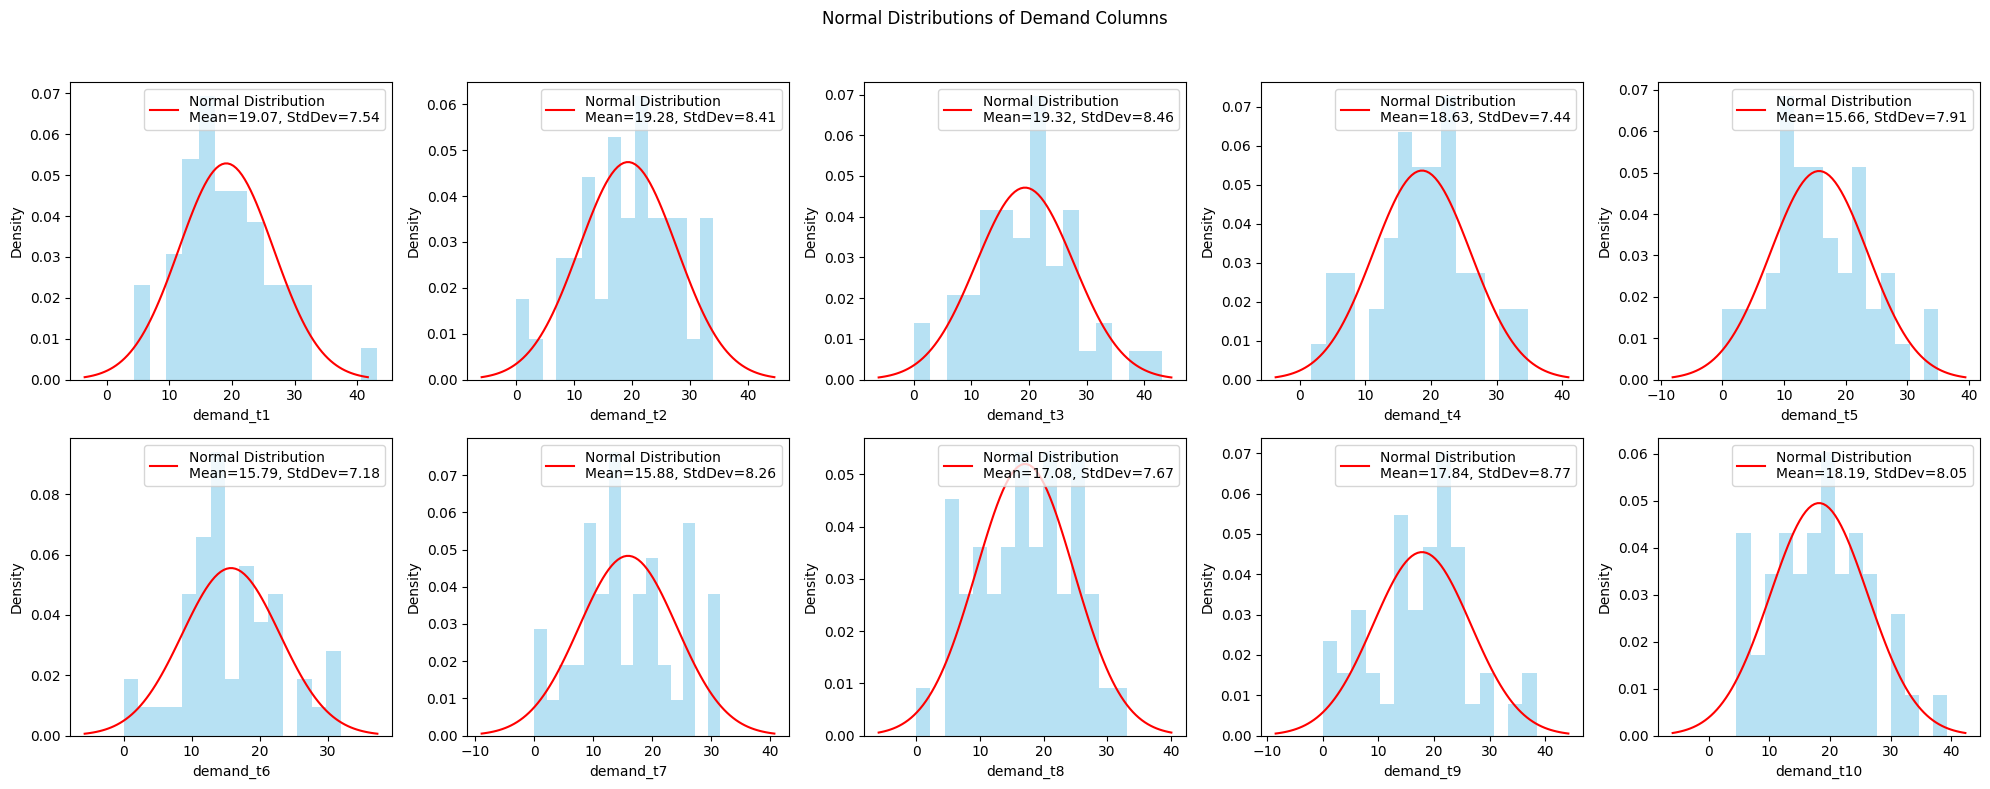

In [31]:
# 創建 2x5 的子圖網格
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Normal Distributions of Demand Columns")

for idx, column in enumerate(demand_df.columns):
    data = demand_df[column].dropna()  # 移除缺失值
    mean, std_dev = np.mean(data), np.std(data)

    # 產生 x 值範圍
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
    pdf = norm.pdf(x, mean, std_dev)

    # 確定當前的軸位置
    ax = axes[idx // 5, idx % 5]
    ax.hist(data, bins=15, density=True, alpha=0.6, color="skyblue")
    ax.plot(
        x,
        pdf,
        "r-",
        label=f"Normal Distribution\nMean={mean:.2f}, StdDev={std_dev:.2f}",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# 移除空白子圖（若有）
for idx in range(len(demand_df.columns), 10):
    fig.delaxes(axes[idx // 5, idx % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Validate the covariance


In [32]:
demand_df.cov()

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1   58.055067  16.516957  39.355888  20.181431 -14.207104  -9.105465   
demand_t2   16.516957  72.251520  49.812886  17.252285 -16.573086  -0.061113   
demand_t3   39.355888  49.812886  73.074020  11.268452 -18.215228 -14.787761   
demand_t4   20.181431  17.252285  11.268452  56.537498 -16.467516   4.116640   
demand_t5  -14.207104 -16.573086 -18.215228 -16.467516  63.901965  26.585338   
demand_t6   -9.105465  -0.061113 -14.787761   4.116640  26.585338  52.618213   
demand_t7   -9.071061 -17.112799 -37.081543  21.284437  24.482392  43.945692   
demand_t8    1.423677  22.117412  18.662389 -25.256099  27.663064  28.673755   
demand_t9  -30.919290  24.445612 -17.541770  27.272635   7.861891   9.766839   
demand_t10  14.589878  14.420120  10.396627  33.520425   0.149961  14.342436   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1   -9.071061   1.423677 -30.919290   14.589878  
demand_t2  -17.112799  22.117412  24.445612   14.420120  
demand_t3  -37.081543  18.662389 -17.541770   10.396627  
demand_t4   21.284437 -25.256099  27.272635   33.520425  
demand_t5   24.482392  27.663064   7.861891    0.149961  
demand_t6   43.945692  28.673755   9.766839   14.342436  
demand_t7   69.574386   0.108642  22.661637   32.329864  
demand_t8    0.108642  60.078301  -2.645484    7.706388  
demand_t9   22.661637  -2.645484  78.515727   30.062846  
demand_t10  32.329864   7.706388  30.062846   66.161375

In [33]:
empirical_covariance = demand_df.cov()
covariance_diff = np.abs(empirical_covariance - np.array(cov_matrices).mean(axis=0))
covariance_diff

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1    3.856243   4.270474   7.443223  11.282059   6.575780   0.364030   
demand_t2    4.270474   8.475860   9.404067   2.709558  14.539258   7.493939   
demand_t3    7.443223   9.404067  11.475049   3.468900   6.316527   0.037011   
demand_t4   11.282059   2.709558   3.468900   3.601700   6.505867   8.692145   
demand_t5    6.575780  14.539258   6.316527   6.505867  10.593354   5.001889   
demand_t6    0.364030   7.493939   0.037011   8.692145   5.001889  10.928606   
demand_t7    3.567994   5.006467   4.424026  12.159486   7.919025   4.309801   
demand_t8   16.298781  17.903909  18.059751   8.361117  11.999949   1.675077   
demand_t9    1.146175  17.160507   9.409282  21.908611  17.166349  32.352281   
demand_t10  15.748552  17.370802  17.972809  20.158461   6.106892   5.500818   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1    3.567994  16.298781   1.146175   15.748552  
demand_t2    5.006467  17.903909  17.160507   17.370802  
demand_t3    4.424026  18.059751   9.409282   17.972809  
demand_t4   12.159486   8.361117  21.908611   20.158461  
demand_t5    7.919025  11.999949  17.166349    6.106892  
demand_t6    4.309801   1.675077  32.352281    5.500818  
demand_t7   12.474036   2.041685  23.274028    4.710797  
demand_t8    2.041685   6.458939   9.682218    0.521725  
demand_t9   23.274028   9.682218   9.668649    7.917106  
demand_t10   4.710797   0.521725   7.917106    9.535499

### Validate the corr matrix of damand_df is close to original setting


In [34]:
correlation_matrix = demand_df.corr()
print("Correlation Matrix from demand_df:")
correlation_matrix

Correlation Matrix from demand_df:


demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1    1.000000   0.255027   0.604238   0.352260  -0.233254  -0.164746   
demand_t2    0.255027   1.000000   0.685546   0.269932  -0.243906  -0.000991   
demand_t3    0.604238   0.685546   1.000000   0.175313  -0.266561  -0.238480   
demand_t4    0.352260   0.269932   0.175313   1.000000  -0.273970   0.075476   
demand_t5   -0.233254  -0.243906  -0.266561  -0.273970   1.000000   0.458476   
demand_t6   -0.164746  -0.000991  -0.238480   0.075476   0.458476   1.000000   
demand_t7   -0.142729  -0.241364  -0.520058   0.339367   0.367174   0.726313   
demand_t8    0.024106   0.335701   0.281661  -0.433350   0.446462   0.509985   
demand_t9   -0.457964   0.324563  -0.231587   0.409337   0.110992   0.151952   
demand_t10   0.235412   0.208566   0.149523   0.548074   0.002306   0.243082   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1   -0.142729   0.024106  -0.457964    0.235412  
demand_t2   -0.241364   0.335701   0.324563    0.208566  
demand_t3   -0.520058   0.281661  -0.231587    0.149523  
demand_t4    0.339367  -0.433350   0.409337    0.548074  
demand_t5    0.367174   0.446462   0.110992    0.002306  
demand_t6    0.726313   0.509985   0.151952    0.243082  
demand_t7    1.000000   0.001680   0.306611    0.476515  
demand_t8    0.001680   1.000000  -0.038518    0.122233  
demand_t9    0.306611  -0.038518   1.000000    0.417109  
demand_t10   0.476515   0.122233   0.417109    1.000000

In [35]:
print(f"Original corr_matrix shape: {corr_matrix.shape}")
corr_matrix_df = pd.DataFrame(corr_matrix)
corr_matrix_df

Original corr_matrix shape: (10, 10)


0         1         2         3         4         5         6  \
0  1.000000  0.354243  0.555784  0.587411 -0.387774 -0.161484 -0.099073   
1  0.354243  1.000000  0.645671  0.344249 -0.533962 -0.118714 -0.366601   
2  0.555784  0.645671  1.000000  0.259728 -0.428492 -0.236520 -0.551543   
3  0.587411  0.344249  0.259728  1.000000 -0.433716 -0.078962  0.166233   
4 -0.387774 -0.533962 -0.428492 -0.433716  1.000000  0.371399  0.300310   
5 -0.161484 -0.118714 -0.236520 -0.078962  0.371399  1.000000  0.658292   
6 -0.099073 -0.366601 -0.551543  0.166233  0.300310  0.658292  1.000000   
7 -0.275944  0.072230  0.010563 -0.631022  0.294020  0.520508  0.038941   
8 -0.488891  0.109958 -0.414246  0.089139 -0.153719 -0.341738 -0.009772   
9 -0.020925 -0.049126 -0.128709  0.244177 -0.108549  0.147419  0.485870   

          7         8         9  
0 -0.275944 -0.488891 -0.020925  
1  0.072230  0.109958 -0.049126  
2  0.010563 -0.414246 -0.128709  
3 -0.631022  0.089139  0.244177  
4  0.294020 -0.153719 -0.108549  
5  0.520508 -0.341738  0.147419  
6  0.038941 -0.009772  0.485870  
7  1.000000 -0.203659  0.130487  
8 -0.203659  1.000000  0.355112  
9  0.130487  0.355112  1.000000

### Split test and train demand_df


In [36]:
def demand_data_split_data_k_fold(data, train_size, k_fold=2):
    folds = []
    for i in range(k_fold):
        train_data, test_data = train_test_split(
            data, train_size=train_size, random_state=i
        )
        test_data.reset_index(drop=True, inplace=True)
        train_data.reset_index(drop=True, inplace=True)
        folds.append((train_data, test_data))
    return folds

In [37]:
demand_folds = demand_data_split_data_k_fold(demand_df, train_size, k_fold=k_fold)

for i, (train, test) in enumerate(demand_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print(f"train.head(): \n{train.head()}")
    print()

Fold 1:
Train size: (25, 10), Test size: (25, 10)
train.head(): 
   demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0  31.529654  21.842556  26.513966  34.780617  27.517420  20.997682   
1  20.308755  10.676541  15.118359  25.011653  10.010574  13.710560   
2  31.609267  30.490379  32.795646  17.990470   7.057457  21.444716   
3  24.846200  20.942665  26.216944  15.508140  15.699246  14.445105   
4  12.972915  10.005350  13.560519  17.448135  14.340419  18.244790   

   demand_t7  demand_t8  demand_t9  demand_t10  
0  25.959260  17.473981  23.342455   30.572328  
1  20.956367   5.533017  14.938817   26.443935  
2  17.229521  33.188518  14.814432   26.864757  
3  12.788985  21.244154  13.855049   15.550806  
4  18.056369  19.076180  22.039924   22.281376  

Fold 2:
Train size: (25, 10), Test size: (25, 10)
train.head(): 
   demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0  12.949772  12.818076  16.725841  18.925849  13.747652   0.000000   
1   4.

In [38]:
# # Only for testing
# demand_df_train = demand_df_test = demand_df

### Define the Q star(Q optimal)


In [39]:
def calculate_Q_star(demand_df, service_level=0.95):

    # 計算每一行的總和
    demand_sum = demand_df.sum(axis=1)

    # 計算總和的均值和標準差
    mean_sum = demand_sum.mean()
    std_sum = demand_sum.std()

    # 計算總和的95%百分位數值
    Q_star = norm.ppf(service_level, loc=mean_sum, scale=std_sum)

    # 打印結果
    print(f"mean of sum: {mean_sum}")
    print(f"std of sum: {std_sum}")
    print(f"{service_level*100} percentile of sum: {Q_star}")

    return Q_star

In [40]:
demand_df_train_1 = demand_folds[0][0]
Q_star = calculate_Q_star(demand_df_train_1, service_level=0.95)
print(f"Q_star: {Q_star}\n")

demand_df_train_2 = demand_folds[1][0]
Q_star = calculate_Q_star(demand_df_train_2, service_level=0.95)
print(f"Q_star: {Q_star}\n")

mean of sum: 183.43244117652688
std of sum: 32.60474204393857
95.0 percentile of sum: 237.0624693833164
Q_star: 237.0624693833164

mean of sum: 169.092065828729
std of sum: 43.05307577208679
95.0 percentile of sum: 239.90807366386252
Q_star: 239.90807366386252



## Data3: Qk hat df


### Functions


In [41]:
# 計算條件分佈的函數
def calculate_conditional_distribution(mu, covariance_matrix, x_observed, k):
    mu_1 = mu[:k]
    mu_2 = mu[k:]
    Sigma_11 = covariance_matrix[:k, :k]
    Sigma_22 = covariance_matrix[k:, k:]
    Sigma_12 = covariance_matrix[k:, :k]
    Sigma_21 = covariance_matrix[:k, k:]

    # Compute conditional mean and covariance
    Sigma_11_inv = np.linalg.pinv(Sigma_11)
    mu_cond = mu_2 + np.dot(Sigma_12, np.dot(Sigma_11_inv, (x_observed - mu_1)))
    sigma_cond = Sigma_22 - np.dot(Sigma_12, np.dot(Sigma_11_inv, Sigma_21))

    return mu_cond, sigma_cond

In [42]:
def cal_Var_Y(sigma_cond):

    # Extract the variances (diagonal elements)
    variances = np.diag(sigma_cond)

    # Calculate the sum of covariances (off-diagonal elements)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)

    # Total variance for the sum of mu_cond
    total_variance = np.sum(variances) + covariances_sum

    return total_variance

In [43]:
def cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed):
    # predict_quantity = mu_cond + norm.ppf(service_level) * np.sqrt(np.diag(sigma_cond))
    # Qk_hat = x_observed.sum() + predict_quantity.sum()

    mean_Y = np.sum(mu_cond)
    var_Y = cal_Var_Y(sigma_cond)

    sd_Y = np.sqrt(var_Y)
    if sd_Y < 0 or np.isnan(sd_Y):  # scale must be positive
        sd_Y = 1e-6

    percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=sd_Y)

    # print(f"        mean_Y: {mean_Y}")
    # print(f"        sd_Y: {sd_Y}")
    # print(f"    percentile_95_Y: {percentile_95_Y}")

    Qk_hat = x_observed.sum() + percentile_95_Y
    return Qk_hat

In [44]:
def cal_mu_and_cov_matrix(demand_df_train):

    mu_matrix = demand_df_train.mean().values
    covariance_matrix = demand_df_train.cov().values

    # print(f"mu_matrix: {mu_matrix}")
    # print(f"covariance_matrix: \n{covariance_matrix}\n")

    return mu_matrix, covariance_matrix

In [45]:
def make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix):
    results_df = pd.DataFrame(index=demand_df.index)

    for index, row_data in demand_df.iterrows():
        for k in range(2, T):
            # print(f"Now processing index: {index}, t={k}")

            x_observed = row_data[
                : k - 1
            ].values  # 取出前 k 個觀測值 -> Qk_hat_2(t=2): 則 observerd: T=1

            mu_cond, sigma_cond = calculate_conditional_distribution(
                mu_matrix, covariance_matrix, x_observed, len(x_observed)
            )

            Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)

            results_df.loc[index, f"Qk_hat_k{k}"] = Qk_hat

            # print(f"    x_observed: {x_observed}")
            # print(f"    mu_cond: {mu_cond}")
            # print(f"    sigma_cond: \n{sigma_cond}")
            # print(f"    Qk_hat: {Qk_hat}")
            # print("\n")

    return results_df

公式連結：https://jujueffectivelife.notion.site/Qk-eab4d89ec36345efbf3a0d4a4f488474?pvs=4


### Validate the consistency of condMVN in Python and R


#### Given mu and sigma


In [46]:
from scipy.stats import multivariate_normal

# Define the mean vector and the covariance matrix
mu = np.array([10, 20, 30, 40])
covariance_matrix = np.array([[5, 1, 0, 2], [1, 8, 1, 0], [0, 1, 10, 1], [2, 0, 1, 7]])

# Mean and covariance partitioning
mu_1 = mu[:2]
mu_2 = mu[2:]
Sigma_11 = covariance_matrix[:2, :2]
Sigma_22 = covariance_matrix[2:, 2:]
Sigma_12 = covariance_matrix[2:, :2]
Sigma_21 = covariance_matrix[:2, 2:]

print(f"Sigma_11: \n{Sigma_11}\n")
print(f"Sigma_22: \n{Sigma_22}\n")
print(f"Sigma_12: \n{Sigma_12}\n")
print(f"Sigma_21: \n{Sigma_21}\n")

Sigma_11: 
[[5 1]
 [1 8]]

Sigma_22: 
[[10  1]
 [ 1  7]]

Sigma_12: 
[[0 1]
 [2 0]]

Sigma_21: 
[[0 2]
 [1 0]]



In [47]:
# Observed values of X1 and X2
x_observed = np.array([6, 30])

mu_cond, sigma_cond = calculate_conditional_distribution(
    mu, covariance_matrix, x_observed, len(x_observed)
)
print(f"mu_cond: {mu_cond}")
print(f"sigma_cond: \n{sigma_cond}")

mu_cond: [31.38461538 37.84615385]
sigma_cond: 
[[9.87179487 1.05128205]
 [1.05128205 6.17948718]]


In [48]:
# Define the conditional distribution
conditional_dist = multivariate_normal(mean=mu_cond, cov=sigma_cond)

# Values at which to evaluate the PDF and CDF
x3, x4 = 30, 40  # These can be any values of interest

# Calculate the PDF
pdf_value = conditional_dist.pdf([x3, x4])
print(f"Conditional density at X3 = {x3}, X4 = {x4}: {pdf_value}")

# Calculate the CDF
cdf_value = conditional_dist.cdf([x3, x4])
print(f"Conditional cumulative probability up to X3 = {x3}, X4 = {x4}: {cdf_value}")

# Qk hat
Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)
print(f"Qk_hat of x_observed: {Qk_hat}")

Conditional density at X3 = 30, X4 = 40: 0.012061749355189695
Conditional cumulative probability up to X3 = 30, X4 = 40: 0.2790601403798458
Qk_hat of x_observed: 112.23905144741786


```
R 中運行的結果
```

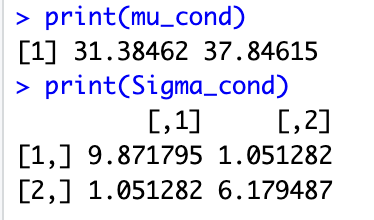
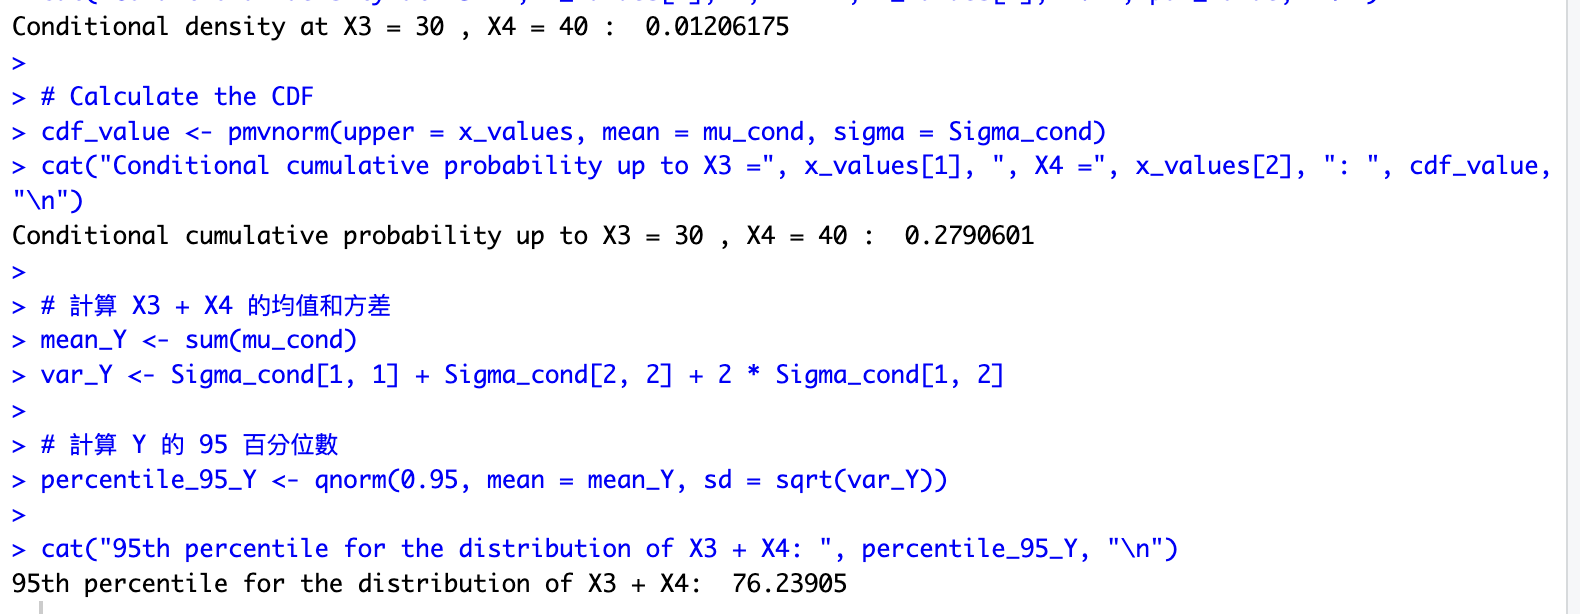


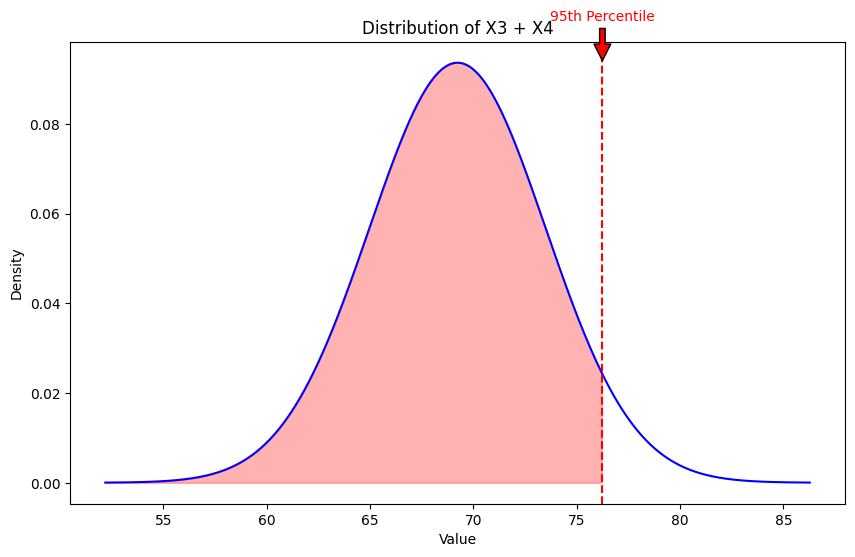

In [49]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean_Y = np.sum(mu_cond)
var_Y = cal_Var_Y(sigma_cond)

percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=np.sqrt(var_Y))

# Generate normal distribution data
x_values = np.linspace(mean_Y - 4 * np.sqrt(var_Y), mean_Y + 4 * np.sqrt(var_Y), 1000)
y_values = norm.pdf(x_values, loc=mean_Y, scale=np.sqrt(var_Y))

# Create dataframe
data = pd.DataFrame({"x": x_values, "y": y_values})

# Plot distribution
plt.figure(figsize=(10, 6))
plt.plot(data["x"], data["y"], color="blue")
plt.axvline(x=percentile_95_Y, color="red", linestyle="dashed")
plt.fill_between(
    data["x"], data["y"], where=(data["x"] <= percentile_95_Y), color="red", alpha=0.3
)
plt.title("Distribution of X3 + X4")
plt.xlabel("Value")
plt.ylabel("Density")
plt.annotate(
    "95th Percentile",
    xy=(percentile_95_Y, max(y_values)),
    xytext=(percentile_95_Y, max(y_values) * 1.1),
    arrowprops=dict(facecolor="red", shrink=0.05),
    color="red",
    ha="center",
)
plt.show()

```
以下為 R 程式結果
```


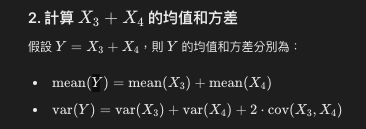


P(X3,X4∣X1=10,X2=20) 的 R 計算如下

```
install.packages("condMVNorm")
install.packages("mvtnorm")
library(condMVNorm)
library(mvtnorm)
library(ggplot2)

# Define the mean vector and covariance matrix
mu <- c(10, 20, 30, 40)
sigma <- matrix(c(
    5, 1, 0, 2,
    1, 8, 1, 0,
    0, 1, 10, 1,
    2, 0, 1, 7
), nrow = 4, byrow = TRUE)

# Observed values of X1 and X2
x_observed <- c(6, 30)

# Compute the conditional mean and covariance using condMVNorm
conditional_results <- condMVN(mean = mu, sigma = sigma, dependent.ind = c(3, 4), given.ind = c(1, 2), X.given = x_observed)

# Print the conditional mean and covariance
print(conditional_results$condMean)
print(conditional_results$condVar)

# Extract the conditional mean and covariance
mu_cond <- conditional_results$condMean
Sigma_cond <- conditional_results$condVar

# Print the conditional mean and covariance
print(mu_cond)
print(Sigma_cond)

# Values at which to evaluate the PDF and CDF
x_values <- c(30, 40)

# Calculate the PDF
pdf_value <- dmvnorm(x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional density at X3 =", x_values[1], ", X4 =", x_values[2], ": ", pdf_value, "\n")

# Calculate the CDF
cdf_value <- pmvnorm(upper = x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional cumulative probability up to X3 =", x_values[1], ", X4 =", x_values[2], ": ", cdf_value, "\n")

```


#### Conditional mean and variance


In [50]:
def cal_Var_Y(sigma_cond):
    variances = np.diag(sigma_cond)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)
    total_variance = np.sum(variances) + covariances_sum

    return total_variance


def simulate_Y(mu_cond, sigma_cond, num_samples=10000):
    samples = np.random.multivariate_normal(mu_cond, sigma_cond, num_samples)

    Y = samples[:, 0] + samples[:, 1]

    mean_Y = np.mean(Y)
    var_Y = np.var(Y)

    return mean_Y, var_Y


mu_cond = [2, 3]
sigma_cond = [[1, 0.5], [0.5, 1]]

mean_Y_formula = np.sum(mu_cond)
var_Y_formula = cal_Var_Y(sigma_cond)

mean_Y_simulated, var_Y_simulated = simulate_Y(mu_cond, sigma_cond)

print(f"公式計算的Y的均值: {mean_Y_formula}")
print(f"公式計算的Y的方差: {var_Y_formula}")
print(f"模擬計算的Y的均值: {mean_Y_simulated}")
print(f"模擬計算的Y的方差: {var_Y_simulated}")

公式計算的Y的均值: 5
公式計算的Y的方差: 3.0
模擬計算的Y的均值: 5.014943323554928
模擬計算的Y的方差: 2.961260737816822


### Calculate Qk hat for 2~T-1 of demand_df_train


In [51]:
demand_df_train = demand_folds[0][0]

In [52]:
_, _ = cal_mu_and_cov_matrix(demand_df_train)

In [53]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df)
Qk_hat_df = make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix)

In [54]:
Qk_hat_df

Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0   243.294731  185.810902  189.977839  183.000840  211.939824  200.550838   
1   251.883097  232.902682  236.824266  224.146323  225.749534  234.681710   
2   272.362590  281.621147  276.147640  279.638397  278.454030  259.909327   
3   225.470297  237.297032  240.020039  211.701718  191.495280  183.973488   
4   227.089135  206.883658  199.530933  204.050636  181.094147  142.951794   
5   234.735081  244.041217  238.729120  227.910903  202.945349  197.526209   
6   222.801553  238.404821  225.105668  225.473990  204.066665  191.945955   
7   231.844879  227.174088  223.348790  227.996650  237.088843  250.092219   
8   254.993969  263.773550  261.586065  246.481444  216.775705  230.572021   
9   240.927770  217.971607  212.346339  199.748504  179.006650  173.720052   
10  214.229108  176.183129  178.101367  171.365768  152.412306  148.036181   
11  225.998036  176.228628  181.322283  162.938842  165.470557  154.631757   
12  231.328390  209.584688  211.137856  214.958599  214.376031  196.798298   
13  244.879961  235.786882  230.251404  218.830602  205.895515  198.943765   
14  244.156701  207.284706  195.303712  191.678384  139.935108  126.647130   
15  228.072827  229.424684  227.959946  195.486048  175.339552  158.015871   
16  249.450402  234.495856  233.755225  201.354081  170.467093  168.217057   
17  228.433633  218.696633  220.705598  221.510328  214.922872  233.712408   
18  223.442953  250.349659  243.073953  245.669994  250.943218  228.233220   
19  244.621359  265.763250  268.511065  258.267797  245.939561  241.842289   
20  254.874909  243.433723  243.083348  260.107200  292.274230  280.171748   
21  232.952490  226.537351  228.521835  229.631364  242.571297  250.802825   
22  238.356575  243.408099  246.749564  249.570167  240.107962  220.023258   
23  250.189061  254.737997  265.553711  265.208126  246.615043  224.617967   
24  232.157689  218.987500  209.387886  219.972099  213.387512  193.480241   
25  227.123746  200.308706  195.178578  196.837473  172.870162  173.198056   
26  230.826409  236.489990  242.960058  240.026733  200.361622  177.557765   
27  236.995640  229.023659  245.231453  259.066534  243.674941  215.061726   
28  233.092077  202.290954  189.657888  185.123270  173.728419  164.157939   
29  242.156951  243.369529  250.811909  252.078528  207.714466  218.482280   
30  238.652266  235.292086  219.426579  215.287362  192.407855  192.682422   
31  233.391179  234.606331  227.994625  214.527505  214.896877  216.401815   
32  228.606549  245.705151  249.298270  243.836652  215.482630  198.472926   
33  214.600021  227.331409  227.981021  240.232954  225.343205  241.389758   
34  214.117430  196.497359  194.486410  180.837572  155.500541  142.303296   
35  231.617393  240.758297  238.885194  259.707496  238.804829  233.775922   
36  236.704256  211.533437  212.328980  214.120430  212.435023  219.107678   
37  235.691496  217.439183  225.624238  225.638735  201.253790  196.523533   
38  237.414335  260.828629  243.957261  240.517025  255.894335  234.776926   
39  230.649006  245.761183  249.945559  232.251993  240.896425  235.634123   
40  238.284500  234.328155  247.237713  249.670495  221.401899  208.393980   
41  253.089796  242.670539  236.153130  221.511400  191.359934  181.208530   
42  225.877478  194.320048  192.832669  176.127336  179.484235  167.612928   
43  238.094321  207.959877  206.520158  215.920990  186.550638  178.698109   
44  238.434114  221.998740  223.910575  223.941707  206.599648  182.921636   
45  246.524113  229.319060  224.369970  226.647919  187.755162  200.959302   
46  224.462139  204.634594  200.629135  208.329864  151.413252  144.412684   
47  245.310077  238.346814  240.900903  224.646392  167.137872  140.336699   
48  233.648337  222.324370  220.146300  194.700277  221.233908  196.958500   
49  248.356902  205.209990  195.242147  203.077313  172.787105  156.869350   

     Qk_hat_k8   Qk_hat_k9

### Plot the distribuction


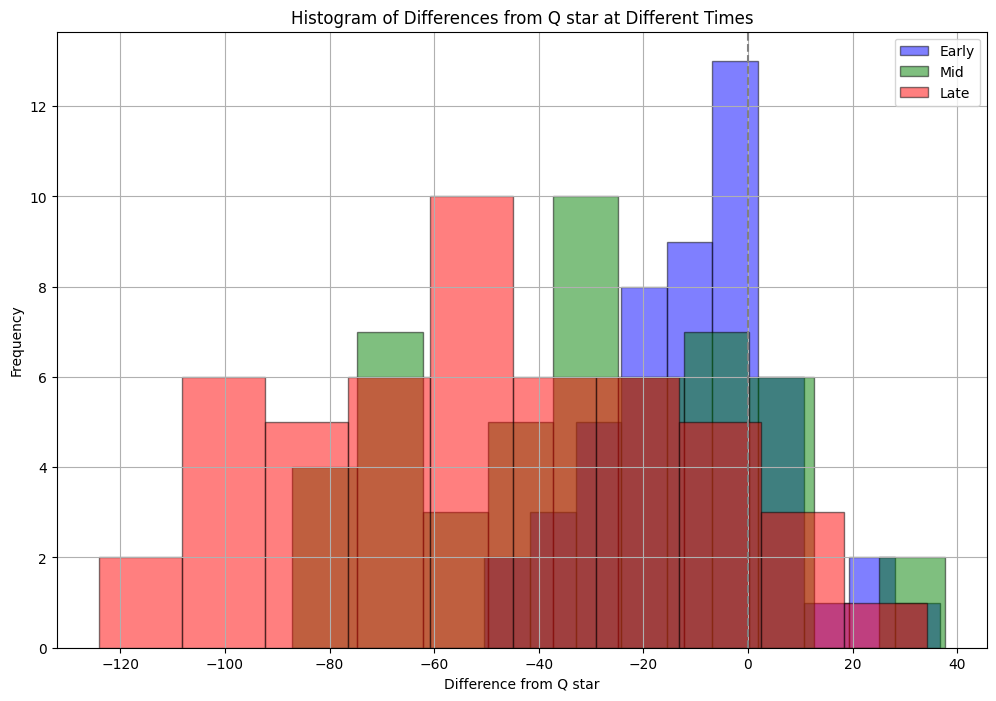

Q_star is: 239.90807366386252
Early bias: -10.20043711149664
Mid bias: -31.070600837259644
Late bias: -49.473421150264606


In [55]:
# 將 T 個時期分成三份
early_values = Qk_hat_df.iloc[:, : T // 3].mean(axis=1)
mid_values = Qk_hat_df.iloc[:, T // 3 : 2 * T // 3].mean(axis=1)
late_values = Qk_hat_df.iloc[:, 2 * T // 3 :].mean(axis=1)

# 計算與 Q_star 的差距
early_diff = early_values - Q_star
mid_diff = mid_values - Q_star
late_diff = late_values - Q_star

# 繪製直方圖
plt.figure(figsize=(12, 8))

# 早期
plt.hist(early_diff, bins=10, alpha=0.5, label="Early", color="blue", edgecolor="black")
# 中期
plt.hist(mid_diff, bins=10, alpha=0.5, label="Mid", color="green", edgecolor="black")
# 晚期
plt.hist(late_diff, bins=10, alpha=0.5, label="Late", color="red", edgecolor="black")

plt.axvline(0, color="grey", linestyle="--")

plt.xlabel("Difference from Q star")
plt.ylabel("Frequency")
plt.title("Histogram of Differences from Q star at Different Times")
plt.legend()
plt.grid(True)
plt.show()

# 計算偏差
early_bias = np.mean(early_diff)
mid_bias = np.mean(mid_diff)
late_bias = np.mean(late_diff)

print(f"Q_star is: {Q_star}")
print(f"Early bias: {early_bias}")
print(f"Mid bias: {mid_bias}")
print(f"Late bias: {late_bias}")

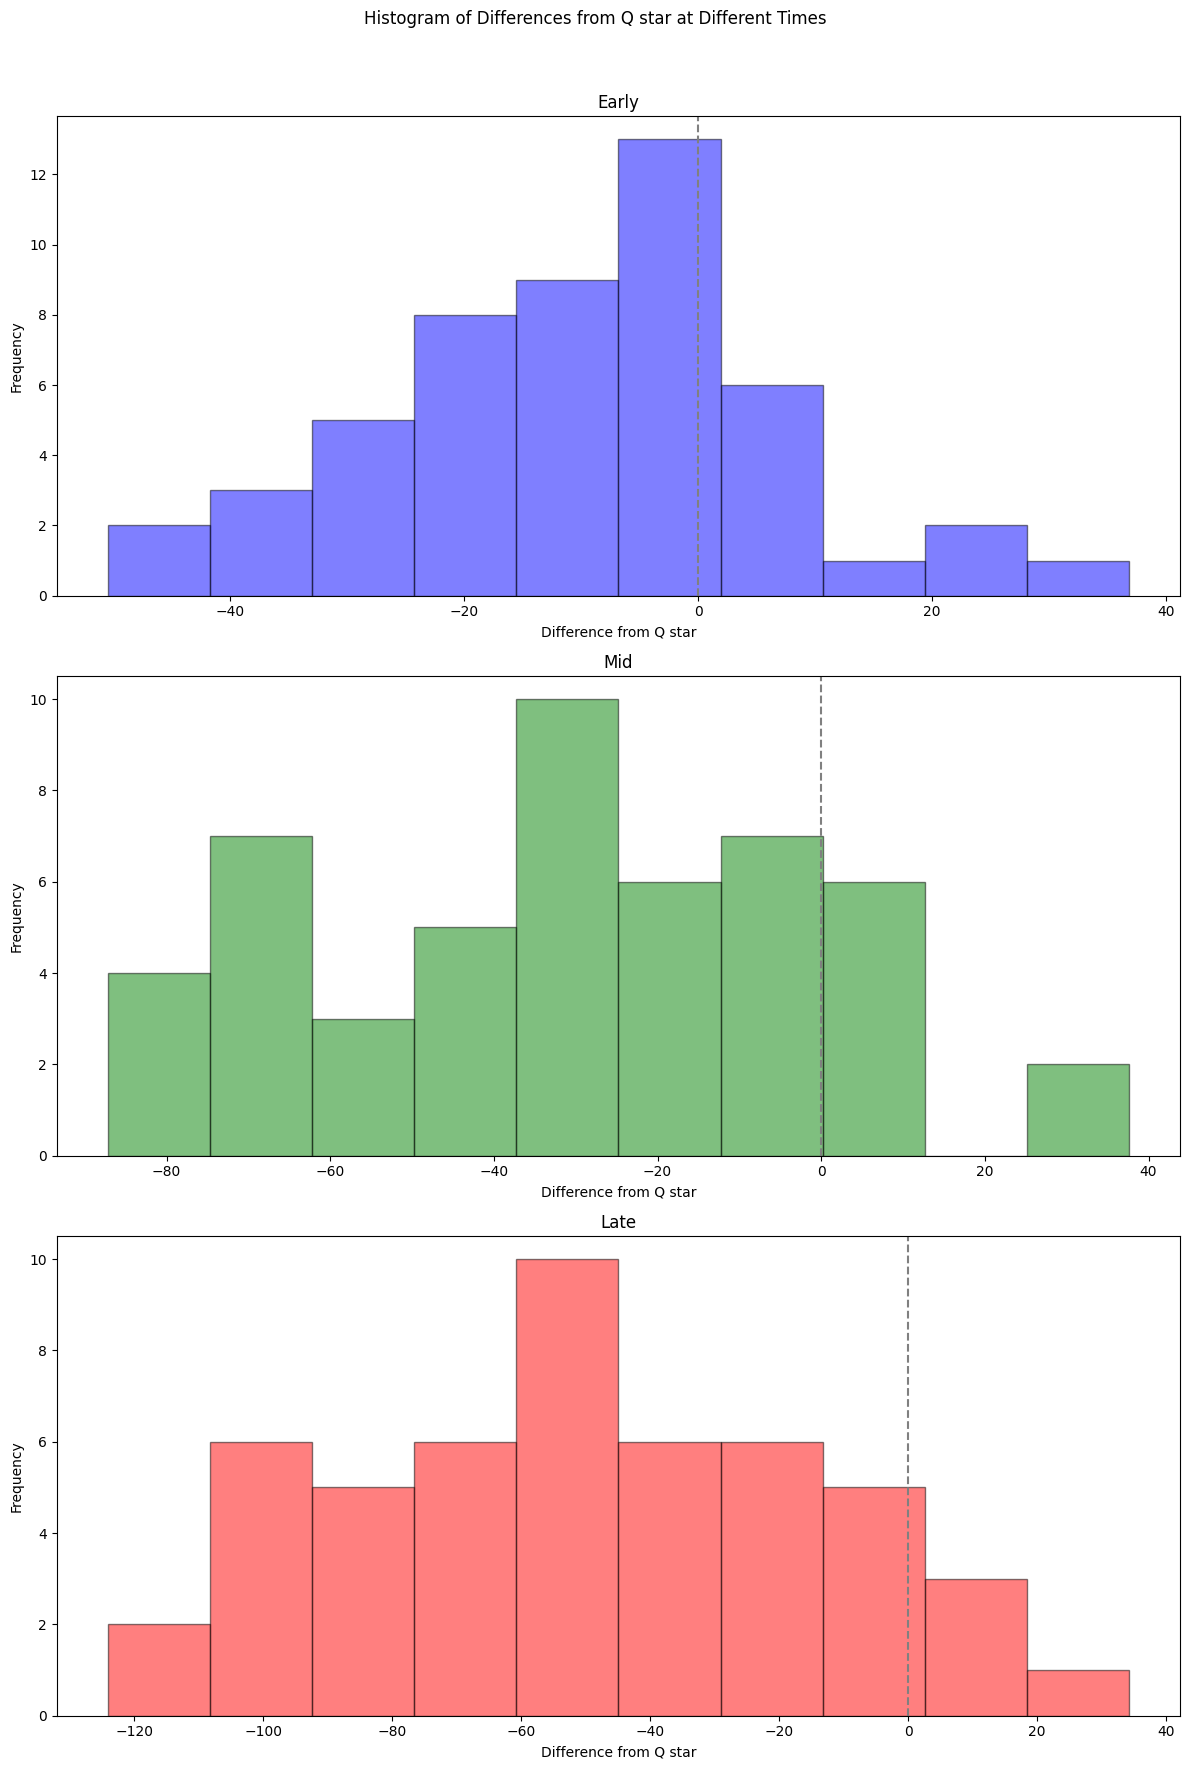

In [56]:
# 繪製直方圖
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 早期
axes[0].hist(early_diff, bins=10, alpha=0.5, color="blue", edgecolor="black")
axes[0].axvline(0, color="grey", linestyle="--")
axes[0].set_title("Early")
axes[0].set_xlabel("Difference from Q star")
axes[0].set_ylabel("Frequency")

# 中期
axes[1].hist(mid_diff, bins=10, alpha=0.5, color="green", edgecolor="black")
axes[1].axvline(0, color="grey", linestyle="--")
axes[1].set_title("Mid")
axes[1].set_xlabel("Difference from Q star")
axes[1].set_ylabel("Frequency")

# 晚期
axes[2].hist(late_diff, bins=10, alpha=0.5, color="red", edgecolor="black")
axes[2].axvline(0, color="grey", linestyle="--")
axes[2].set_title("Late")
axes[2].set_xlabel("Difference from Q star")
axes[2].set_ylabel("Frequency")

fig.suptitle("Histogram of Differences from Q star at Different Times")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Strategies utils


## S0 - One-time Procurement


In [57]:
def one_time_procurement(Q_star, demand_df, cost, price, salvage_value, holding_cost):

    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []
    all_holding_costs = []

    for i, row in demand_df.iterrows():
        inventory = Q_star
        losses = []
        lefts = []
        daily_operation_profits = []
        daily_profits = []
        total_sold = 0  # 追蹤總售出量
        total_lost = 0  # 追蹤總丟失量
        holding_costs = 0  # 追蹤總持有成本

        print("=" * 50)
        print(
            f"Processing row {i+1}/{len(demand_df)} with initial inventory Q_star={Q_star}"
        )
        print("=" * 50)

        for day, demand in enumerate(row):
            sales = min(inventory, demand)
            loss = max(demand - inventory, 0)
            left = max(inventory - sales, 0)
            total_sold += sales
            total_lost += loss

            inventory -= sales
            holding_costs += holding_cost * inventory

            print("-" * 50)
            print(f"Day {day+1}")
            print(f"Demand      : {demand}")
            print(f"Sales       : {sales}")
            print(f"Loss        : {loss}")
            print(f"Left        : {left}")
            print(f"Inventory   : {inventory}")
            print(f"Holding Cost: {holding_costs}")
            print("-" * 50)

            if day == len(row) - 1:
                left_penalty_cost = (cost - salvage_value) * left
                lefts.append(left)
                print(f"End of period: Left Penalty Cost = {left_penalty_cost}")
                print("-" * 50)
            else:
                left_penalty_cost = 0

        operation_profit = (price - cost) * total_sold
        profit = (
            operation_profit
            - left_penalty_cost
            - ((price - cost) * total_lost)
            - holding_costs
        )

        print("=" * 50)
        print(f"Row {i+1} Summary")
        print(f"Total Sold         : {total_sold}")
        print(f"Total Lost         : {total_lost}")
        print(f"Operation Profit   : {operation_profit}")
        print(f"Profit             : {profit}")
        print("=" * 50)

        all_losses.append(total_lost)
        all_lefts.append(sum(lefts))
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

    avg_losses = np.mean(all_losses)
    avg_lefts = np.mean(all_lefts)
    avg_operation_profits = np.mean(all_operation_profits)
    avg_profits = np.mean(all_profits)

    print("=" * 50)
    print("Overall Summary")
    print(f"Average Losses           : {avg_losses}")
    print(f"Average Lefts            : {avg_lefts}")
    print(f"Average Operation Profits: {avg_operation_profits}")
    print(f"Average Profits          : {avg_profits}")
    print("=" * 50)

    stimulation_df = pd.DataFrame(
        {
            "losses": all_losses,
            "lefts": all_lefts,
            "operation_profits": all_operation_profits,
            "profits": all_profits,
        }
    )

    return avg_losses, avg_lefts, avg_profits, avg_operation_profits, stimulation_df

## S1 - Grid for Fixed F & Fixed Rk


In [58]:
def cal_fixed_F_fixed_R(
    Q_star, assigned_F, assigned_R, demand_df, cost, price, salvage_value, Qk_hat_df
):
    all_losses = []
    all_lefts = []
    all_left0s = []
    all_left1s = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = operation_profit - left_penalty_cost - lost_penalty_cost

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_left0s.append(left_0)
        all_left1s.append(left_1)

        print(f"這是第 {i+1} 筆模擬資料\n")
        print(f"F: {assigned_F}, R: {assigned_R+2}")
        print(f"Q_star 為 {Q_star}")
        print(f"期初庫存 Q0: {Q0}")
        print(f"重新估計量 Qk_hat: {Qk_hat}")
        print(f"訂貨量 Q1 為 {Q1}\n")

        print(
            f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}"
        )
        print(
            f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}\n"
        )
        print(
            f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，Profit 為 {profit}"
        )
        print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
    }

    return result_df, stimulation_result

In [59]:
def grid_fixed_F_fixed_R(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [60]:
def cal_fixed_F_fixed_R_with_holding_cost(
    Q_star,
    assigned_F,
    assigned_R,
    demand_df,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    holding_cost,
):
    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []
    all_holding_costs_0 = []
    all_holding_costs_1 = []
    all_left0s = []
    all_left1s = []
    all_lost0s = []
    all_lost1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算 holding_cost
        """
        今天 T = 10, 假設 R = 5 (此時 assigned_R=3), 此時:
        第一階段是 T=1~4 -> 高為 R-1 = (assigned_R+2) - 1
        第二階段是 T=5~10 -> 高為 T - R = T - (assigned_R+2)
        """

        first_holding_cost = (Q0 + left_0 + Q1) * ((assigned_R + 2) - 1) / 2
        # T = 1 ~ R+1, R+1 才是代表 R(T)
        second_holding_cost = (Q1 + left_0 + left_1) * (T - (assigned_R + 2)) / 2
        # T = R+1 ~ T
        holding_penalty = holding_cost * (first_holding_cost + second_holding_cost)

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = (
            operation_profit - left_penalty_cost - lost_penalty_cost - holding_penalty
        )

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_holding_costs_0.append(first_holding_cost)
        all_holding_costs_1.append(second_holding_cost)
        all_left0s.append(left_0)
        all_left1s.append(left_1)
        all_lost0s.append(lost_0)
        all_lost1s.append(lost_1)

        # print(f"這是第 {i+1} 筆模擬資料\n")
        # print(f"F: {assigned_F}, R: {assigned_R+2}")
        # print(f"Q_star 為 {Q_star}")
        # print(f"期初庫存 Q0: {Q0}")
        # print(f"重新估計量 Qk_hat: {Qk_hat}")
        # print(f"訂貨量 Q1 為 {Q1}\n")

        # print(
        #     f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}, first_holding_cost 為 {first_holding_cost}"
        # )
        # print(
        #     f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}, second_holding_cost 為 {second_holding_cost}\n"
        # )
        # print(
        #     f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，holding_penalty 為 {holding_penalty}，Profit 為 {profit}"
        # )
        # print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "hc0": all_holding_costs_0,
        "hc1": all_holding_costs_1,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    return result_df, stimulation_result

In [61]:
def grid_fixed_F_fixed_R_with_holding_cost(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    holding_cost,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
                holding_cost,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [62]:
def cal_flexible_F_fixed_R(
    assigned_R,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            ## 只會有一個 R 為 1
            model.addConstr(R_vars[i, assigned_R] == 1, name=f"Set_R_{i}_0_To_1")
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 引入二進制變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")

            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i] - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(
                Sold_0s[i] >= Q0_vars[i] - M * Sold_0_binary, name=f"Sold_0_lb2_{i}"
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for key, alpha in alphas.items()])

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Qk_hat.append(Q_hats[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [63]:
def grid_flexible_F_fixed_R(
    assigned_Ts,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
    holding_cost,
):
    results_dict = {
        "R(T)": [],
        "R": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is T={assigned_T} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )

        assigned_R = assigned_T - 2
        result = cal_flexible_F_fixed_R(
            assigned_R=assigned_R,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
            holding_cost=holding_cost,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:

            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                alpha_values,
                F_vars,
                Q0_vars,
                Q1_vars,
                holding_costs_0s,
                holding_costs_1s,
                all_left0s,
                all_left1s,
                all_lost0s,
                all_lost1s,
                all_Qk_hat,
                all_sold0s,
                all_sold1s,
                all_demand_up,
                all_demand_down,
                all_Q1_plus_lefts,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(assigned_T)
            results_dict["R"].append([x - 2 for x in all_Rs])
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["alpha_values"].append(alpha_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)  # 紀錄該策略組合每一次模擬的 Q0
            results_dict["Q1_vars"].append(Q1_vars)  # 紀錄該策略組合每一次模擬的 Q1

            print(f"The average profits is {average_profits}")

            if max_profit is None or max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R(T)": all_Rs,
                    "R": [x - 2 for x in all_Rs],
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                    "Q0": Q0_vars,
                    "Q1": Q1_vars,
                    "hc0": holding_costs_0s,
                    "hc1": holding_costs_1s,
                    "demand_up": all_demand_up,
                    "demand_down": all_demand_down,
                    "Sold0s": all_sold0s,
                    "Sold1s": all_sold1s,
                    "Left0s": all_left0s,
                    "Left1s": all_left1s,
                    "lost0s": all_lost0s,
                    "lost1s": all_lost1s,
                    "Qk_hat": all_Qk_hat,
                    "Q1_plus_lefts": all_Q1_plus_lefts,
                }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## S3 - Grid for Fixed F & Flexible Rk(with full beta)

In [64]:
def cal_fixed_F_flexible_R(
    assigned_F,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            model.addConstr(F_vars[i] == assigned_F)
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                beta_values = np.array(
                    [[betas[i, j].X for j in range(features_num + 1)] for i in range(K)]
                )
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    beta_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [65]:
def grid_fixed_F_flexible_R(
    assigned_Fs,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
    holding_cost,
):
    results_dict = {
        "R(T)": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "average_profits": [],
        "beta_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
        "tau_values": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_F in assigned_Fs:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is F={assigned_F} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )
        result = cal_fixed_F_flexible_R(
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
            holding_cost=holding_cost,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:
            (
                all_Rs,
                all_losses,
                all_lefts,
                all_profits,
                all_operation_profits,
                all_Fs,
                all_Q0s,
                all_Q1s,
                beta_values,
                tau_values,
                all_holding_costs_0,
                all_holding_costs_1,
                all_left0s,
                all_left1s,
                all_lost0s,
                all_lost1s,
                all_Qk_hat,
                all_sold0s,
                all_sold1s,
                all_demand_up,
                all_demand_down,
                all_Q1_plus_lefts,
            ) = result

            # 计算平均值
            average_losses = sum(all_losses) / len(all_losses) if all_losses else 0
            average_lefts = sum(all_lefts) / len(all_lefts) if all_lefts else 0
            average_profits = sum(all_profits) / len(all_profits) if all_profits else 0
            average_operation_profits = (
                sum(all_operation_profits) / len(all_operation_profits)
                if all_operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(all_Rs)
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["beta_values"].append(beta_values)
            results_dict["tau_values"].append(tau_values)
            results_dict["F_vars"].append(all_Fs)
            results_dict["Q0_vars"].append(all_Q0s)
            results_dict["Q1_vars"].append(all_Q1s)

            if max_profit is None or max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R(T)": all_Rs,
                    "R": [x - 2 for x in all_Rs],
                    "F": all_Fs,
                    "profits": all_profits,
                    "losses": all_losses,
                    "lefts": all_lefts,
                    "operation_profits": all_operation_profits,
                    "Q0": all_Q0s,
                    "Q1": all_Q1s,
                    "hc0": all_holding_costs_0,
                    "hc1": all_holding_costs_1,
                    "Left0s": all_left0s,
                    "Left1s": all_left1s,
                    "lost0s": all_lost0s,
                    "lost1s": all_lost1s,
                    "Qk_hat": all_Qk_hat,
                    "Sold0s": all_sold0s,
                    "Sold1s": all_sold1s,
                    "demand_up": all_demand_up,
                    "demand_down": all_demand_down,
                    "Q1_plus_lefts": all_Q1_plus_lefts,
                }

            print(f"beta_values: \n{beta_values}")

    print(max_profit_stimulation_result)

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [66]:
def __fully_flexible_simple_beta_with_softmax_5(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(使用 softmax)
            exp_tau_vars = []
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k] == betas[k, 0], name=f"tau_computation_{i}_{k}"
                )  # 只使用截距項

                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [67]:
def fully_flexible_simple_beta_with_softmax_5(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    result = __fully_flexible_simple_beta_with_softmax_5(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        holding_cost=holding_cost,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            all_holding_costs_0,
            all_holding_costs_1,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            all_Qk_hat,
            all_sold0s,
            all_sold1s,
            all_demand_up,
            all_demand_down,
            all_Q1_plus_lefts,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=all_holding_costs_0,
            holding_costs_1s=all_holding_costs_1,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
            all_Qk_hat=all_Qk_hat,
            all_sold0s=all_sold0s,
            all_sold1s=all_sold1s,
            all_demand_up=all_demand_up,
            all_demand_down=all_demand_down,
            all_Q1_plus_lefts=all_Q1_plus_lefts,
        )

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [68]:
def __fully_flexible_simple_beta_with_softmax_6(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(softmax)
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0], name=f"tau_computation_{i}_{p}"
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [69]:
def fully_flexible_simple_beta_with_softmax_6(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    result = __fully_flexible_simple_beta_with_softmax_6(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        holding_cost=holding_cost,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            all_holding_costs_0,
            all_holding_costs_1,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            all_Qk_hat,
            all_sold0s,
            all_sold1s,
            all_demand_up,
            all_demand_down,
            all_Q1_plus_lefts,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=all_holding_costs_0,
            holding_costs_1s=all_holding_costs_1,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
            all_Qk_hat=all_Qk_hat,
            all_sold0s=all_sold0s,
            all_sold1s=all_sold1s,
            all_demand_up=all_demand_up,
            all_demand_down=all_demand_down,
            all_Q1_plus_lefts=all_Q1_plus_lefts,
        )

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [70]:
def __fully_flexible_simple_beta_with_softmax_7(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0] + f_vars[i],
                    name=f"tau_computation_{i}_{p}",
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [71]:
def fully_flexible_simple_beta_with_softmax_7(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):
    result = __fully_flexible_simple_beta_with_softmax_7(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        holding_cost=holding_cost,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            all_holding_costs_0,
            all_holding_costs_1,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            all_Qk_hat,
            all_sold0s,
            all_sold1s,
            all_demand_up,
            all_demand_down,
            all_Q1_plus_lefts,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=all_holding_costs_0,
            holding_costs_1s=all_holding_costs_1,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
            all_Qk_hat=all_Qk_hat,
            all_sold0s=all_sold0s,
            all_sold1s=all_sold1s,
            all_demand_up=all_demand_up,
            all_demand_down=all_demand_down,
            all_Q1_plus_lefts=all_Q1_plus_lefts,
        )

### S4 - Beta with softmax


In [72]:
def __fully_flexible_beta_with_softmax_4(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(features_num + 1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [73]:
def fully_flexible_beta_with_softmax_4(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    result = __fully_flexible_beta_with_softmax_4(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        holding_cost=holding_cost,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            all_holding_costs_0,
            all_holding_costs_1,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            all_Qk_hat,
            all_sold0s,
            all_sold1s,
            all_demand_up,
            all_demand_down,
            all_Q1_plus_lefts,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=all_holding_costs_0,
            holding_costs_1s=all_holding_costs_1,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
            all_Qk_hat=all_Qk_hat,
            all_sold0s=all_sold0s,
            all_sold1s=all_sold1s,
            all_demand_up=all_demand_up,
            all_demand_down=all_demand_down,
            all_Q1_plus_lefts=all_Q1_plus_lefts,
        )

# Testing Utils


## S1 - Grid for Fixed F & Fixed Rk


In [74]:
def cal_test_fixed_F_fixed_R(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [75]:
def cal_test_fixed_F_fixed_R_with_holding_cost(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
    holding_cost,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
        holding_cost,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [76]:
def cal_test_flexible_F_fixed_R(
    assigned_R,
    alphas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    R_vars = np.zeros((n, K), dtype=int)  # Use dtype=int to represent binary 0/1 values

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Ensure only one `R` is set to 1 in each row by setting `assigned_R` to 1 and all others to 0
        R_vars[i, assigned_R] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    print(f"assigned_R: {assigned_R}")
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "R(T)": assigned_R + 2,
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": assigned_R + 2,
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## S3 - Grid for Fixed F & Flexible Rk(原s6)


In [77]:
def cal_test_fixed_F_flexible_R(
    assigned_F,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        F_vars[i] = assigned_F
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        # Step 2: Calculate the exponentials of -tau_vars
        exp_tau_vars[i] = np.exp(-tau_vars[i])

        # Step 3: Softmax normalization
        sum_exp_tau = np.sum(exp_tau_vars[i])  # Sum of exponentials for normalization
        r_vars[i] = exp_tau_vars[i] / sum_exp_tau  # Normalize to get softmax

        max_r_index[i] = np.argmax(r_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "beta_balues": [betas],
            "F": [assigned_F],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [78]:
def cal_test_fully_flexible_simple_beta_with_softmax_5(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [79]:
def cal_test_fully_flexible_simple_beta_with_softmax_6(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0]  # Only intercept term is used
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate softmax-normalized r_vars
        sum_exp_tau_vars = (
            np.sum(exp_tau_vars[i]) + 1
        )  # Adding 1 as in the softmax denominator for the last element

        for p in range(K):
            if p == K - 1:
                # Set the last r_vars element to ensure the sum of all r_vars elements is 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 3: Find the maximum r_vars element and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [80]:
def cal_test_fully_flexible_simple_beta_with_softmax_7(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas and f_vars
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0] + f_vars[i]
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate the sum of exp_tau_vars for softmax normalization
        sum_exp_tau_vars = np.sum(exp_tau_vars[i]) + 1  # Adding 1 for the last r_var

        # Step 3: Calculate r_vars with softmax normalization
        for p in range(K):
            if p == K - 1:
                # Last r_var element ensures all r_vars sum to 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 4: Find the index of the maximum r_vars and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S4 - Beta with softmax


In [81]:
def cal_test_fully_flexible_beta_with_softmax_4(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        # Step 2: Calculate the exponentials of -tau_vars
        exp_tau_vars[i] = np.exp(-tau_vars[i])

        # Step 3: Softmax normalization
        sum_exp_tau = np.sum(exp_tau_vars[i])  # Sum of exponentials for normalization
        r_vars[i] = exp_tau_vars[i] / sum_exp_tau  # Normalize to get softmax

        max_r_index[i] = np.argmax(r_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

# Med Margin(P-C Med)


## Setting reasonable parameters


In [82]:
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))
CURRENT_TIMESTAMP

202411271920

In [83]:
status = "train"

service_lv = calculate_service_level(
    salvage_value=salvage_value, cost=cost, price=price
)
print(f"service_lv: {service_lv}")

service_lv: 0.5


In [84]:
training_df, testing_df = training_data_folds[0]
demand_df_train, demand_df_test = demand_folds[0]

In [85]:
training_df.shape

(25, 2)

In [86]:
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 183.43244117652688
std of sum: 32.60474204393857
50.0 percentile of sum: 183.43244117652688
Q_star: 183.43244117652688


In [87]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
Qk_hat_df_train = make_Qk_hat_df(
    demand_df_train, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_train

Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0   200.753423  203.160292  201.344498  216.265833  257.442927  252.036391   
1   183.253210  170.522712  170.143348  175.535133  154.249603  158.498898   
2   200.877588  216.738925  213.206900  208.613703  193.080613  215.319350   
3   190.329849  192.678489  188.434992  182.415390  187.825085  185.792101   
4   171.812169  159.510823  157.745144  157.126720  150.129931  158.483118   
5   179.749911  192.680807  189.123527  186.143527  183.207424  183.132881   
6   173.178230  172.436062  174.735122  177.530833  187.132369  212.465778   
7   183.451545  188.145231  196.385495  203.444704  179.171360  177.341907   
8   193.955895  174.241291  167.643022  168.974532  147.690746  143.951960   
9   197.633309  194.546494  195.989157  189.202671  201.812858  215.776804   
10  176.197126  167.946118  169.966717  172.946456  186.405603  174.481867   
11  180.747342  175.522569  181.320475  183.426668  166.287679  171.329938   
12  177.061989  174.641718  169.131512  176.678131  189.362225  176.312967   
13  167.304622  182.487228  174.778106  178.931908  186.478146  179.237557   
14  195.866625  208.139008  213.622433  220.439848  206.163359  194.073341   
15  181.803533  172.145916  173.227919  174.358597  185.509797  198.968734   
16  177.890875  180.087523  181.837170  185.631211  215.815415  227.973959   
17  190.060156  212.455802  212.840779  213.973309  218.066751  219.486675   
18  186.208169  178.705892  175.148999  165.754964  162.537269  162.818252   
19  175.488607  191.615571  194.473959  188.851735  221.135360  215.130818   
20  169.036421  160.946779  159.997456  164.847553  120.527128  127.158231   
21  170.087813  183.193315  185.702462  171.556936  176.821294  169.426683   
22  188.676637  158.616561  162.049520  152.408355  192.067029  182.039060   
23  190.778409  194.611797  195.516206  187.691075  139.868285  123.447951   
24  183.607575  180.034105  181.446111  183.061237  177.022774  161.125809   

     Qk_hat_k8   Qk_hat_k9  
0   254.567851  260.249363  
1   160.952560  156.678770  
2   219.316289  232.343412  
3   184.430853  181.368742  
4   155.016081  163.739262  
5   182.665041  182.150756  
6   210.028220  202.901433  
7   179.899277  170.355395  
8   143.847736  140.770421  
9   214.273315  213.130521  
10  180.677868  170.180651  
11  169.735308  179.001009  
12  171.574141  169.244374  
13  180.612545  184.390054  
14  189.439174  193.826884  
15  197.858804  192.605966  
16  230.457206  233.751144  
17  215.097983  199.528815  
18  164.209397  150.091287  
19  217.767643  221.583186  
20  128.113814  134.016148  
21  168.951080  172.415081  
22  181.078878  186.608504  
23  125.157410  124.211537  
24  160.082555  170.668314

## Training


### S0 - One-time procurement strategy


In [88]:
(
    baseline_avg_losses,
    baseline_avg_lefts,
    baseline_avg_profits,
    baseline_avg_operation_profits,
    baseline_stimulation_df,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_train,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    holding_cost=holding_cost,
)

print(f"baseline_profit: {baseline_avg_profits}")

Processing row 1/25 with initial inventory Q_star=183.43244117652688
--------------------------------------------------
Day 1
Demand      : 31.529653843656963
Sales       : 31.529653843656963
Loss        : 0
Left        : 151.9027873328699
Inventory   : 151.9027873328699
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 21.842555571701773
Sales       : 21.842555571701773
Loss        : 0
Left        : 130.06023176116813
Inventory   : 130.06023176116813
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 26.513966151562414
Sales       : 26.513966151562414
Loss        : 0
Left        : 103.54626560960571
Inventory   : 103.54626560960571
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 34.78061713831145
Sales       : 34.78061

In [89]:
baseline_stimulation_df

losses      lefts  operation_profits       profits
0   77.097477   0.000000       91716.220588  53167.481892
1    0.000000  20.723863       81354.288978  70992.357368
2   50.052722   0.000000       91716.220588  66689.859803
3    0.000000   2.335149       90548.646124  89381.071659
4    0.000000  15.406465       84012.988216  76309.755844
5    0.000000   6.416140       88508.150603  85300.080617
6   21.592888   0.000000       91716.220588  80919.776790
7    0.000000  16.184943       83623.749294  75531.277999
8    0.000000  38.291660       72570.390615  53424.560643
9   25.911231   0.000000       91716.220588  78760.605170
10   0.000000  12.181284       85625.578806  79534.937024
11   0.547537   0.000000       91716.220588  91442.452152
12   0.000000  15.207279       84112.581032  76508.941477
13   0.000000   0.033867       91699.286870  91682.353152
14   0.719559   0.000000       91716.220588  91356.440860
15  14.452283   0.000000       91716.220588  84490.079314
16  43.205210   0.000000       91716.220588  70113.615754
17  23.117880   0.000000       91716.220588  80157.280471
18   0.000000  43.071201       70180.620031  48645.019475
19  46.045824   0.000000       91716.220588  68693.308731
20   0.000000  58.184668       62623.886743  33531.552898
21   0.000000  12.408681       85511.880043  79307.539499
22   0.361395   0.000000       91716.220588  91535.522865
23   0.000000  53.875242       64778.599341  37840.978093
24   0.000000   8.783563       87324.438868  82932.657148

### S1 - Grid for Fixed F & Fixed Rk


In [90]:
results_df_1, stimulation_results_df_1 = None, None

results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    assigned_Fs=ASSIGNED_FS,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_train,
    demand_df_train=demand_df_train,
    Q_star=Q_star,
)
results_df_1





這是第 1 筆模擬資料

F: 0.1, R: 2
Q_star 為 183.43244117652688
期初庫存 Q0: 18.343244117652688
重新估計量 Qk_hat: 200.7534228179398
訂貨量 Q1 為 182.4101787002871

第一階段：期初庫存 Q0: 18.343244117652688，需求量為 31.529653843656963，Sold_0 為 18.343244117652688，Left_0 為 0.0，Lost_0 為 13.186409726004275
第二階段：期初庫存 Q1+left_0 為 182.4101787002871，需求量為 229.0002647261382，Sold_1 為 182.4101787002871，Left_1 為 0.0，Lost_1 為 46.59008602585109

統計結果：Sold 為 200.7534228179398, Lost 為 59.776495751855364 Left_Penalty_Cost 為 0.0，Lost_Penalty_Cost 為 29888.247875927682，Profit 為 70488.46353304222
----------------------------------------
這是第 2 筆模擬資料

F: 0.1, R: 2
Q_star 為 183.43244117652688
期初庫存 Q0: 18.343244117652688
重新估計量 Qk_hat: 183.2532096863202
訂貨量 Q1 為 164.9099655686675

第一階段：期初庫存 Q0: 18.343244117652688，需求量為 20.308755266778153，Sold_0 為 18.343244117652688，Left_0 為 0.0，Lost_0 為 1.965511149125465
第二階段：期初庫存 Q1+left_0 為 164.9099655686675，需求量為 142.39982268968726，Sold_1 為 142.39982268968726，Left_1 為 22.510142878980247，Lost_1 為 0

統計結果：Sold 

R(T)    F                                                 Q0  \
52     7  0.8  [146.7459529412215, 146.7459529412215, 146.745...   
53     7  0.9  [165.0891970588742, 165.0891970588742, 165.089...   
62     8  0.9  [165.0891970588742, 165.0891970588742, 165.089...   
51     7  0.7  [128.40270882356882, 128.40270882356882, 128.4...   
43     6  0.8  [146.7459529412215, 146.7459529412215, 146.745...   
..   ...  ...                                                ...   
55     8  0.2  [36.686488235305376, 36.686488235305376, 36.68...   
45     7  0.1  [18.343244117652688, 18.343244117652688, 18.34...   
64     9  0.2  [36.686488235305376, 36.686488235305376, 36.68...   
54     8  0.1  [18.343244117652688, 18.343244117652688, 18.34...   
63     9  0.1  [18.343244117652688, 18.343244117652688, 18.34...   

                                                   Q1  average_profits  \
52  [105.29043777142743, 11.752945484422156, 68.57...     85019.363116   
53  [86.94719365377475, 0, 50.23015271279243, 20.7...     84893.447895   
62  [89.47865435226547, 0, 54.227092382958375, 19....     84294.993906   
51  [123.63368188908012, 30.096189602074844, 86.91...     83516.640953   
43  [110.69697439416416, 7.503649878148451, 46.334...     82384.128642   
..                                                ...              ...   
55  [217.88136317583428, 124.26607142528152, 182.6...    -45881.843137   
45  [233.69314659499625, 140.15565430799097, 196.9...    -46448.672129   
64  [223.5628750624051, 119.99228155199228, 195.65...    -71636.746805   
54  [236.22460729348697, 142.6093155429342, 200.97...    -73396.709313   
63  [241.9061191800578, 138.33552566964497, 214.00...    -99151.612981   

    average_losses  average_lefts  average_operation_profits  
52        3.855509       5.682697               89788.466208  
53        2.946646       7.752253               90242.897421  
62        3.370887       8.100680               90030.777209  
51        5.383730       5.631699               89024.355612  
43        5.780108       7.103968               88826.166557  
..             ...            ...                        ...  
55       91.732042      91.732042               45850.199347  
45       92.109928      92.109928               45661.256349  
64      108.901978     108.901978               37265.231457  
54      110.075287     110.075287               36678.577288  
63      127.245222     127.245222               28093.609398  

[72 rows x 8 columns]

In [91]:
stimulation_results_df_1

R(T)    F        profits     losses      lefts     Left0s     Left1s  \
0      7  0.8  109857.810645  16.435942   7.942414   0.000000   7.942414   
1      7  0.8   77144.609447   4.209680   0.000000  51.909510   0.000000   
2      7  0.8   98576.768398  18.165813   0.000000   5.358018   0.000000   
3      7  0.8   88201.241919   0.000000   4.694808  29.087654   4.694808   
4      7  0.8   74470.130116   9.542858   0.000000  60.173825   0.000000   
5      7  0.8   85449.860796   0.000000   6.116580  34.953139   6.116580   
6      7  0.8   98792.439974   0.000000   7.440449  30.208273   7.440449   
7      7  0.8   78576.545290   0.000000  10.094408  40.563038  10.094408   
8      7  0.8   71767.804760   0.000000   1.605172  51.702323   1.605172   
9      7  0.8  101455.270100   0.000000   6.433132  13.355895   6.433132   
10     7  0.8   84010.223998   0.000000   3.230710  47.015660   3.230710   
11     7  0.8   79339.949076  12.650040   0.000000  48.262929   0.000000   
12     7  0.8   80068.678398   0.000000   8.087805  39.992860   8.087805   
13     7  0.8   87538.270161   4.161017   0.000000  40.999092   0.000000   
14     7  0.8   87115.330328   0.000000   9.921340  19.710265   9.921340   
15     7  0.8   98400.356485   0.000000   1.084011  32.603856   1.084011   
16     7  0.8  112650.671505   0.000000   1.336308  16.579400   1.336308   
17     7  0.8   96806.983750   0.000000  12.936354   7.575462  12.936354   
18     7  0.8   58952.113887   0.000000  22.457012  47.475899  22.457012   
19     7  0.8  100391.685991  14.347446   0.000000  22.544601   0.000000   
20     7  0.8   51874.797016   0.000000  21.498179  77.072715  21.498179   
21     7  0.8   83914.802689   1.597077   0.000000  52.621073   0.000000   
22     7  0.8   90142.141283   1.754777   0.000000  42.797717   0.000000   
23     7  0.8   56184.222211   0.000000  17.188754  63.264108  17.188754   
24     7  0.8   73801.369684  13.523069   0.000000  47.928137   0.000000   

    operation_profits          Q0          Q1  
0       122046.988429  146.745953  105.290438  
1        79249.449213  146.745953   11.752945  
2       107659.674886  146.745953   68.573397  
3        90548.646124  146.745953   39.046148  
4        79241.559166  146.745953   11.737165  
5        88508.150603  146.745953   36.386928  
6       102512.664387  146.745953   65.719825  
7        83623.749294  146.745953   30.595954  
8        72570.390615  146.745953    0.000000  
9       104671.836006  146.745953   69.030851  
10       85625.578806  146.745953   27.735914  
11       85664.969050  146.745953   24.583985  
12       84112.581032  146.745953   29.567014  
13       89618.778515  146.745953   32.491604  
14       92076.000317  146.745953   47.327388  
15       98942.361862  146.745953   52.222782  
16      113318.825422  146.745953   81.228006  
17      103275.160705  146.745953   72.740722  
18       70180.620031  146.745953   16.072299  
19      107565.409219  146.745953   68.384865  
20       62623.886743  146.745953    0.000000  
21       84713.341366  146.745953   22.680730  
22       91019.529797  146.745953   35.293107  
23       64778.599341  146.745953    0.000000  
24       80562.904276  146.745953   14.379856

In [92]:
# 比較結果
max_profit = results_df_1["average_profits"].max()

print("\n============ Below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"Maximum Profit: {max_profit}")


============ Below is the comparison results =================
Q_star: 183.43244117652688
Maximum Profit: 85019.36311632706


In [93]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_1.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
top_three_info

R(T)    F  average_profits
52     7  0.8     85019.363116
53     7  0.9     84893.447895
62     8  0.9     84294.993906

Plot saved as plots/grid_fixed_F_fixed_R_metrics_train_linear_constraint_med_with_holding_cost_0_50_202411271920.png


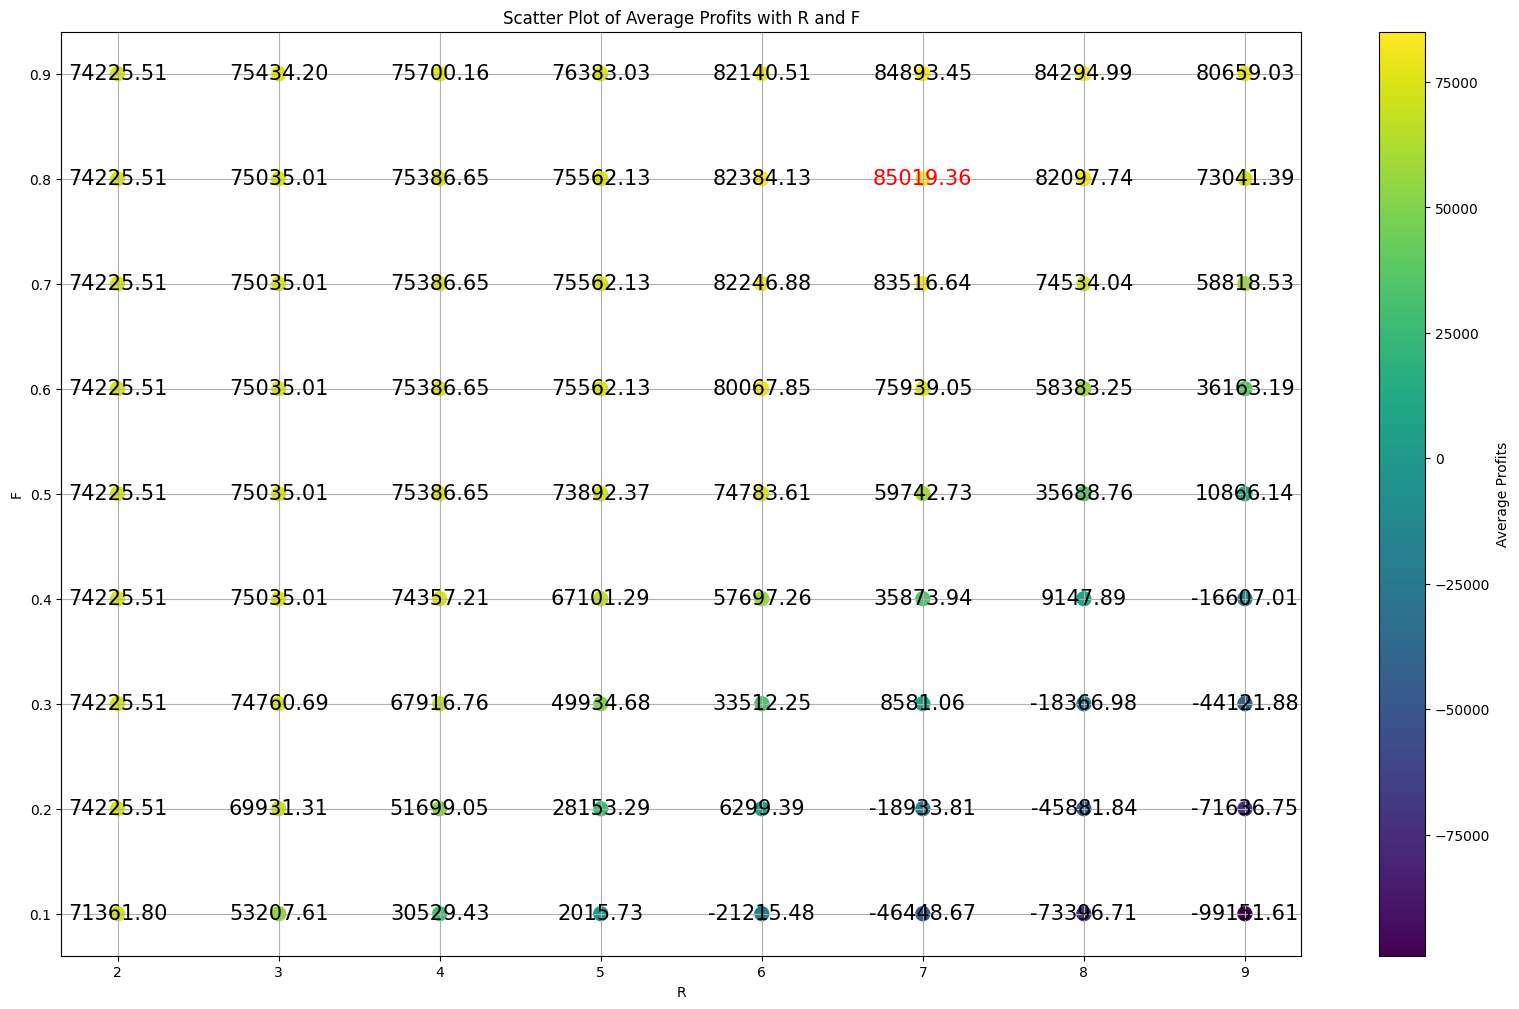

In [94]:
# 找到 'average_profits' 的最大值
max_profit = results_df_1["average_profits"].max()

# 画出散点图
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    results_df_1["R(T)"],
    results_df_1["F"],
    c=results_df_1["average_profits"],
    cmap="viridis",
    s=100,
)
plt.colorbar(label="Average Profits")
plt.xlabel("R")
plt.ylabel("F")
plt.title("Scatter Plot of Average Profits with R and F")
plt.grid(True)

# 在每个数据点上标注数值
for i in range(len(results_df_1)):
    avg_profit = results_df_1["average_profits"].iloc[i]
    # 判断是否等于 max_profit 的整數部分
    if int(avg_profit) == int(max_profit):
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="red",
        )
    else:
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="black",
        )

name = "grid_fixed_F_fixed_R_metrics"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

Plot saved as plots/grid_fixed_F_fixed_R_trend_train_linear_constraint_med_with_holding_cost_0_50_202411271920.png


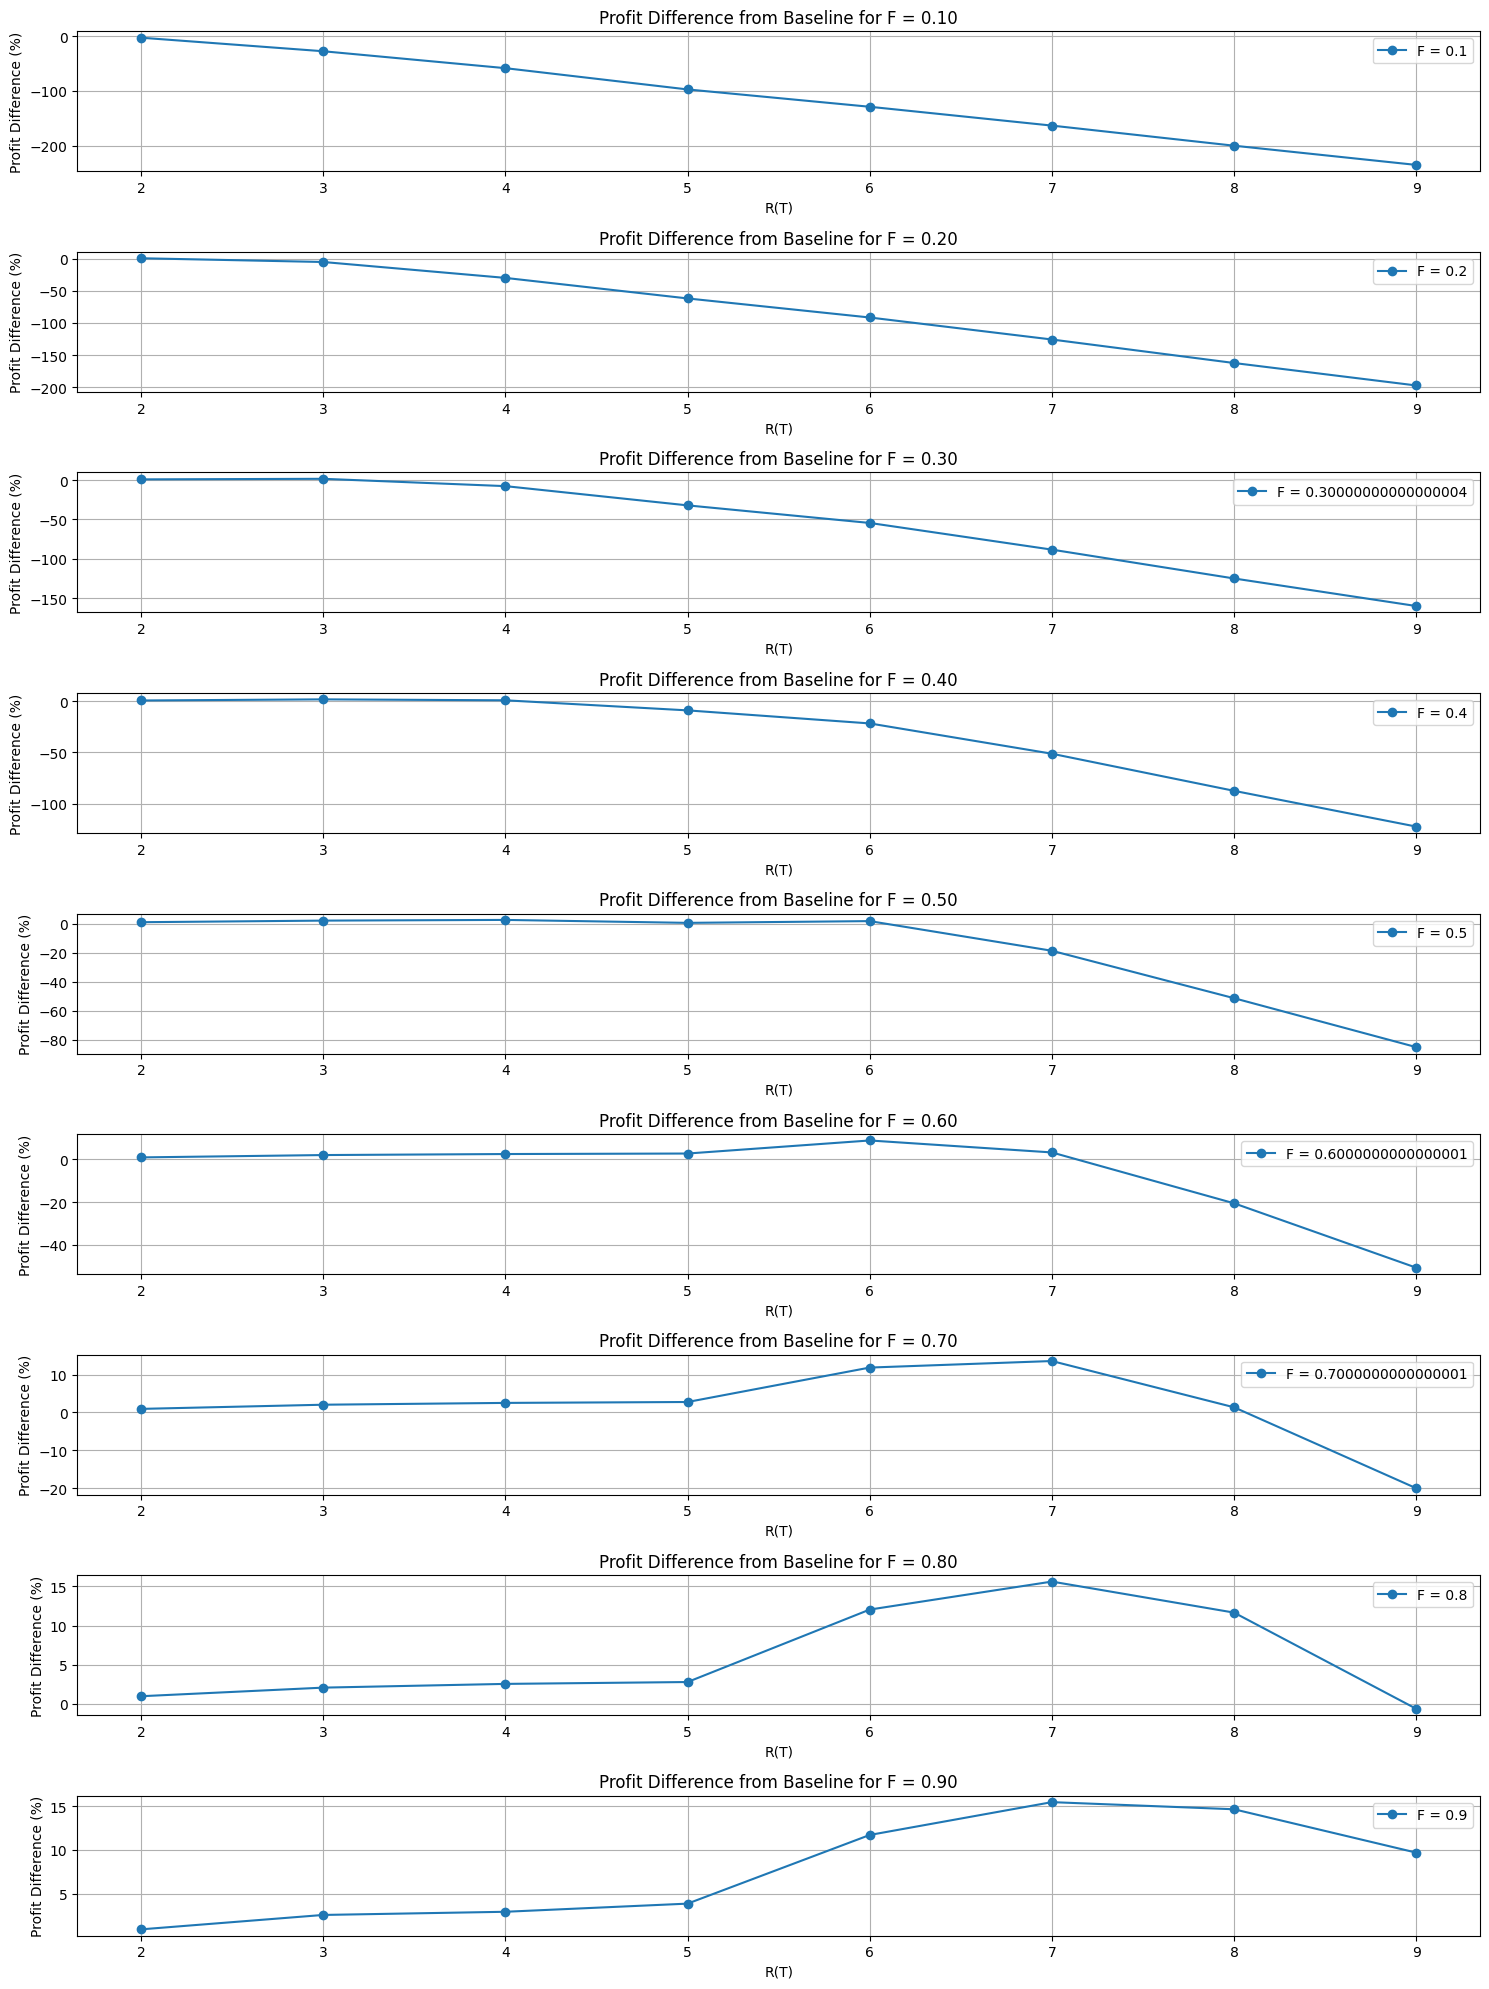

In [95]:
results_df_1["baseline_profit"] = baseline_avg_profits

# Calculate percentage difference from baseline profit
results_df_1["profit_diff_percent"] = (
    (results_df_1["average_profits"] - baseline_avg_profits) / baseline_avg_profits
) * 100

# Plot subplots for different values of F
plt.figure(figsize=(15, 20))

for idx, F in enumerate(ASSIGNED_FS):
    plt.subplot(len(ASSIGNED_FS), 1, idx + 1)
    subset = results_df_1[results_df_1["F"] == F].sort_values(by="R(T)").dropna()
    plt.plot(
        subset["R(T)"],
        subset["profit_diff_percent"],
        marker="o",
        linestyle="-",
        label=f"F = {F}",
    )
    plt.xlabel("R(T)")
    plt.ylabel("Profit Difference (%)")
    plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()

name = "grid_fixed_F_fixed_R_trend"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

### S8 - Grid for Fixed F & Fixed Rk


In [96]:
results_df_8, stimulation_results_df_8 = None, None

results_df_8, stimulation_results_df_8 = grid_fixed_F_fixed_R_with_holding_cost(
    assigned_Ts=ASSIGNED_TS,
    assigned_Fs=ASSIGNED_FS,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_train,
    demand_df_train=demand_df_train,
    Q_star=Q_star,
    holding_cost=holding_cost,
)
results_df_8





max_profit is changed from None to 71361.79564301783




max_profit is changed from 71361.79564301783 to 74225.50920570992








































max_profit is changed from 74225.50920570992 to 74760.69026165226




max_profit is changed from 74760.69026165226 to 75035.01087479998




















max_profit is changed from 75035.01087479998 to 75434.20290877989




































max_profit is changed from 75434.20290877989 to 75700.16153636746




































max_profit is changed from 75700.16153636746 to 76383.02933317235
























max_profit is changed from 76383.02933317235 to 80067.84501200357




max_profit is changed from 80067.84501200357 to 82246.87612663738




max_profit is changed from 82246.87612663738 to 82384.12864221285
































max_profit is changed from 82384.12864221285 to 83516.64095275858




max_profit is changed from 83516.64095275858 to 85019.36311632706











R(T)    F                                                 Q0  \
52     7  0.8  [146.7459529412215, 146.7459529412215, 146.745...   
53     7  0.9  [165.0891970588742, 165.0891970588742, 165.089...   
62     8  0.9  [165.0891970588742, 165.0891970588742, 165.089...   
51     7  0.7  [128.40270882356882, 128.40270882356882, 128.4...   
43     6  0.8  [146.7459529412215, 146.7459529412215, 146.745...   
..   ...  ...                                                ...   
55     8  0.2  [36.686488235305376, 36.686488235305376, 36.68...   
45     7  0.1  [18.343244117652688, 18.343244117652688, 18.34...   
64     9  0.2  [36.686488235305376, 36.686488235305376, 36.68...   
54     8  0.1  [18.343244117652688, 18.343244117652688, 18.34...   
63     9  0.1  [18.343244117652688, 18.343244117652688, 18.34...   

                                                   Q1  average_profits  \
52  [105.29043777142743, 11.752945484422156, 68.57...     85019.363116   
53  [86.94719365377475, 0, 50.23015271279243, 20.7...     84893.447895   
62  [89.47865435226547, 0, 54.227092382958375, 19....     84294.993906   
51  [123.63368188908012, 30.096189602074844, 86.91...     83516.640953   
43  [110.69697439416416, 7.503649878148451, 46.334...     82384.128642   
..                                                ...              ...   
55  [217.88136317583428, 124.26607142528152, 182.6...    -45881.843137   
45  [233.69314659499625, 140.15565430799097, 196.9...    -46448.672129   
64  [223.5628750624051, 119.99228155199228, 195.65...    -71636.746805   
54  [236.22460729348697, 142.6093155429342, 200.97...    -73396.709313   
63  [241.9061191800578, 138.33552566964497, 214.00...    -99151.612981   

    average_losses  average_lefts  average_operation_profits  
52        3.855509       5.682697               89788.466208  
53        2.946646       7.752253               90242.897421  
62        3.370887       8.100680               90030.777209  
51        5.383730       5.631699               89024.355612  
43        5.780108       7.103968               88826.166557  
..             ...            ...                        ...  
55       91.732042      91.732042               45850.199347  
45       92.109928      92.109928               45661.256349  
64      108.901978     108.901978               37265.231457  
54      110.075287     110.075287               36678.577288  
63      127.245222     127.245222               28093.609398  

[72 rows x 8 columns]

In [97]:
stimulation_results_df_8

R(T)    F        profits     losses      lefts  operation_profits  \
0      7  0.8  109857.810645  16.435942   7.942414      122046.988429   
1      7  0.8   77144.609447   4.209680   0.000000       79249.449213   
2      7  0.8   98576.768398  18.165813   0.000000      107659.674886   
3      7  0.8   88201.241919   0.000000   4.694808       90548.646124   
4      7  0.8   74470.130116   9.542858   0.000000       79241.559166   
5      7  0.8   85449.860796   0.000000   6.116580       88508.150603   
6      7  0.8   98792.439974   0.000000   7.440449      102512.664387   
7      7  0.8   78576.545290   0.000000  10.094408       83623.749294   
8      7  0.8   71767.804760   0.000000   1.605172       72570.390615   
9      7  0.8  101455.270100   0.000000   6.433132      104671.836006   
10     7  0.8   84010.223998   0.000000   3.230710       85625.578806   
11     7  0.8   79339.949076  12.650040   0.000000       85664.969050   
12     7  0.8   80068.678398   0.000000   8.087805       84112.581032   
13     7  0.8   87538.270161   4.161017   0.000000       89618.778515   
14     7  0.8   87115.330328   0.000000   9.921340       92076.000317   
15     7  0.8   98400.356485   0.000000   1.084011       98942.361862   
16     7  0.8  112650.671505   0.000000   1.336308      113318.825422   
17     7  0.8   96806.983750   0.000000  12.936354      103275.160705   
18     7  0.8   58952.113887   0.000000  22.457012       70180.620031   
19     7  0.8  100391.685991  14.347446   0.000000      107565.409219   
20     7  0.8   51874.797016   0.000000  21.498179       62623.886743   
21     7  0.8   83914.802689   1.597077   0.000000       84713.341366   
22     7  0.8   90142.141283   1.754777   0.000000       91019.529797   
23     7  0.8   56184.222211   0.000000  17.188754       64778.599341   
24     7  0.8   73801.369684  13.523069   0.000000       80562.904276   

            Q0          Q1         hc0         hc1     Left0s     Left1s  \
0   146.745953  105.290438  756.109172  169.849277   0.000000   7.942414   
1   146.745953   11.752945  631.225226   95.493683  51.909510   0.000000   
2   146.745953   68.573397  662.032104  110.897123   5.358018   0.000000   
3   146.745953   39.046148  644.639264  109.242915  29.087654   4.694808   
4   146.745953   11.737165  655.970830  107.866486  60.173825   0.000000   
5   146.745953   36.386928  654.258060  116.184970  34.953139   6.116580   
6   146.745953   65.719825  728.022151  155.052819  30.208273   7.440449   
7   146.745953   30.595954  653.714835  121.880100  40.563038  10.094408   
8   146.745953    0.000000  595.344828   79.961242  51.702323   1.605172   
9   146.745953   69.030851  687.398097  133.229817  13.355895   6.433132   
10  146.745953   27.735914  664.492581  116.973425  47.015660   3.230710   
11  146.745953   24.583985  658.778602  109.270372  48.262929   0.000000   
12  146.745953   29.567014  648.917481  116.471519  39.992860   8.087805   
13  146.745953   32.491604  660.709946  110.236044  40.999092   0.000000   
14  146.745953   47.327388  641.350818  115.438490  19.710265   9.921340   
15  146.745953   52.222782  694.717771  128.865972  32.603856   1.084011   
16  146.745953   81.228006  733.660076  148.715570  16.579400   1.336308   
17  146.745953   72.740722  681.186413  139.878808   7.575462  12.936354   
18  146.745953   16.072299  630.882455  129.007817  47.475899  22.457012   
19  146.745953   68.384865  713.026258  136.394200  22.544601   0.000000   
20  146.745953    0.000000  671.456004  147.856342  77.072715  21.498179   
21  146.745953   22.680730  666.143266  112.952704  52.621073   0.000000   
22  146.745953   35.293107  674.510330  117.136235  42.797717   0.000000   
23  146.745953    0.000000  630.030183  120.679293  63.264108  17.188754   
24  146.745953   14.379856  627.161838   93.461990  47.928137   0.000000   

       lost0s     lost1s  
0   16.435942   0.000000  
1    0.000000   4.209680  
2    0.000000  18.165813  
3    0.000000   0.00

In [98]:
# 比較結果
max_profit = results_df_8["average_profits"].max()

print("\n============ Below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"Maximum Profit: {max_profit}")


============ Below is the comparison results =================
Q_star: 183.43244117652688
Maximum Profit: 85019.36311632706


In [99]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_8.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
top_three_info

R(T)    F  average_profits
52     7  0.8     85019.363116
53     7  0.9     84893.447895
62     8  0.9     84294.993906

Plot saved as plots/grid_fixed_F_fixed_R_metrics_s8_train_linear_constraint_med_with_holding_cost_0_50_202411271920.png


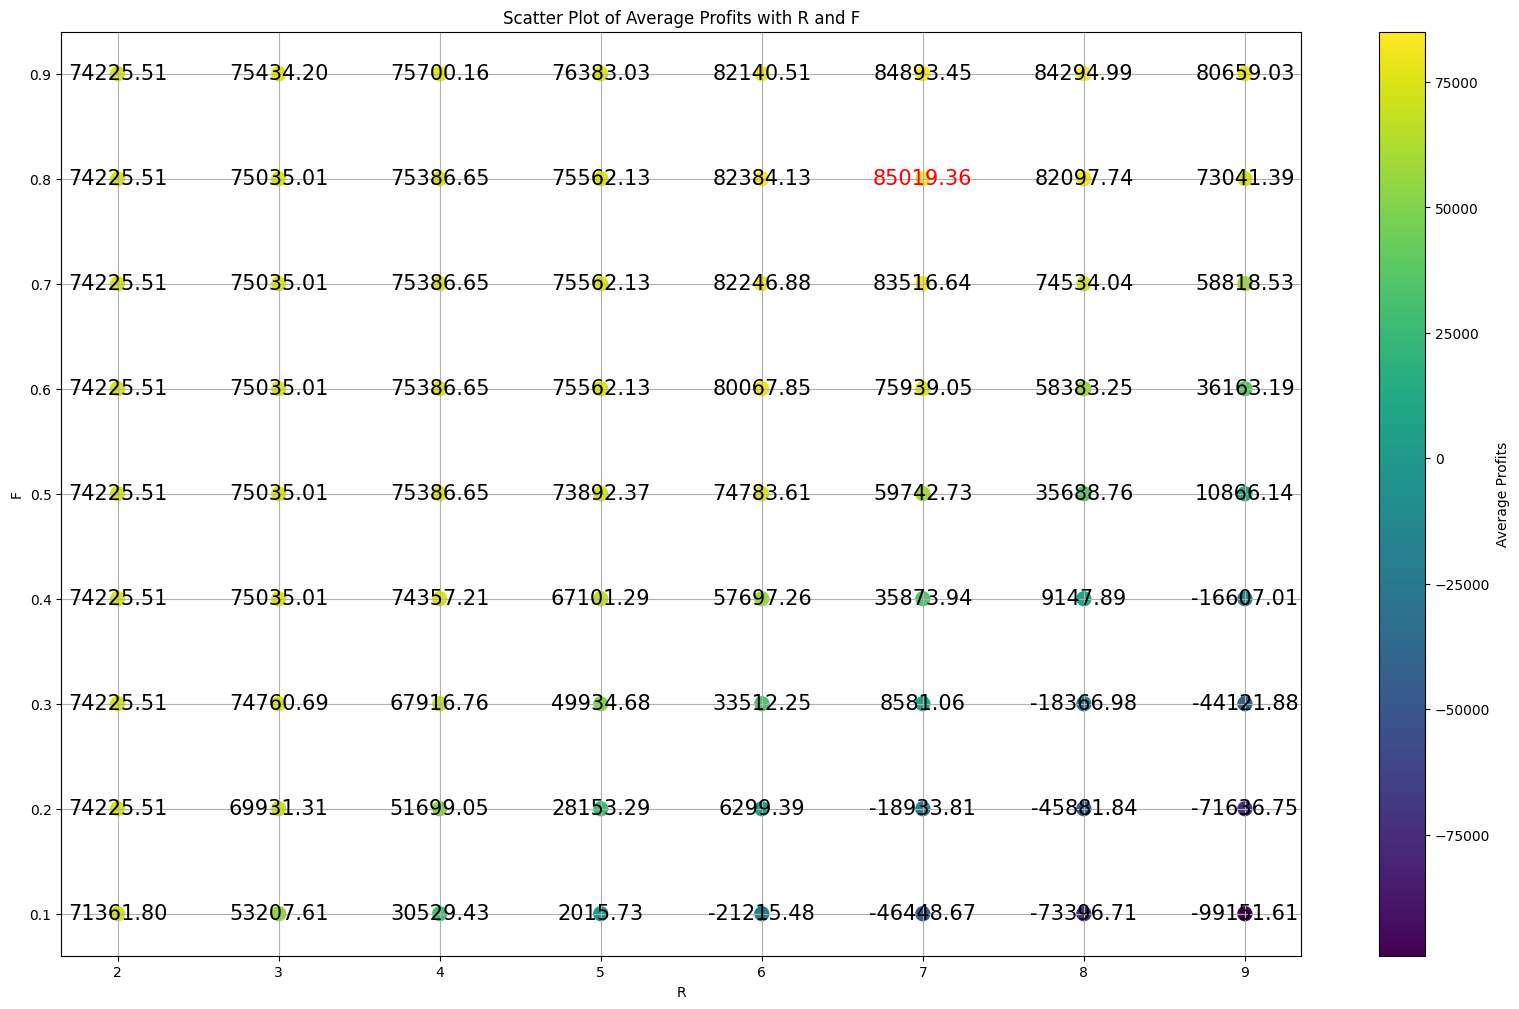

In [100]:
# 找到 'average_profits' 的最大值
max_profit = results_df_8["average_profits"].max()

# 画出散点图
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    results_df_8["R(T)"],
    results_df_8["F"],
    c=results_df_8["average_profits"],
    cmap="viridis",
    s=100,
)
plt.colorbar(label="Average Profits")
plt.xlabel("R")
plt.ylabel("F")
plt.title("Scatter Plot of Average Profits with R and F")
plt.grid(True)

# 在每个数据点上标注数值
for i in range(len(results_df_8)):
    avg_profit = results_df_8["average_profits"].iloc[i]
    # 判断是否等于 max_profit 的整數部分
    if int(avg_profit) == int(max_profit):
        plt.text(
            results_df_8["R(T)"].iloc[i],
            results_df_8["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="red",
        )
    else:
        plt.text(
            results_df_8["R(T)"].iloc[i],
            results_df_8["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="black",
        )

name = "grid_fixed_F_fixed_R_metrics_s8"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

Plot saved as plots/grid_fixed_F_fixed_R_trend_s8_train_linear_constraint_med_with_holding_cost_0_50_202411271920.png


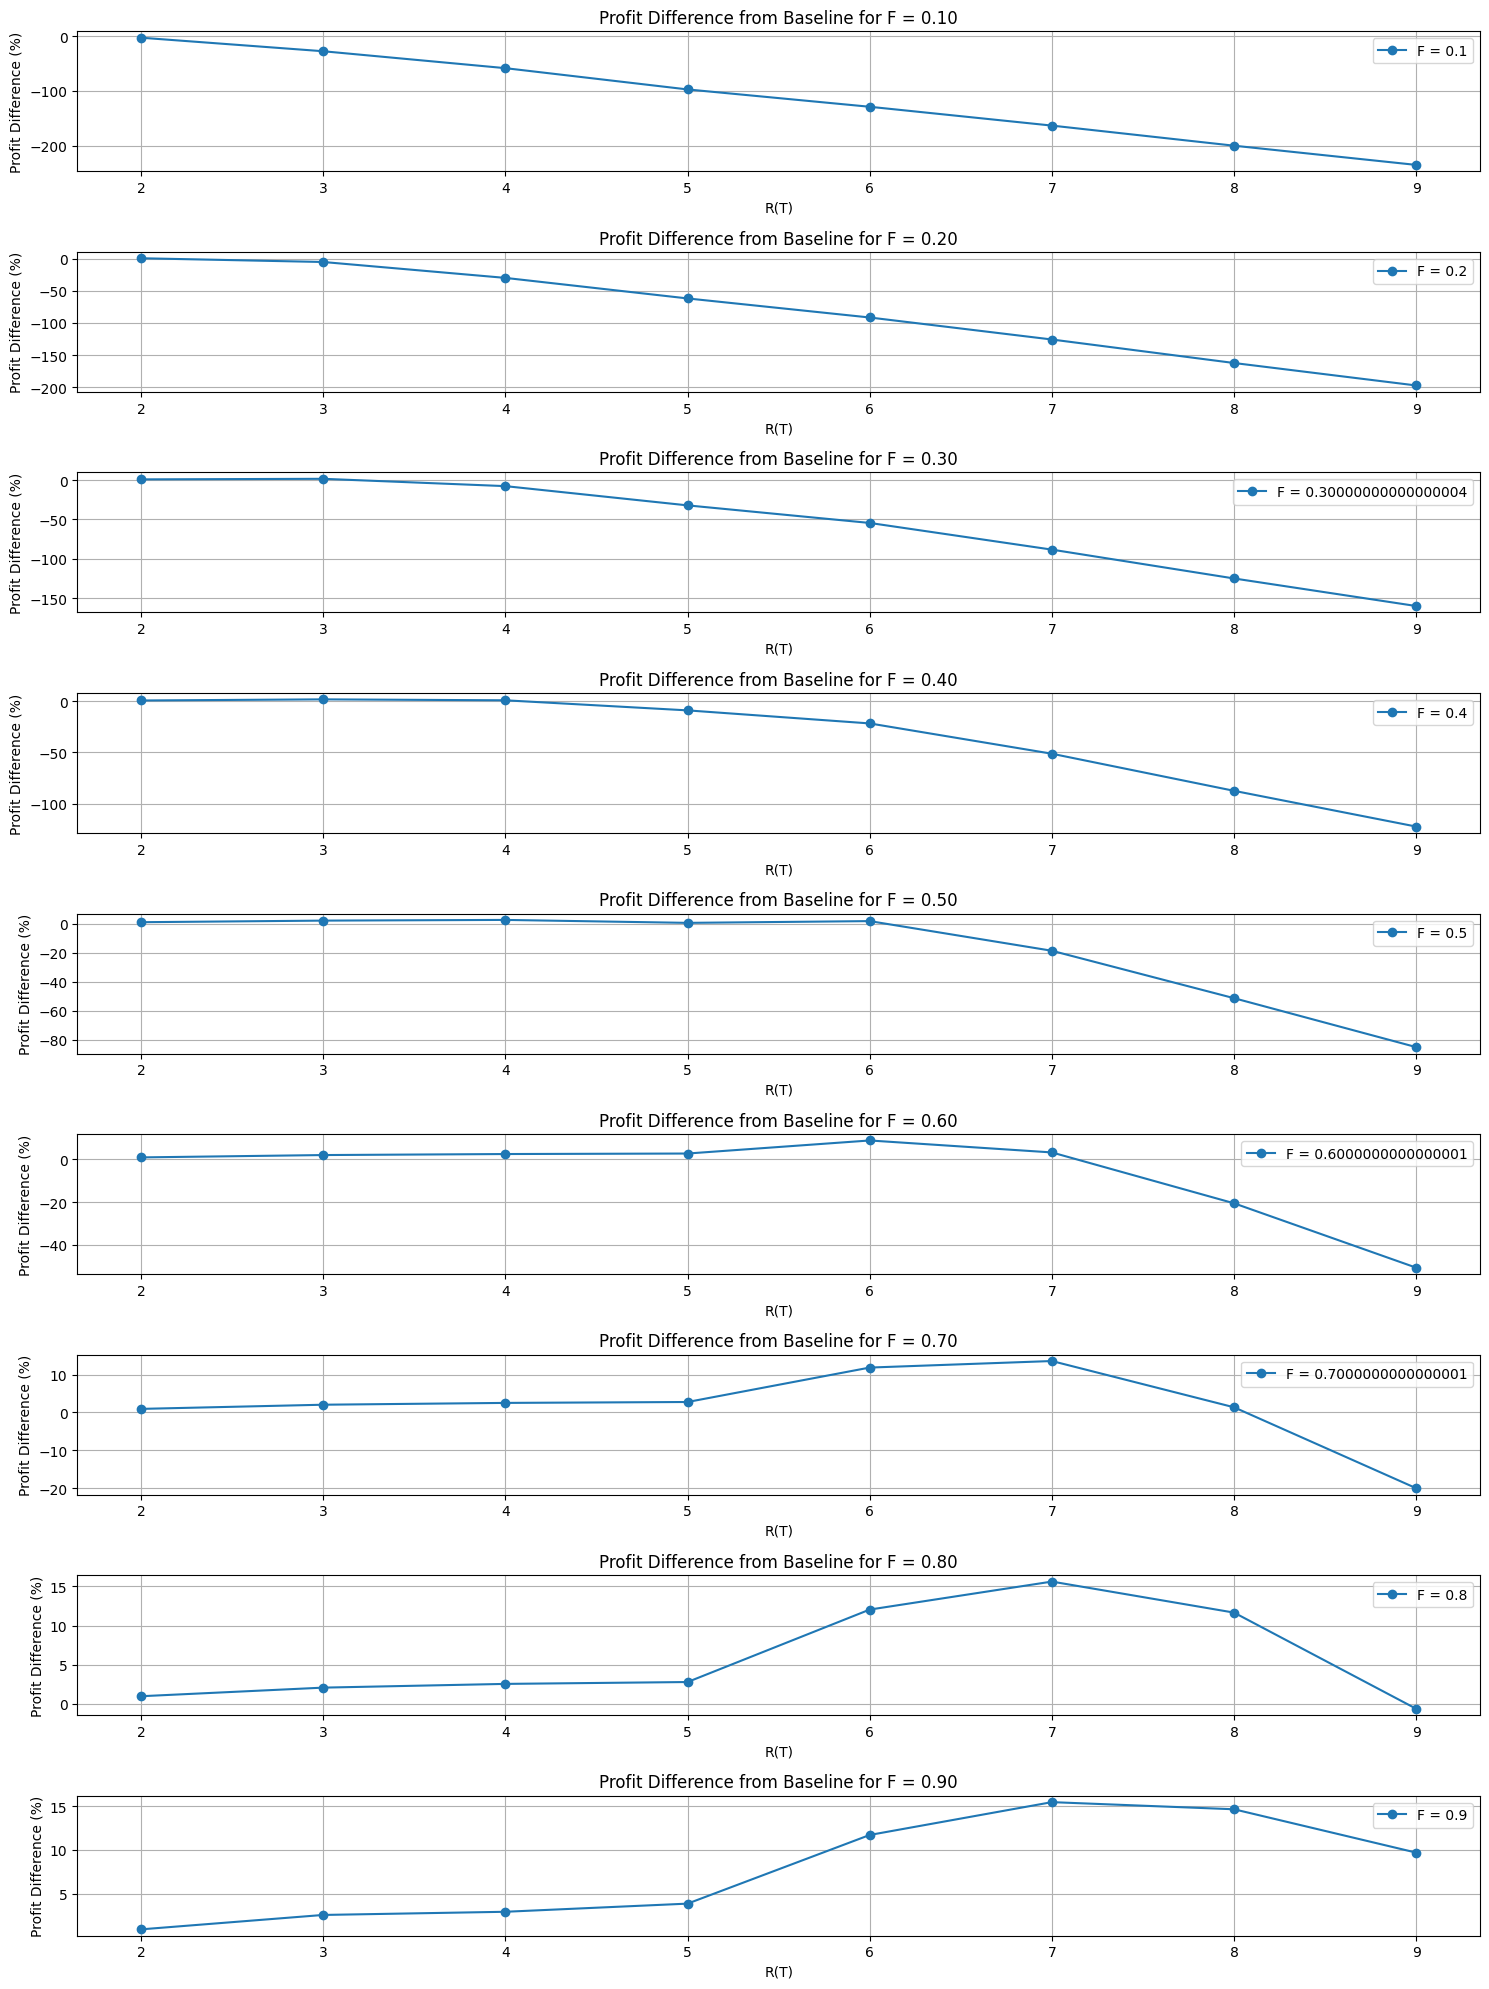

In [101]:
results_df_8["baseline_profit"] = baseline_avg_profits

# Calculate percentage difference from baseline profit
results_df_8["profit_diff_percent"] = (
    (results_df_8["average_profits"] - baseline_avg_profits) / baseline_avg_profits
) * 100

# Plot subplots for different values of F
plt.figure(figsize=(15, 20))

for idx, F in enumerate(ASSIGNED_FS):
    plt.subplot(len(ASSIGNED_FS), 1, idx + 1)
    subset = results_df_8[results_df_8["F"] == F].sort_values(by="R(T)").dropna()
    plt.plot(
        subset["R(T)"],
        subset["profit_diff_percent"],
        marker="o",
        linestyle="-",
        label=f"F = {F}",
    )
    plt.xlabel("R(T)")
    plt.ylabel("Profit Difference (%)")
    plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()

name = "grid_fixed_F_fixed_R_trend_s8"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

### S2 - Grid for Fixed Rk & Flexible F


In [102]:
results_df_2, stimulation_results_df_2 = None, None
results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)
results_df_2

+++++++++++++++++++++++++++++++++++++++ THis is T=2 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1050 rows, 878 columns and 3300 nonzeros
Model fingerprint: 0xeb4c3c7c
Model has 50 general constraints
Variable types: 503 continuous, 375 integer (375 binary)
Coefficient statistics:
  Matrix range     [4e-02, 5e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 5e+06]
Presolve removed 915 rows and 533 columns
Presolve time: 0.01s
Presolved: 135 rows, 345 columns, 974 nonzeros
Presolved model has 25 SOS constraint(s)
Variable types: 32

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_35063/675930583.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


     0     2 1900719.58    0   24          - 1900719.58      -     -    0s
*  415   186              27    1883918.8563 1900652.11  0.89%   4.0    0s
*  454   186              24    1888639.2954 1900652.11  0.64%   4.0    0s

Explored 479 nodes (2278 simplex iterations) in 0.40 seconds (0.06 work units)
Thread count was 12 (of 12 available processors)

Solution count 2: 1.88864e+06 1.88392e+06 

Optimal solution found (tolerance 1.00e-01)
  Piecewise linearization of function constraints often causes big violation.
  Try to adjust the settings of the related parameters, such as FuncPieces.
Best objective 1.888639295431e+06, best bound 1.900652110382e+06, gap 0.6361%

model.status is optimal: True
model.status is TIME_LIMIT: False

===================== 找到最佳解 ==================
Q0_optimal（最佳總庫存量）: 183.43244117652688
Alphas values:
alpha[0]: 2.169642709300104
alpha[1]: 0.1474664799485481
alpha[2]: 5.777533559318256
----------------------------------------------
第 1 筆觀察資料:
第 2 天補貨策略: R_va

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_35063/675930583.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_35063/675930583.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1050 rows, 878 columns and 3300 nonzeros
Model fingerprint: 0x952a8abd
Model has 50 general constraints
Variable types: 503 continuous, 375 integer (375 binary)
Coefficient statistics:
  Matrix range     [4e-02, 5e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 5e+06]
Presolve removed 906 rows and 526 columns
Presolve time: 0.01s
Presolved: 144 rows, 352 columns, 997 nonzeros
Presolved model has 25 SOS constraint(s)
Variable types: 332 continuous, 20 integer (20 binary)

Root relaxation: objective 1.948841e+06, 152 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Un

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_35063/675930583.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


        4         4         4         2         2         2           0s

IIS computed: 4 constraints, 2 bounds
IIS runtime: 0.49 seconds (0.05 work units)
導致不可行的約束： Set_R_14_0_To_1
導致不可行的約束： Define_Q_hat_14
導致不可行的約束： Adjust_Q_hat_14
導致不可行的變量： Q0_var[14], IIS下界： 0, IIS上界： 1
導致不可行的變量： Q1_var[14], IIS下界： 0, IIS上界： 1
模型沒有最佳解
+++++++++++++++++++++++++++++++++++++++ THis is T=6 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1050 rows, 878 columns and 3300 nonzeros
Model fingerprint: 0x63676302
Model has 50 general constraints
Variable types: 503 continuous, 375 integer (375 binary)
Coeff

R(T)                                                  R  average_profits  \
1     3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     76095.994332   
2     4  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...     75863.799548   
0     2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     75545.571817   

   average_losses  average_lefts  average_operation_profits  \
1        8.280782     158.781484               87575.829383   
2        8.322653     140.264520               87554.894016   
0        9.905416     168.068946               86763.512815   

                                        alpha_values  \
1  [275257.3453994372, 29965.432408967976, 515228...   
2  [275257.34539943724, 29965.43240896796, 515228...   
0  [2.169642709300104, 0.1474664799485481, 5.7775...   

                                              F_vars  \
1  [1.0, 0.9996646498695336, 0.999996655093513, 0...   
2  [1.0, 0.9996646498695336, 0.9999966550935132, ...   
0  [0.9975273852982657, 0.808012583457042, 0.9040...   

                                             Q0_vars  \
1  [183.43244117652685, 183.37092708344656, 183.4...   
2  [183.43244117652685, 183.37092708344656, 183.4...   
0  [182.97888342569877, 148.21572068487737, 165.8...   

                                             Q1_vars  
1  [19.72785128169417, 0.0, 33.3070975266791, 9.2...  
2  [17.912057184685857, 0.0, 29.77507209674307, 5...  
0  [17.77453939224102, 35.037489001442815, 35.037...

In [103]:
stimulation_results_df_2

R(T)  R         F        profits     losses       lefts  \
0      3  1  1.000000   72895.333172  57.369626  130.060232   
1      3  1  0.999665   71023.114415   0.000000  173.047980   
2      3  1  0.999997   99996.343765  16.746238  121.332182   
3      3  1  0.999952   84758.047957   0.000000  149.215928   
4      3  1  0.999847   76323.803681   0.000000  175.804449   
5      3  1  0.999853   80675.897541   0.000000  154.146684   
6      3  1  0.999917   80904.609538  21.608055  152.029269   
7      3  1  0.999757   73174.882877   0.000000  161.970683   
8      3  1  0.999748   53447.718149   0.000000  187.381838   
9      3  1  0.999984   89874.657845  14.797178  135.842865   
10     3  1  0.999843   79549.342489   0.000000  166.803175   
11     3  1  0.999841   91413.210722   0.576778  149.413429   
12     3  1  0.999686   76537.733581   0.000000  165.402283   
13     3  1  0.999796   91695.822205   0.003465  146.035753   
14     3  1  0.999988   80082.496441   0.000000  151.249245   
15     3  1  0.999979   84486.215033  14.456147  151.520010   
16     3  1  0.999988   70111.458591  43.207367  146.743971   
17     3  1  0.999931  100322.420325   0.000000  130.861708   
18     3  1  0.999763   48666.763449   0.000000  189.935747   
19     3  1  0.999985   76876.438811  37.862694  139.539339   
20     3  1  0.999713   33557.835252   0.000000  217.839322   
21     3  1  0.999815   79324.481536   0.000000  157.732623   
22     3  1  0.999833   91504.905038   0.392013  159.615640   
23     3  1  0.997527   32251.299958   0.000000  200.966704   
24     3  1  0.999865   82945.025933   0.000000  155.046035   

    operation_profits          Q0         Q1         hc0  ...  demand_up  \
0       101580.146229  183.432441  19.727851  333.220524  ...  53.372209   
1        81354.288978  183.370927   0.000000  335.756558  ...  30.985296   
2       108369.462569  183.431828  33.307098  338.071107  ...  62.099646   
3        90548.646124  183.423596   9.254892  330.313220  ...  45.788865   
4        84012.988216  183.404346   0.000000  343.830426  ...  22.978265   
5        88508.150603  183.405520   9.275287  331.162985  ...  44.923342   
6        91708.636962  183.417274   0.000000  335.446543  ...  31.388005   
7        83623.749294  183.387870   4.757361  329.218182  ...  42.314920   
8        72570.390615  183.386126   0.000000  332.522619  ...  34.249633   
9        97273.246926  183.429467  11.117027  330.389359  ...  47.586602   
10       85625.578806  183.403630   0.000000  338.054332  ...  28.752928   
11       91701.599873  183.403200   0.000000  332.816629  ...  33.989770   
12       84112.581032  183.374857   0.000000  333.627445  ...  33.122269   
13       91697.554537  183.395109   0.000000  329.430862  ...  37.359356   
14       92076.000317  183.430235  24.708773  335.401246  ...  56.167998   
15       91714.288448  183.428577   0.000000  334.948587  ...  31.908567   
16       91715.142006  183.430284   0.000000  330.174255  ...  36.686313   
17      103275.160705  183.419704  29.036098  337.412029  ...  58.463477   
18       70180.620031  183.388953   0.000000  330.296987  ...  36.480919   
19       95807.785629  183.429609   8.185963  331.154910  ...  43.890270   
20       62623.886743  183.379876   0.000000  343.087096  ...  23.672657   
21       85511.880043  183.398557   0.000000  328.756383  ...  38.040731   
22       91700.911675  183.401823   0.000000  343.017464  ...  23.786183   
23       64778.599341  182.978882  11.632916  330.523903  ...  47.066776   
24       87324.438868  183.407704   0.000000  329.694912  ...  37.120495   

    demand_down     Sold0s      Sold1s      Left0s     Left1s  lost0s  \
0    207.157709  53.372209  149.788083  130.060232   0.000000     0.0   
1    131.723282  30.985296  131.723282  152.385631  20.662349     0.0   
2    171.385517  62.099646  154.639279  121.332182   0.000000     0.0   
3    135.308428  45.788865  135.308428  137.634732  11.581196     0.0   
4    145.047711  22.978

In [104]:
stimulation_results_df_2_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_2, Q_star, Qk_hat_df_train
)
stimulation_results_df_2_selected

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_35063/1770888325.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["Q0-Sold0s(left0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_35063/1770888325.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["demand_up-Q0(lost0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_35063/1770888325.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

R      Q_star         F          Q0  demand_up     Sold0s      Left0s  \
0   1  183.432441  1.000000  183.432441  53.372209  53.372209  130.060232   
1   1  183.432441  0.999665  183.370927  30.985296  30.985296  152.385631   
2   1  183.432441  0.999997  183.431828  62.099646  62.099646  121.332182   
3   1  183.432441  0.999952  183.423596  45.788865  45.788865  137.634732   
4   1  183.432441  0.999847  183.404346  22.978265  22.978265  160.426080   
5   1  183.432441  0.999853  183.405520  44.923342  44.923342  138.482178   
6   1  183.432441  0.999917  183.417274  31.388005  31.388005  152.029269   
7   1  183.432441  0.999757  183.387870  42.314920  42.314920  141.072951   
8   1  183.432441  0.999748  183.386126  34.249633  34.249633  149.136493   
9   1  183.432441  0.999984  183.429467  47.586602  47.586602  135.842865   
10  1  183.432441  0.999843  183.403630  28.752928  28.752928  154.650702   
11  1  183.432441  0.999841  183.403200  33.989770  33.989770  149.413429   
12  1  183.432441  0.999686  183.374857  33.122269  33.122269  150.252588   
13  1  183.432441  0.999796  183.395109  37.359356  37.359356  146.035753   
14  1  183.432441  0.999988  183.430235  56.167998  56.167998  127.262237   
15  1  183.432441  0.999979  183.428577  31.908567  31.908567  151.520010   
16  1  183.432441  0.999988  183.430284  36.686313  36.686313  146.743971   
17  1  183.432441  0.999931  183.419704  58.463477  58.463477  124.956227   
18  1  183.432441  0.999763  183.388953  36.480919  36.480919  146.908034   
19  1  183.432441  0.999985  183.429609  43.890270  43.890270  139.539339   
20  1  183.432441  0.999713  183.379876  23.672657  23.672657  159.707219   
21  1  183.432441  0.999815  183.398557  38.040731  38.040731  145.357826   
22  1  183.432441  0.999833  183.401823  23.786183  23.786183  159.615640   
23  1  183.432441  0.997527  182.978882  47.066776  47.066776  135.912106   
24  1  183.432441  0.999865  183.407704  37.120495  37.120495  146.287209   

    lost0s      Qk_hat  Qk_hat-Q0  ...     Left1s     lost1s  \
0      0.0  203.160292  19.727851  ...   0.000000  57.369626   
1      0.0  170.522712 -12.848215  ...  20.662349   0.000000   
2      0.0  216.738925  33.307098  ...   0.000000  16.746238   
3      0.0  192.678489   9.254892  ...  11.581196   0.000000   
4      0.0  159.510823 -23.893522  ...  15.378369   0.000000   
5      0.0  192.680807   9.275287  ...  15.664506   0.000000   
6      0.0  172.436062 -10.981212  ...   0.000000  21.608055   
7      0.0  188.145231   4.757361  ...  20.897733   0.000000   
8      0.0  174.241291  -9.144836  ...  38.245345   0.000000   
9      0.0  194.546494  11.117027  ...   0.000000  14.797178   
10     0.0  167.946118 -15.457513  ...  12.152473   0.000000   
11     0.0  175.522569  -7.880631  ...   0.000000   0.576778   
12     0.0  174.641718  -8.733139  ...  15.149695   0.000000   
13     0.0  182.487228  -0.907881  ...   0.000000   0.003465   
14     0.0  208.139008  24.708773  ...  23.987008   0.000000   
15     0.0  172.145916 -11.282661  ...   0.000000  14.456147   
16     0.0  180.087523  -3.342761  ...   0.000000  43.207367   
17     0.0  212.455802  29.036098  ...   5.905481   0.000000   
18     0.0  178.705892  -4.683061  ...  43.027713   0.000000   
19     0.0  191.615571   8.185963  ...   0.000000  37.862694   
20     0.0  160.946779 -22.433097  ...  58.132103   0.000000   
21     0.0  183.193315  -0.205242  ...  12.374797   0.000000   
22     0.0  158.616561 -24.785262  ...   0.000000   0.392013   
23     0.0  194.611797  11.632916  ...  65.054599   0.000000   
24     0.0  180.034105  -3.373599  ...   8.758826   0.000000   

    Q0-Sold0s(left0)  demand_up-Q0(lost0)  Q1_plus_lefts-Sold1s(left1)  \
0         130.060232          -130.060232                -1.862645e-09   
1         152.385631          -152.385631                 2.066235e+01   
2         121.332182          -121.332182                -1.862645e-09   
3         137.634732          -137.63473

In [105]:
rounded_difference_df

Metric  Average Difference
0                  Left0s - Q0-Sold0s(left0)                -0.0
1               Lost0s - demand_up-Q0(lost0)                 0.0
2       Left1s - Q1_plus_lefts-Sold1s(left1)                -0.0
3  Lost1s - demand_down-Q1_plus_lefts(lost1)                -0.0

In [106]:
# # 驗證 Q1 計算是否正確

# if stimulation_results_df_2 is not None and len(stimulation_results_df_2) > 0:
#     stimulation_results_df_2["Qk_hat"] = Qk_hat_df_train.iloc[
#         :, stimulation_results_df_2.iloc[0, 0]
#     ]
#     stimulation_results_df_2["Qk_hat-Q0"] = (
#         stimulation_results_df_2["Qk_hat"] - stimulation_results_df_2["Q0"]
#     )
#     stimulation_results_df_2["Q_star"] = Q_star
#     print(
#         stimulation_results_df_2[
#             ["R", "F", "Q_star", "Q0", "Qk_hat", "Qk_hat-Q0", "Q1"]
#         ]
#     )

In [107]:
if results_df_2 is not None and len(results_df_2) > 0:
    save_model_parameters(
        f"{model_prefix}_s2", alpha_values=results_df_2.iloc[0]["alpha_values"]
    )

Model parameters saved as models/linear_constraint_med_with_holding_cost_0_s2_50_202411271920.pkl


In [108]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_2.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "average_profits"]]
top_three_info

R(T)  average_profits
1     3     76095.994332
2     4     75863.799548
0     2     75545.571817

### S3 - Grid for Fixed F & Flexible Rk


In [109]:
results_df_3, stimulation_results_df_3 = None, None
results_df_3, stimulation_results_df_3 = grid_fixed_F_flexible_R(
    assigned_Fs=ASSIGNED_FS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)


results_df_3

+++++++++++++++++++++++++++++++++++++++ THis is F=0.1 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 2000


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_35063/2035653732.py:247: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1500 rows, 1699 columns and 4800 nonzeros
Model fingerprint: 0x32cc6256
Model has 250 quadratic constraints
Model has 450 general constraints
Variable types: 1324 continuous, 375 integer (350 binary)
Coefficient statistics:
  Matrix range     [4e-02, 5e+06]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e-01, 5e+06]
  GenCon coe range [1e+00, 1e+00]
Presolve added 550 rows and 31525 columns
Presolve time: 0.03s

Explored 0 nodes (0 simplex iterations) in 0.07 seconds (0.02 work units)
Thread count was 1 (of 12 available processors)

Solution count 0

Model is infeasible or unbounde

Empty DataFrame
Columns: [R(T), average_losses, average_lefts, average_operation_profits, average_profits, beta_values, F_vars, Q0_vars, Q1_vars, tau_values]
Index: []

In [110]:
if results_df_3 is not None and len(results_df_3) > 0:
    save_model_parameters(
        f"{model_prefix}_s3",
        beta_values=results_df_3.iloc[0]["beta_values"],
        tau_values=results_df_3.iloc[0]["tau_values"],
    )

In [111]:
stimulation_results_df_3_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_3, Q_star, Qk_hat_df_train
)
stimulation_results_df_3_selected

In [112]:
rounded_difference_df

In [113]:
if results_df_3 is not None and len(results_df_3) > 0:

    r_values = results_df_3["R(T)"].explode().values
    f_values = results_df_3["F_vars"].explode().values

    plt.figure(figsize=(10, 6))
    plt.plot(f_values, r_values, marker="o", linestyle="-", color="b")

    plt.title("R(T) vs F_vars Visualization")
    plt.xlabel("F_vars")
    plt.ylabel("R(T)")

    plt.grid(True)

    name = "result_3_metrics"

    os.makedirs("plots", exist_ok=True)
    save_path = (
        f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"
    )

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

else:
    print("results_df_3 is None")

results_df_3 is None


### Fully flexible F & Rk


#### S5 - Simple beta with softmax


In [114]:
results_df_5, stimulation_results_df_5 = None, None
results_df_5, stimulation_results_df_5 = fully_flexible_simple_beta_with_softmax_5(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)
results_df_5

Set parameter Threads to value 12
Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 2000


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_35063/104858953.py:265: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1500 rows, 1735 columns and 4475 nonzeros
Model fingerprint: 0xf3132013
Model has 250 quadratic constraints
Model has 475 general constraints
Variable types: 1360 continuous, 375 integer (350 binary)
Coefficient statistics:
  Matrix range     [4e-02, 5e+06]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 5e+06]
  GenCon coe range [1e+00, 1e+00]
Presolve added 303 rows and 31195 columns
Presolve time: 0.35s
Presolved: 9753 rows, 34805 columns, 120930 nonzeros
Presolved model has 225 SOS constraint(s)
Presolved model has 1875 bilinear constraint(s)

Solving non-convex MIQCP

Var

average_profits  average_losses  average_lefts  average_operation_profits  \
0      84486.39825         0.28086      88.078311                87658.56894   

                                        alpha_values  \
0  [0.41167387725206595, 0.11960239950515202, 2.6...   

                                         beta_values  \
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                          tau_values  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....

In [115]:
if results_df_5 is not None:
    save_model_parameters(
        f"{model_prefix}_s5",
        alpha_values=results_df_5.iloc[0]["alpha_values"],
        beta_values=results_df_5.iloc[0]["beta_values"],
        tau_values=results_df_5.iloc[0]["tau_values"],
        f_values=stimulation_results_df_5["f_values"].values,
    )

Model parameters saved as models/linear_constraint_med_with_holding_cost_0_s5_50_202411271920.pkl


In [116]:
stimulation_results_df_5

R(T)  R         F  f_values        profits    losses       lefts  \
0      4  2  0.972929  3.489864  100672.249181  0.000000  157.765932   
1      8  6  0.866787  1.926419   80476.279830  0.000000   44.960128   
2      5  3  0.960032  3.253338  104306.851639  0.000000   88.086769   
3      9  7  0.934247  3.056139   90412.921054  0.000000   19.951138   
4      3  1  0.909253  2.562271   83393.221634  0.000000  145.047711   
5      2  0  0.912310  2.622683   87141.345550  0.000000  152.018379   
6      9  7  0.925925  2.891706  101450.716476  0.000000    5.617460   
7      9  7  0.892670  2.234598   82069.801205  0.000000   34.792961   
8      9  7  0.886380  2.110309   63845.392066  0.000000   66.742381   
9      6  4  0.941675  2.848146  100906.428907  0.000000   72.955725   
10     3  1  0.916520  2.705875   84059.774427  0.000000  142.498230   
11     6  4  0.908566  2.548698   83330.219689  0.000000  104.371805   
12     4  2  0.882212  2.027949   83659.405976  0.000000  107.284887   
13     3  1  0.905993  2.497861   91243.613854  0.000000  129.740496   
14     8  6  0.952574  3.021014   89432.413784  0.000000   44.444944   
15     8  6  0.932487  2.720140   98929.402147  0.000000   30.450740   
16     5  3  0.952122  2.993707   92815.605632  0.000000  140.978150   
17     9  7  0.928902  2.950525   96253.654450  7.021506    0.000000   
18     9  7  0.893023  2.241581   58456.535579  0.000000   57.414299   
19     4  2  0.952574  3.000000   97236.979693  0.000000  147.042107   
20     7  5  0.886371  2.110140   43953.170013  0.000000  130.257402   
21     5  3  0.902960  2.437936   85245.292005  0.000000  106.129265   
22     7  5  0.913160  2.639475   91019.529797  0.000000   65.309681   
23     5  3  0.832206  1.744793   35711.661065  0.000000  127.305618   
24     6  4  0.916688  2.709191   86137.490591  0.000000   80.791554   

    operation_profits          Q0         Q1  ...      Left0s     Left1s  \
0       100672.249181  178.466688  22.877811  ...  157.765932   0.000000   
1        80476.279830  158.996919   1.955641  ...   44.960128   0.000000   
2       104306.851639  176.101071  32.512632  ...   88.086769   0.000000   
3        90548.646124  171.371126   9.997616  ...   19.679688   0.271450   
4        83393.221634  166.786443   0.000000  ...  145.047711   0.000000   
5        88508.150603  167.347257  12.402655  ...  149.284769   2.733610   
6       101450.716476  169.844659  33.056774  ...    5.617460   0.000000   
7        83623.749294  163.744583   6.610812  ...   31.685065   3.107896   
8        72570.390615  162.590778   0.000000  ...   49.292384  17.449997   
9       100906.428907  172.733654  29.079203  ...   72.955725   0.000000   
10       84059.774427  168.119549   0.000000  ...  142.498230   0.000000   
11       83330.219689  166.660439   0.000000  ...  104.371805   0.000000   
12       84112.581032  161.826216   7.305296  ...  106.378538   0.906349   
13       91243.613854  166.188506  16.298722  ...  129.740496   0.000000   
14       92076.000317  174.732998  14.706176  ...   39.157771   5.287173   
15       98929.402147  171.048289  26.810515  ...   30.450740   0.000000   
16       92815.605632  174.650142  10.981070  ...  140.978150   0.000000   
17       99764.407578  170.390683  29.138132  ...    0.000000   0.000000   
18       70180.620031  163.809409   0.000000  ...   33.966130  23.448169   
19       97236.979693  174.732997  19.740962  ...  147.042107   0.000000   
20       62623.886743  162.589207   0.000000  ...   92.915969  37.341433   
21       85511.880043  165.632214   5.924723  ...  105.596089   0.533176   
22       91019.529797  167.503140  14.535919  ...   65.309681   0.000000   
23       64778.599341  152.653586  35.037489  ...   69.171741  58.133877   
24       87324.438868  168.150330   8.872444  ...   78.417657   2.373897   

    lost0s    lost1s      Qk_hat      Sold0s      Sold1s   demand_up  \
0      0.0  0.000000  201.344498   20.700755  180.643743   79.886176   
1      0.0

In [117]:
stimulation_results_df_5_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_5, Q_star, Qk_hat_df_train
)
stimulation_results_df_5_selected

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_35063/1770888325.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["Q0-Sold0s(left0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_35063/1770888325.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["demand_up-Q0(lost0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_35063/1770888325.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

R      Q_star         F          Q0   demand_up      Sold0s      Left0s  \
0   2  183.432441  0.972929  178.466688   79.886176   20.700755  157.765932   
1   6  183.432441  0.866787  158.996919  115.792810  114.036791   44.960128   
2   3  183.432441  0.960032  176.101071  112.885762   88.014302   88.086769   
3   7  183.432441  0.934247  171.371126  151.691438  151.691438   19.679688   
4   1  183.432441  0.909253  166.786443   22.978265   21.738732  145.047711   
5   0  183.432441  0.912310  167.347257   18.062488   18.062488  149.284769   
6   7  183.432441  0.925925  169.844659  166.351094  164.227198    5.617460   
7   7  183.432441  0.892670  163.744583  132.059518  132.059518   31.685065   
8   7  183.432441  0.886380  162.590778  113.298395  113.298395   49.292384   
9   4  183.432441  0.941675  172.733654  107.308744   99.777930   72.955725   
10  1  183.432441  0.916520  168.119549   28.752928   25.621319  142.498230   
11  4  183.432441  0.908566  166.660439   79.608173   62.288635  104.371805   
12  2  183.432441  0.882212  161.826216   55.447678   55.447678  106.378538   
13  1  183.432441  0.905993  166.188506   37.359356   36.448010  129.740496   
14  6  183.432441  0.952574  174.732998  135.575227  135.575227   39.157771   
15  6  183.432441  0.932487  171.048289  140.623468  140.597549   30.450740   
16  3  183.432441  0.952122  174.650142   74.678431   33.671991  140.978150   
17  7  183.432441  0.928902  170.390683  170.390683  170.390683    0.000000   
18  7  183.432441  0.893023  163.809409  129.843279  129.843279   33.966130   
19  2  183.432441  0.952574  174.732997   62.695196   27.690890  147.042107   
20  5  183.432441  0.886371  162.589207   69.673238   69.673238   92.915969   
21  3  183.432441  0.902960  165.632214   60.036124   60.036124  105.596089   
22  5  183.432441  0.913160  167.503140  103.948236  102.193459   65.309681   
23  3  183.432441  0.832206  152.653586   83.481845   83.481845   69.171741   
24  4  183.432441  0.916688  168.150330   89.732673   89.732673   78.417657   

    lost0s      Qk_hat  Qk_hat-Q0  ...     Left1s    lost1s  Q0-Sold0s(left0)  \
0      0.0  201.344498  22.877811  ...   0.000000  0.000000        157.765932   
1      0.0  160.952560   1.955641  ...   0.000000  0.000000         44.960128   
2      0.0  208.613703  32.512632  ...   0.000000  0.000000         88.086769   
3      0.0  181.368742   9.997616  ...   0.271450  0.000000         19.679688   
4      0.0  159.510823  -7.275620  ...   0.000000  0.000000        145.047711   
5      0.0  179.749911  12.402655  ...   2.733610  0.000000        149.284769   
6      0.0  202.901433  33.056774  ...   0.000000  0.000000          5.617461   
7      0.0  170.355395   6.610812  ...   3.107896  0.000000         31.685065   
8      0.0  140.770421 -21.820357  ...  17.449997  0.000000         49.292384   
9      0.0  201.812858  29.079203  ...   0.000000  0.000000         72.955725   
10     0.0  167.946118  -0.173431  ...   0.000000  0.000000        142.498230   
11     0.0  166.287679  -0.372760  ...   0.000000  0.000000        104.371805   
12     0.0  169.131512   7.305296  ...   0.906349  0.000000        106.378538   
13     0.0  182.487228  16.298722  ...   0.000000  0.000000        129.740496   
14     0.0  189.439174  14.706176  ...   5.287173  0.000000         39.157771   
15     0.0  197.858804  26.810515  ...   0.000000  0.000000         30.450740   
16     0.0  185.631211  10.981070  ...   0.000000  0.000000        140.978150   
17     0.0  199.528815  29.138132  ...   0.000000  7.021506          0.000000   
18     0.0  150.091287 -13.718122  ...  23.448169  0.000000         33.966130   
19     0.0  194.473959  19.740962  ...   0.000000  0.000000        147.042107   
20     0.0  127.158231 -35.430976  ...  37.341433  0.000000         92.915969   
21     0.0  171.556936   5.924723  ...   0.533176  0.000000        105.596089   
22     0.0  182.039060  14.535919  ...   0.000000  0.000000         65.309681   
23   

In [118]:
rounded_difference_df

Metric  Average Difference
0                  Left0s - Q0-Sold0s(left0)                -0.0
1               Lost0s - demand_up-Q0(lost0)                 0.0
2       Left1s - Q1_plus_lefts-Sold1s(left1)                -0.0
3  Lost1s - demand_down-Q1_plus_lefts(lost1)                -0.0

#### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [119]:
results_df_6, stimulation_results_df_6 = None, None
results_df_6, stimulation_results_df_6 = fully_flexible_simple_beta_with_softmax_6(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)
results_df_6

Set parameter Threads to value 12
Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 2000


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_35063/3055309810.py:277: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1500 rows, 1686 columns and 4775 nonzeros
Model fingerprint: 0xea21bbc6
Model has 225 quadratic constraints
Model has 450 general constraints
Variable types: 1311 continuous, 375 integer (350 binary)
Coefficient statistics:
  Matrix range     [4e-02, 5e+06]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 5e+06]
  GenCon coe range [1e+00, 1e+00]
Presolve added 278 rows and 27343 columns
Presolve time: 0.37s
Presolved: 2828 rows, 29104 columns, 89780 nonzeros
Presolved model has 200 SOS constraint(s)
Presolved model has 250 bilinear constraint(s)

Solving non-convex MIQCP

Varia

average_profits  average_losses  average_lefts  average_operation_profits  \
0     88084.661835        0.146424      68.336911               89537.419163   

                                        alpha_values  \
0  [1.370607238625958, 0.5677077414860987, 3.0790...   

                                         beta_values  \
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                          tau_values  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....

In [120]:
if results_df_6 is not None:
    save_model_parameters(
        f"{model_prefix}_s6",
        alpha_values=results_df_6.iloc[0]["alpha_values"],
        beta_values=results_df_6.iloc[0]["beta_values"],
        tau_values=results_df_6.iloc[0]["tau_values"],
        f_values=stimulation_results_df_6["f_values"].values,
    )

Model parameters saved as models/linear_constraint_med_with_holding_cost_0_s6_50_202411271920.pkl


In [121]:
stimulation_results_df_6_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_6, Q_star, Qk_hat_df_train
)
stimulation_results_df_6_selected

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_35063/1770888325.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["Q0-Sold0s(left0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_35063/1770888325.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["demand_up-Q0(lost0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_35063/1770888325.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

R      Q_star         F          Q0   demand_up      Sold0s      Left0s  \
0   3  183.432441  0.997736  183.017092  114.666793   70.402707  112.614385   
1   6  183.432441  0.686438  125.915071  115.792810  114.036791   11.878279   
2   1  183.432441  0.994359  182.397630   62.099646   45.353408  137.044222   
3   7  183.432441  0.985106  180.700320  151.691438  151.691438   29.008882   
4   7  183.432441  0.916010  168.025976  123.704677  123.704677   44.321300   
5   0  183.432441  0.929843  170.563450   18.062488   18.062488  152.500962   
6   6  183.432441  0.973251  178.525740  143.683441  143.683441   34.842299   
7   7  183.432441  0.837015  153.535683  132.059518  132.059518   21.476165   
8   5  183.432441  0.722892  132.601779   95.043630   93.854809   38.746970   
9   7  183.432441  0.978591  179.505364  183.165976  179.505364    0.000000   
10  7  183.432441  0.958674  175.851856  131.336513  131.336513   44.515343   
11  3  183.432441  0.915362  167.907004   66.747272   66.193962  101.713042   
12  2  183.432441  0.753381  138.194504   55.447678   55.447678   82.746825   
13  7  183.432441  0.923528  169.405052  136.523704  136.523704   32.881348   
14  6  183.432441  0.988311  181.288245  135.575227  135.575227   45.713018   
15  6  183.432441  0.967518  177.474198  140.623468  140.597549   36.876649   
16  4  183.432441  0.986375  180.933084  100.387702   89.565467   91.367618   
17  2  183.432441  0.982185  180.164601   86.086741   86.086741   94.077860   
18  7  183.432441  0.833094  152.816557  129.843279  129.843279   22.973278   
19  5  183.432441  0.989687  181.540725  124.201352  109.853906   71.686819   
20  4  183.432441  0.788285  144.597067   59.315381   59.315381   85.281686   
21  3  183.432441  0.896941  164.528163   60.036124   60.036124  104.492039   
22  1  183.432441  0.944908  173.326831   23.786183   13.319177  160.007654   
23  6  183.432441  0.491298   90.119921   87.671886   83.272097    6.847823   
24  5  183.432441  0.948253  173.940287   98.817816   98.109225   75.831062   

      lost0s      Qk_hat  Qk_hat-Q0  ...     Left1s  lost1s  Q0-Sold0s(left0)  \
0   0.000000  216.265833  33.248741  ...   0.000000     0.0        112.614385   
1   0.000000  160.952560  35.037489  ...   0.000000     0.0         11.878279   
2   0.000000  216.738925  34.341295  ...   0.000000     0.0        137.044222   
3   0.000000  181.368742   0.668422  ...   0.271450     0.0         29.008882   
4   0.000000  163.739262  -4.286715  ...   0.000000     0.0         44.321300   
5   0.000000  179.749911   9.186461  ...   2.733610     0.0        152.500962   
6   0.000000  210.028220  31.502481  ...   5.002892     0.0         34.842299   
7   0.000000  170.355395  16.819712  ...   3.107896     0.0         21.476165   
8   0.000000  143.951960  11.350181  ...   0.000000     0.0         38.746970   
9   3.660612  213.130521  33.625157  ...   7.447461     0.0          0.000000   
10  0.000000  170.180651  -5.671205  ...   4.600698     0.0         44.515343   
11  0.000000  183.426668  15.519665  ...   0.000000     0.0        101.713042   
12  0.000000  169.131512  30.937008  ...   0.906349     0.0         82.746826   
13  0.000000  184.390054  14.985002  ...   0.991481     0.0         32.881348   
14  0.000000  189.439174   8.150928  ...   5.287173     0.0         45.713018   
15  0.000000  197.858804  20.384607  ...   0.000000     0.0         36.876649   
16  0.000000  215.815415  34.882331  ...   0.000000     0.0         91.367618   
17  0.000000  212.840779  32.676178  ...   6.290458     0.0         94.077860   
18  0.000000  150.091287  -2.725270  ...  12.455317     0.0         22.973278   
19  0.000000  215.130818  33.590094  ...   0.000000     0.0         71.686819   
20  0.000000  120.527128 -24.069939  ...  19.349293     0.0         85.281686   
21  0.000000  171.556936   7.028773  ...   0.533176     0.0        104.492039   
22  0.000000  158.616561 -14.710270  ...   0.000000     0.0        160.007654   
23  0

In [122]:
rounded_difference_df

Metric  Average Difference
0                  Left0s - Q0-Sold0s(left0)                -0.0
1               Lost0s - demand_up-Q0(lost0)                 0.0
2       Left1s - Q1_plus_lefts-Sold1s(left1)                -0.0
3  Lost1s - demand_down-Q1_plus_lefts(lost1)                 0.0

#### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [123]:
results_df_7, stimulation_results_df_7 = None, None
# results_df_7, stimulation_results_df_7 = fully_flexible_simple_beta_with_softmax_7(
#     salvage_value=salvage_value,
#     cost=cost,
#     price=price,
#     Q_star=Q_star,
#     demand_df_train=demand_df_train,
#     Qk_hat_df=Qk_hat_df_train,
#     training_df=training_df,
#     holding_cost=holding_cost,
# )
# results_df_7

In [124]:
if results_df_7 is not None:

    save_model_parameters(
        f"{model_prefix}_s7",
        alpha_values=results_df_7.iloc[0]["alpha_values"],
        beta_values=results_df_7.iloc[0]["beta_values"],
        tau_values=results_df_7.iloc[0]["tau_values"],
        f_values=stimulation_results_df_7["f_values"].values,
    )

In [125]:
stimulation_results_df_7

In [126]:
stimulation_results_df_7_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_7, Q_star, Qk_hat_df_train
)
stimulation_results_df_7_selected

In [127]:
rounded_difference_df

#### S4 - Beta with softmax


In [ ]:
results_df_4, stimulation_results_df_4 = None, None
results_df_4, stimulation_results_df_4 = fully_flexible_beta_with_softmax_4(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)
results_df_4

Set parameter Threads to value 12
Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads



/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_35063/853573315.py:265: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1500 rows, 1727 columns and 4875 nonzeros
Model fingerprint: 0xe6fc4b73
Model has 250 quadratic constraints
Model has 475 general constraints
Variable types: 1352 continuous, 375 integer (350 binary)
Coefficient statistics:
  Matrix range     [4e-02, 5e+06]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 5e+06]
  GenCon coe range [1e+00, 1e+00]
Presolve added 503 rows and 31419 columns
Presolve time: 0.44s
Presolved: 6878 rows, 34246 columns, 112555 nonzeros
Presolved model has 225 SOS constraint(s)
Presolved model has 1125 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 33746 continuous, 500 integer (475 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.03s

Solved with d

In [ ]:
if results_df_4 is not None:
    save_model_parameters(
        f"{model_prefix}_s4",
        alpha_values=results_df_4.iloc[0]["alpha_values"],
        beta_values=results_df_4.iloc[0]["beta_values"],
        tau_values=results_df_4.iloc[0]["tau_values"],
        f_values=stimulation_results_df_4["f_values"].values,
    )

In [ ]:
stimulation_results_df_4_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_4, Q_star, Qk_hat_df_train
)
stimulation_results_df_4_selected

In [ ]:
rounded_difference_df

### Analysis


#### Baseline


In [ ]:
print(f"The Average profit of One-time procurement: {baseline_avg_profits}")

The Average profit of One-time procurement: 73529.98026791944


#### S1


In [ ]:
# 策略一
results_df_1

R(T)    F                                                 Q0  \
52     7  0.8  [146.7459529412215, 146.7459529412215, 146.745...   
53     7  0.9  [165.0891970588742, 165.0891970588742, 165.089...   
62     8  0.9  [165.0891970588742, 165.0891970588742, 165.089...   
51     7  0.7  [128.40270882356882, 128.40270882356882, 128.4...   
43     6  0.8  [146.7459529412215, 146.7459529412215, 146.745...   
..   ...  ...                                                ...   
55     8  0.2  [36.686488235305376, 36.686488235305376, 36.68...   
45     7  0.1  [18.343244117652688, 18.343244117652688, 18.34...   
64     9  0.2  [36.686488235305376, 36.686488235305376, 36.68...   
54     8  0.1  [18.343244117652688, 18.343244117652688, 18.34...   
63     9  0.1  [18.343244117652688, 18.343244117652688, 18.34...   

                                                   Q1  average_profits  \
52  [105.29043777142743, 11.752945484422156, 68.57...     85019.363116   
53  [86.94719365377475, 0, 50.23015271279243, 20.7...     84893.447895   
62  [89.47865435226547, 0, 54.227092382958375, 19....     84294.993906   
51  [123.63368188908012, 30.096189602074844, 86.91...     83516.640953   
43  [110.69697439416416, 7.503649878148451, 46.334...     82384.128642   
..                                                ...              ...   
55  [217.88136317583428, 124.26607142528152, 182.6...    -45881.843137   
45  [233.69314659499625, 140.15565430799097, 196.9...    -46448.672129   
64  [223.5628750624051, 119.99228155199228, 195.65...    -71636.746805   
54  [236.22460729348697, 142.6093155429342, 200.97...    -73396.709313   
63  [241.9061191800578, 138.33552566964497, 214.00...    -99151.612981   

    average_losses  average_lefts  average_operation_profits  baseline_profit  \
52        3.855509       5.682697               89788.466208     73529.980268   
53        2.946646       7.752253               90242.897421     73529.980268   
62        3.370887       8.100680               90030.777209     73529.980268   
51        5.383730       5.631699               89024.355612     73529.980268   
43        5.780108       7.103968               88826.166557     73529.980268   
..             ...            ...                        ...              ...   
55       91.732042      91.732042               45850.199347     73529.980268   
45       92.109928      92.109928               45661.256349     73529.980268   
64      108.901978     108.901978               37265.231457     73529.980268   
54      110.075287     110.075287               36678.577288     73529.980268   
63      127.245222     127.245222               28093.609398     73529.980268   

    profit_diff_percent  
52            15.625440  
53            15.454196  
62            14.640305  
51            13.581754  
43            12.041549  
..                  ...  
55          -162.398824  
45          -163.169706  
64          -197.425222  
54          -199.818753  
63          -234.845151  

[72 rows x 10 columns]

In [ ]:
if results_df_1 is None or len(results_df_1) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s1 = -1
else:
    max_profit_row = results_df_1.loc[results_df_1["average_profits"].idxmax()]
    max_profit_for_s1 = max_profit_row["average_profits"]

    print(f"策略1最佳策略在：R={max_profit_row['R(T)']}, F={max_profit_row['F']}")
    print(f"策略1最佳策略之下最大利潤為：{max_profit_for_s1}")

策略1最佳策略在：R=7, F=0.8
策略1最佳策略之下最大利潤為：85019.36311632706


#### S2


In [ ]:
results_df_2

R(T)                                                  R  average_profits  \
1     3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     76095.994332   
2     4  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...     75863.799548   
0     2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     75545.571817   

   average_losses  average_lefts  average_operation_profits  \
1        8.280782     158.781484               87575.829383   
2        8.322653     140.264520               87554.894016   
0        9.905416     168.068946               86763.512815   

                                        alpha_values  \
1  [275257.3453994372, 29965.432408967976, 515228...   
2  [275257.34539943724, 29965.43240896796, 515228...   
0  [2.169642709300104, 0.1474664799485481, 5.7775...   

                                              F_vars  \
1  [1.0, 0.9996646498695336, 0.999996655093513, 0...   
2  [1.0, 0.9996646498695336, 0.9999966550935132, ...   
0  [0.9975273852982657, 0.808012583457042, 0.9040...   

                                             Q0_vars  \
1  [183.43244117652685, 183.37092708344656, 183.4...   
2  [183.43244117652685, 183.37092708344656, 183.4...   
0  [182.97888342569877, 148.21572068487737, 165.8...   

                                             Q1_vars  
1  [19.72785128169417, 0.0, 33.3070975266791, 9.2...  
2  [17.912057184685857, 0.0, 29.77507209674307, 5...  
0  [17.77453939224102, 35.037489001442815, 35.037...

In [ ]:
if results_df_2 is None or len(results_df_2) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s2 = -1
else:
    max_profit_row = results_df_2.loc[results_df_2["average_profits"].idxmax()]
    max_profit_for_s2 = max_profit_row["average_profits"]

    print(f"策略2最佳策略在：R={max_profit_row['R(T)']}, F為彈性")
    print(f"策略2最佳策略之下最大利潤為：{max_profit_for_s2}")

策略2最佳策略在：R=3, F為彈性
策略2最佳策略之下最大利潤為：76095.9943320627


#### S3


In [ ]:
# 策略三
results_df_3

In [ ]:
if results_df_3 is None or len(results_df_3) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s3 = -1
else:
    max_profit_row = results_df_3.iloc[0]
    max_profit_for_s3 = max_profit_row["average_profits"]

    print(f"策略3最佳策略在：\nR={max_profit_row['F_vars'][0]}")
    print(f"策略3最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s3}")

Model didn't find optimized result.


#### S4


In [ ]:
results_df_4

In [ ]:
if results_df_4 is None or len(results_df_4) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s4 = -1
else:
    max_profit_row = results_df_4.loc[results_df_4["average_profits"].idxmax()]
    max_profit_for_s4 = max_profit_row["average_profits"]

    print(f"策略4最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s4}")

Model didn't find optimized result.


#### S5


In [ ]:
results_df_5

average_profits  average_losses  average_lefts  average_operation_profits  \
0      84486.39825         0.28086      88.078311                87658.56894   

                                        alpha_values  \
0  [0.41167387725206595, 0.11960239950515202, 2.6...   

                                         beta_values  \
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                          tau_values  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....

In [ ]:
if results_df_5 is None or len(results_df_5) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s5 = -1
else:
    max_profit_row = results_df_5.loc[results_df_5["average_profits"].idxmax()]
    max_profit_for_s5 = max_profit_row["average_profits"]

    print(f"策略5最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s5}")

策略5最佳策略之下最大利潤(Avg profit)為：84486.39824979653


#### S6


In [ ]:
results_df_6

average_profits  average_losses  average_lefts  average_operation_profits  \
0     88084.661835        0.146424      68.336911               89537.419163   

                                        alpha_values  \
0  [1.370607238625958, 0.5677077414860987, 3.0790...   

                                         beta_values  \
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                          tau_values  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....

In [ ]:
if results_df_6 is None or len(results_df_6) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s6 = -1
else:
    max_profit_row = results_df_6.loc[results_df_6["average_profits"].idxmax()]
    max_profit_for_s6 = max_profit_row["average_profits"]

    print(f"策略6最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s6}")

策略6最佳策略之下最大利潤(Avg profit)為：88084.66183476675


#### S7


In [ ]:
results_df_7

In [ ]:
if results_df_7 is None or len(results_df_7) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s7 = -1
else:
    max_profit_row = results_df_7.loc[results_df_7["average_profits"].idxmax()]
    max_profit_for_s7 = max_profit_row["average_profits"]

    print(f"策略7最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略7最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s7}")

Model didn't find optimized result.


#### S8

In [ ]:
results_df_8

R(T)    F                                                 Q0  \
52     7  0.8  [146.7459529412215, 146.7459529412215, 146.745...   
53     7  0.9  [165.0891970588742, 165.0891970588742, 165.089...   
62     8  0.9  [165.0891970588742, 165.0891970588742, 165.089...   
51     7  0.7  [128.40270882356882, 128.40270882356882, 128.4...   
43     6  0.8  [146.7459529412215, 146.7459529412215, 146.745...   
..   ...  ...                                                ...   
55     8  0.2  [36.686488235305376, 36.686488235305376, 36.68...   
45     7  0.1  [18.343244117652688, 18.343244117652688, 18.34...   
64     9  0.2  [36.686488235305376, 36.686488235305376, 36.68...   
54     8  0.1  [18.343244117652688, 18.343244117652688, 18.34...   
63     9  0.1  [18.343244117652688, 18.343244117652688, 18.34...   

                                                   Q1  average_profits  \
52  [105.29043777142743, 11.752945484422156, 68.57...     85019.363116   
53  [86.94719365377475, 0, 50.23015271279243, 20.7...     84893.447895   
62  [89.47865435226547, 0, 54.227092382958375, 19....     84294.993906   
51  [123.63368188908012, 30.096189602074844, 86.91...     83516.640953   
43  [110.69697439416416, 7.503649878148451, 46.334...     82384.128642   
..                                                ...              ...   
55  [217.88136317583428, 124.26607142528152, 182.6...    -45881.843137   
45  [233.69314659499625, 140.15565430799097, 196.9...    -46448.672129   
64  [223.5628750624051, 119.99228155199228, 195.65...    -71636.746805   
54  [236.22460729348697, 142.6093155429342, 200.97...    -73396.709313   
63  [241.9061191800578, 138.33552566964497, 214.00...    -99151.612981   

    average_losses  average_lefts  average_operation_profits  baseline_profit  \
52        3.855509       5.682697               89788.466208     73529.980268   
53        2.946646       7.752253               90242.897421     73529.980268   
62        3.370887       8.100680               90030.777209     73529.980268   
51        5.383730       5.631699               89024.355612     73529.980268   
43        5.780108       7.103968               88826.166557     73529.980268   
..             ...            ...                        ...              ...   
55       91.732042      91.732042               45850.199347     73529.980268   
45       92.109928      92.109928               45661.256349     73529.980268   
64      108.901978     108.901978               37265.231457     73529.980268   
54      110.075287     110.075287               36678.577288     73529.980268   
63      127.245222     127.245222               28093.609398     73529.980268   

    profit_diff_percent  
52            15.625440  
53            15.454196  
62            14.640305  
51            13.581754  
43            12.041549  
..                  ...  
55          -162.398824  
45          -163.169706  
64          -197.425222  
54          -199.818753  
63          -234.845151  

[72 rows x 10 columns]

In [ ]:
if results_df_8 is None or len(results_df_8) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s8 = -1
else:
    max_profit_row = results_df_8.loc[results_df_8["average_profits"].idxmax()]
    max_profit_for_s8 = max_profit_row["average_profits"]

    print(f"策略8最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略8最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s8}")

策略8最佳策略在：
R=7, 
F=0.8
策略8最佳策略之下最大利潤(Avg profit)為：85019.36311632706


#### 比較&分析


##### 不同策略 Scatter

Plot saved as plots/plot_strategies_profits_scatter_train_linear_constraint_med_with_holding_cost_0_50_202411271120.png


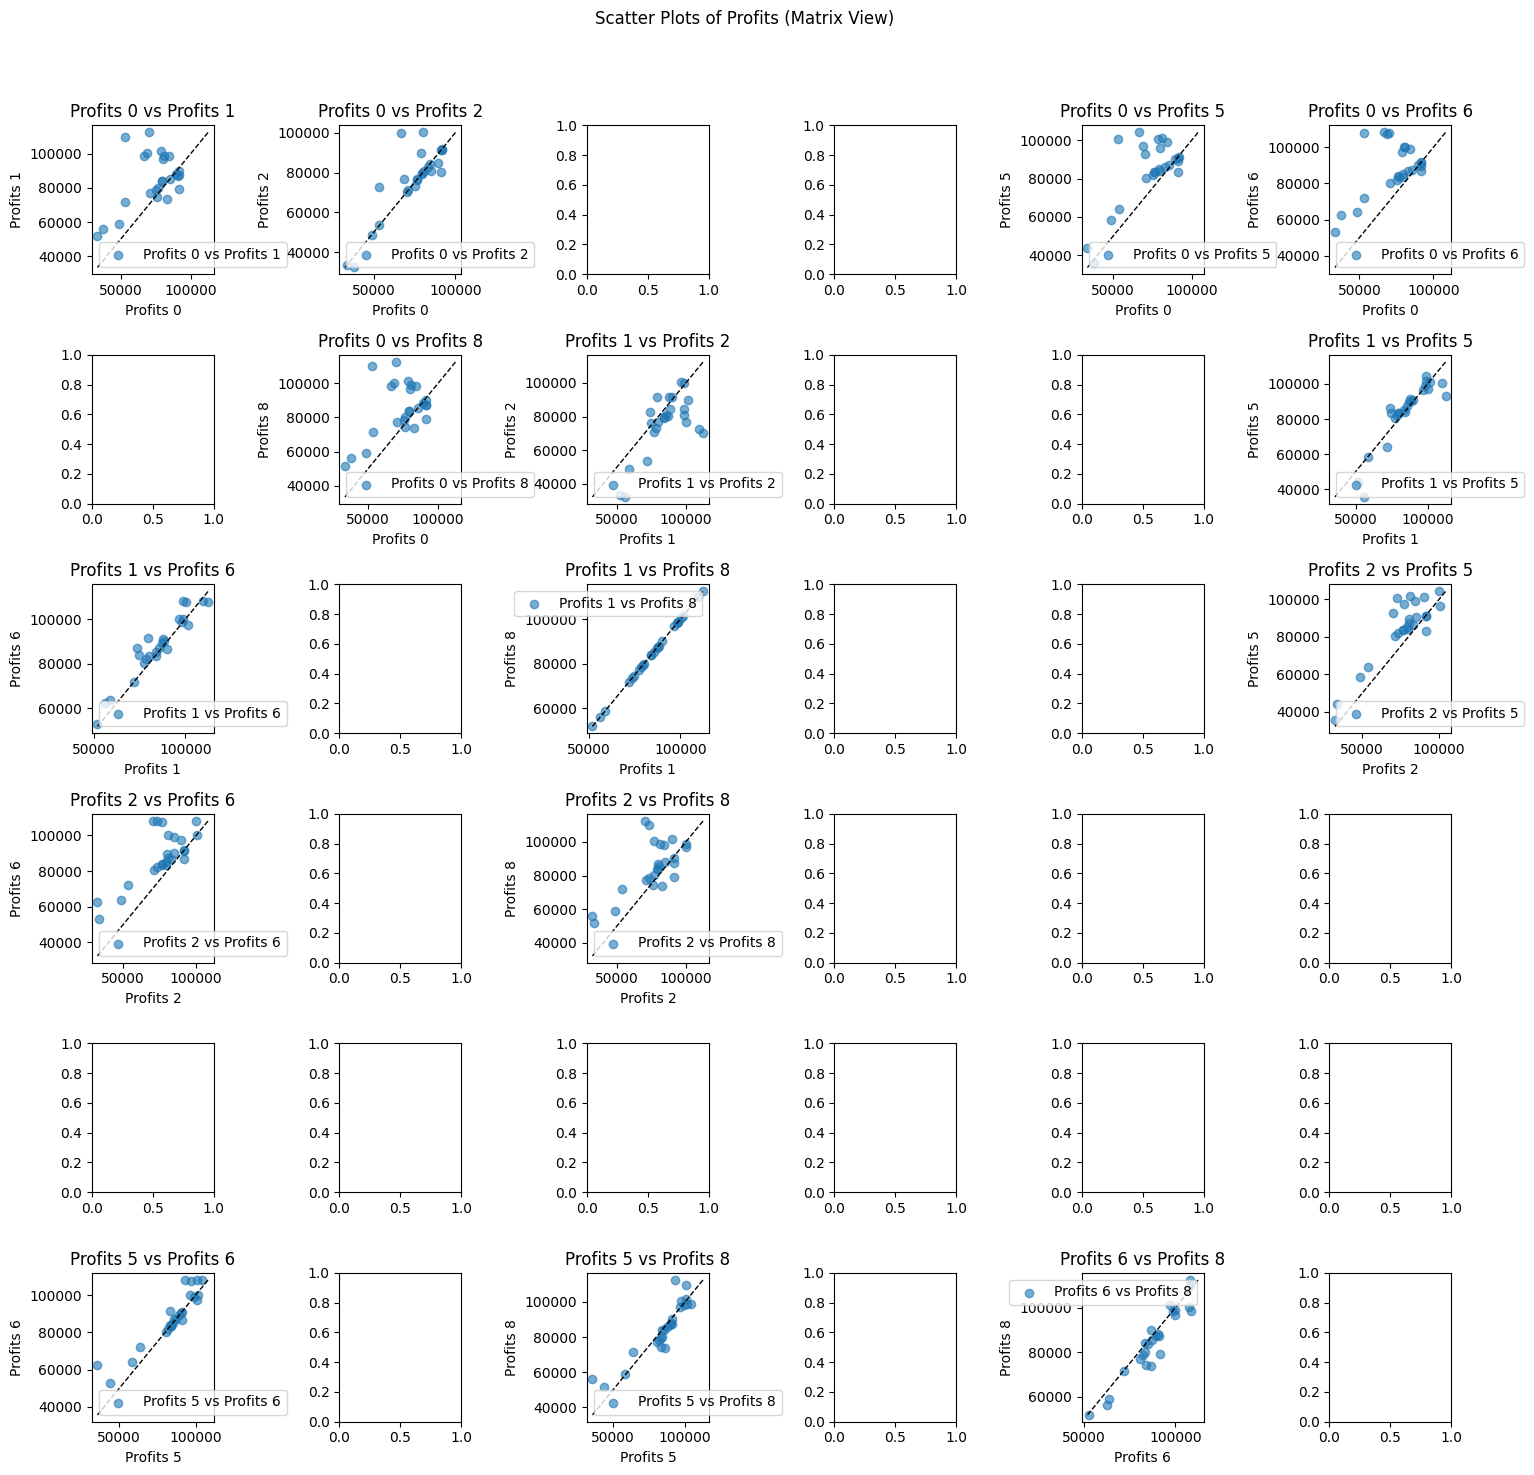

In [ ]:
dfs = [
    baseline_stimulation_df,
    stimulation_results_df_1,
    stimulation_results_df_2,
    stimulation_results_df_3,
    stimulation_results_df_4,
    stimulation_results_df_5,
    stimulation_results_df_6,
    stimulation_results_df_7,
    stimulation_results_df_8,
]
plot_strategies_profits_scatter(save_type=f"{status}_{model_prefix}", dfs=dfs)

##### 二次補貨量

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_50_S1_202411271120.png


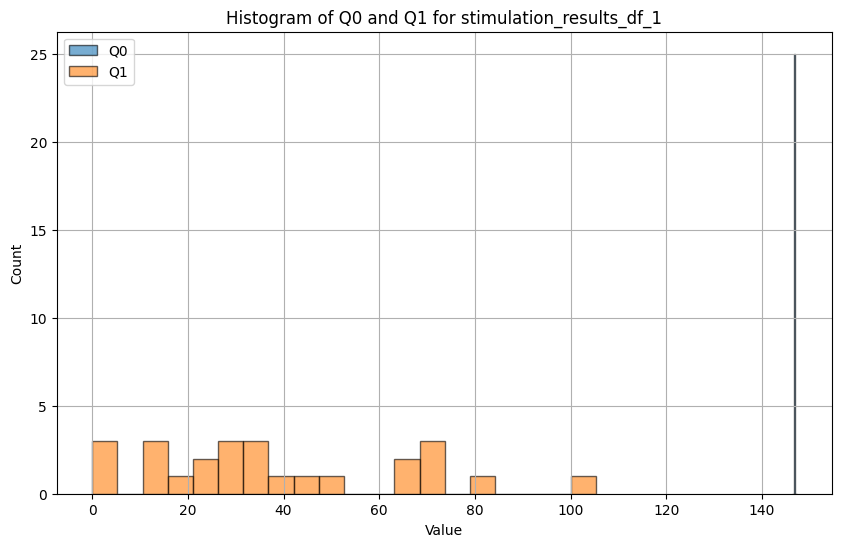

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_50_S2_202411271120.png


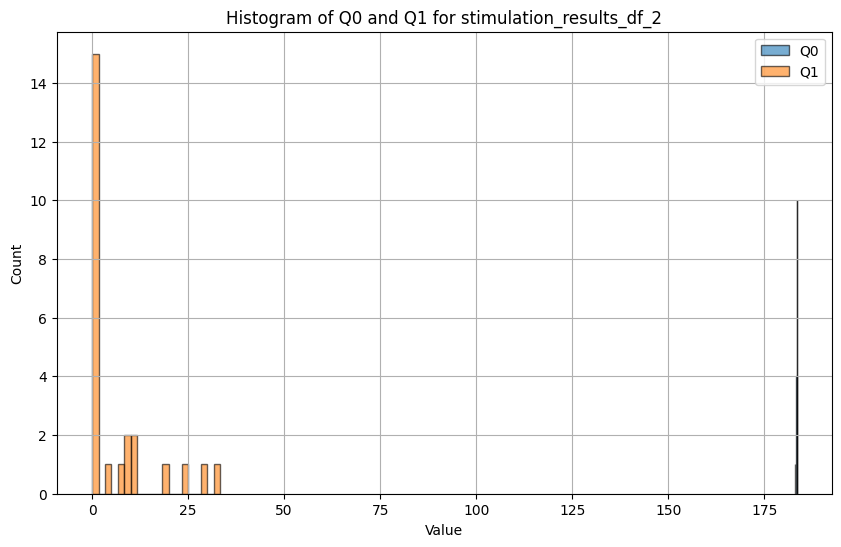

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_50_S5_202411271120.png


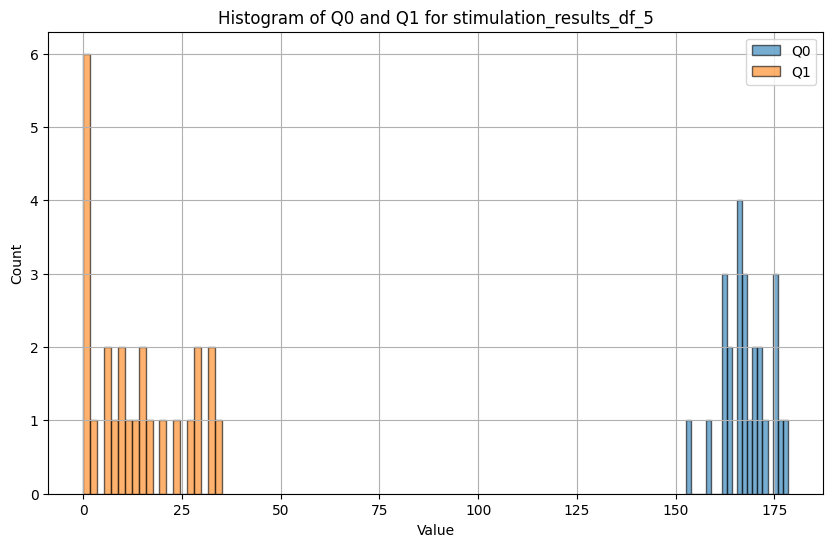

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_50_S6_202411271120.png


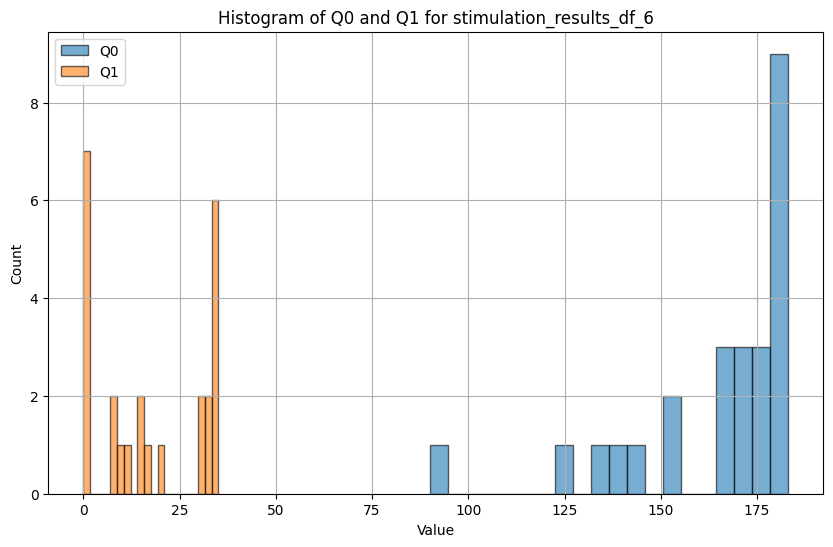

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_50_S8_202411271120.png


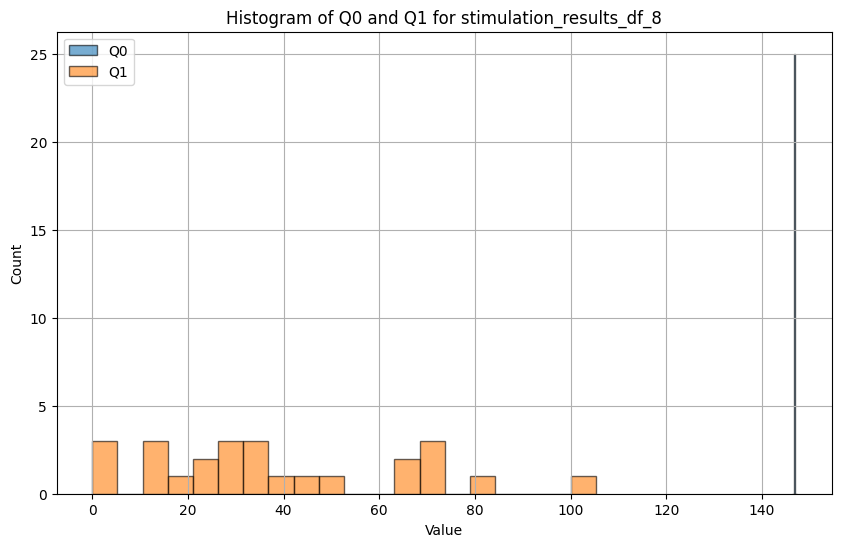

In [ ]:
plot_Q0_Q1_distribution(f"{status}_{model_prefix}", dfs[1:])

##### 每一個 profits 對 Baseline 的 Deviation

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_50_S1_202411271120.png


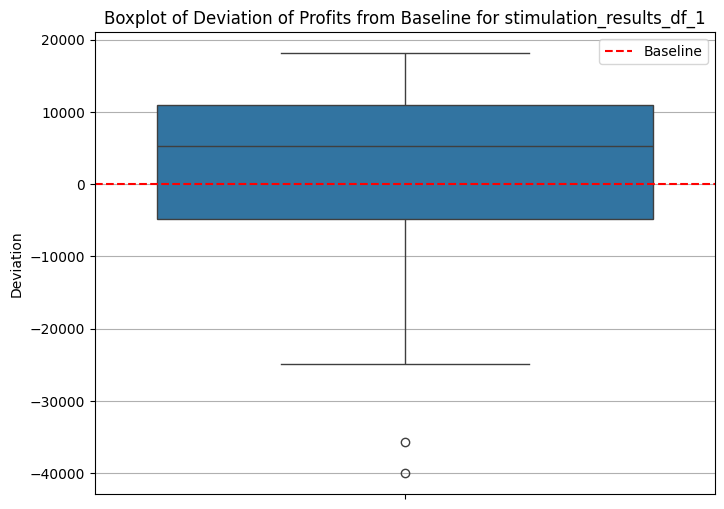

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_50_S2_202411271120.png


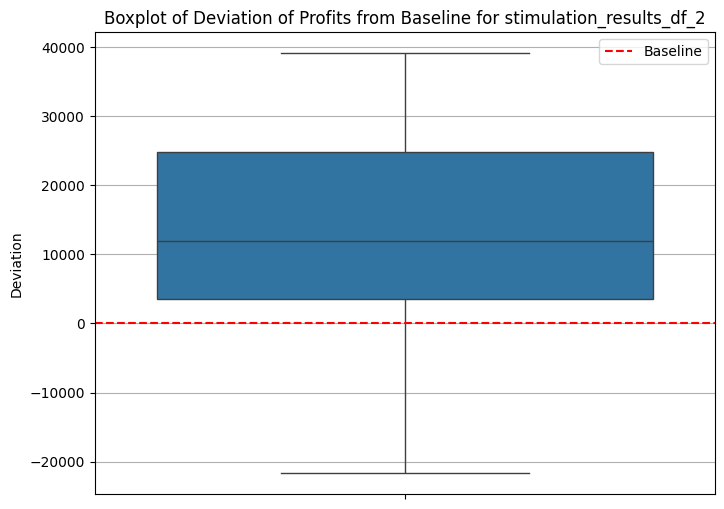

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_50_S3_202411271120.png


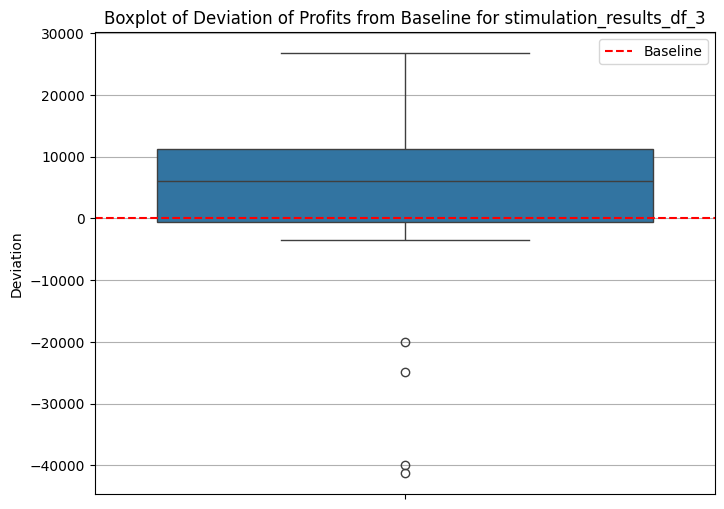

Skipping stimulation_results_df_4: Missing 'profits' column.
Skipping stimulation_results_df_5: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_50_S6_202411271120.png


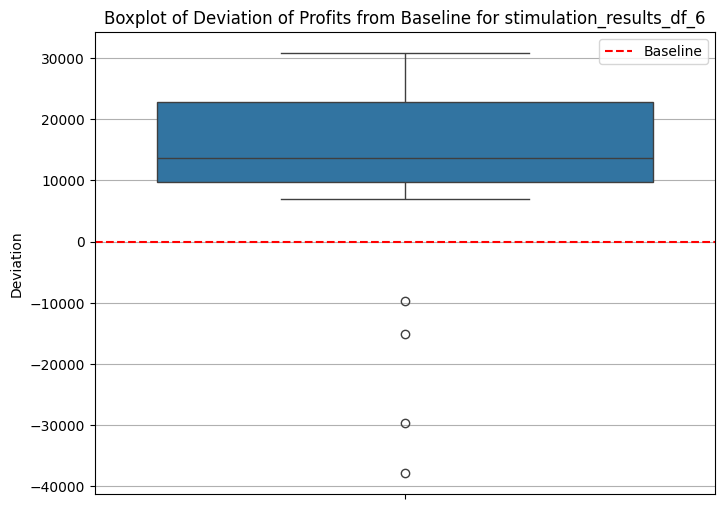

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_50_S7_202411271120.png


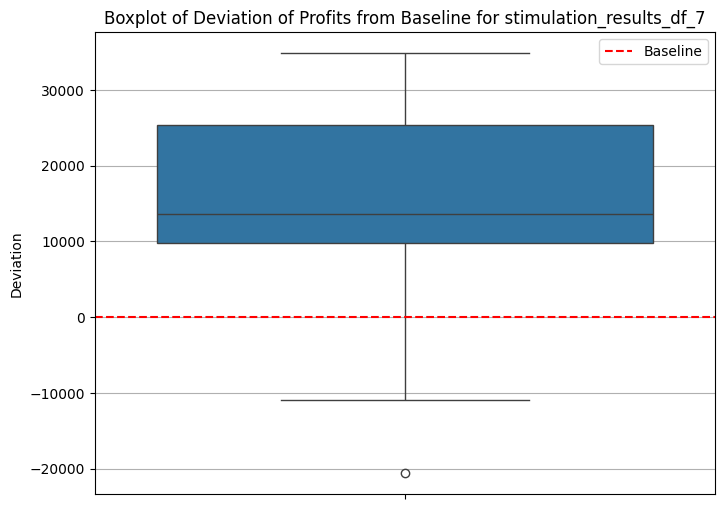

Skipping stimulation_results_df_8: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_50_S9_202411271120.png


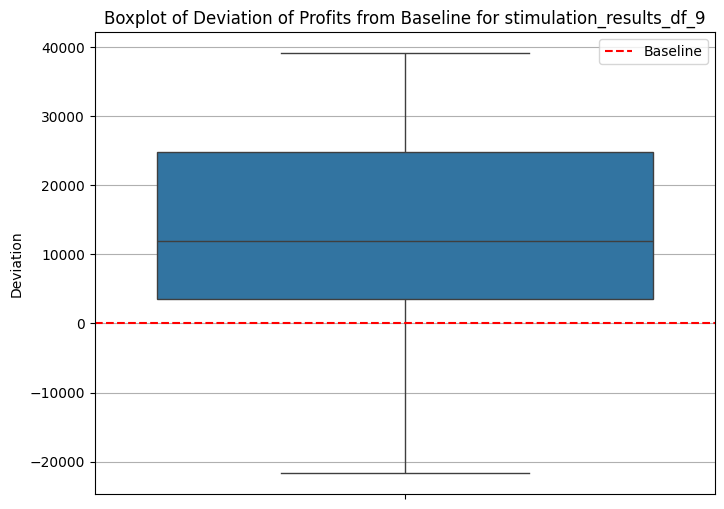

In [ ]:
plot_profits_deviation_box_plot(
    f"{status}_{model_prefix}",
    dfs,
    baseline_avg_profits,
)

##### 最大利潤比較


Baseline is: 73529.98026791944
S1's profit: 85019.36311632706
S2's profit: 76095.9943320627
S3's profit: -1
S4's profit: -1
S5's profit: 84486.39824979653
S6's profit: 88084.66183476675
S7's profit: -1
S8's profit: 85019.36311632706
Plot saved as plots/plot_relative_profit_deviation_train_linear_constraint_med_with_holding_cost_0_50_202411271120.png


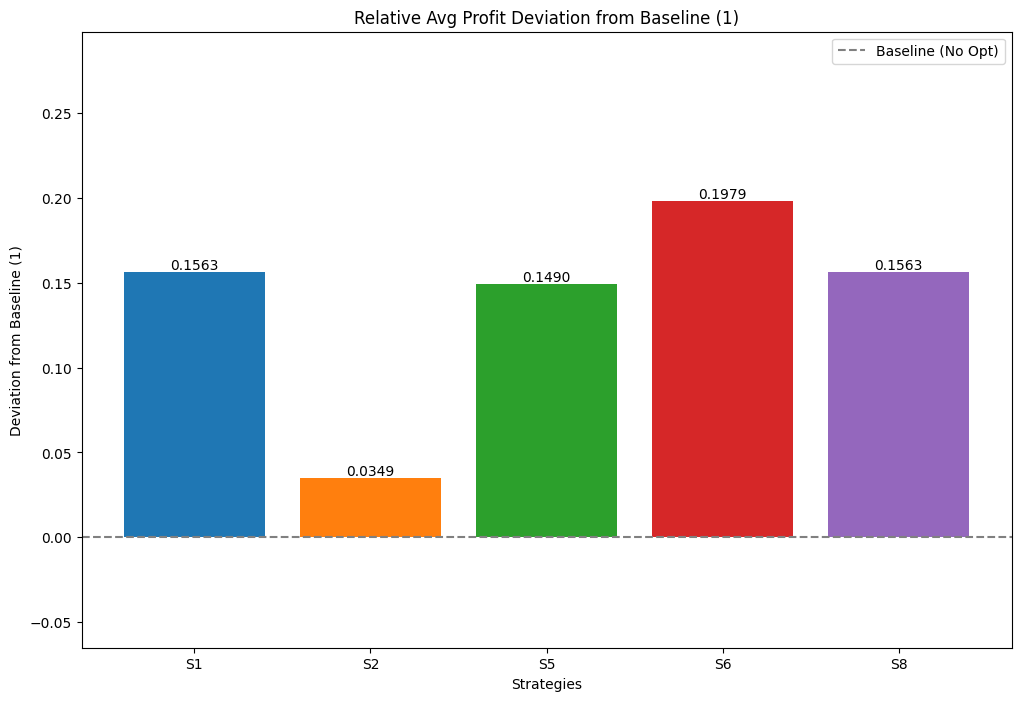

In [ ]:
train_max_profits = [
    max_profit_for_s1,
    max_profit_for_s2,
    max_profit_for_s3,
    max_profit_for_s4,
    max_profit_for_s5,
    max_profit_for_s6,
    max_profit_for_s7,
    max_profit_for_s8,
]

plot_relative_profit_deviation(
    f"{status}_{model_prefix}", float(baseline_avg_profits), train_max_profits
)

#### Preparation


In [ ]:
# overview
low_results_df_1 = results_df_1
low_results_df_2 = results_df_2
low_results_df_3 = results_df_3
low_results_df_4 = results_df_4
low_results_df_5 = results_df_5
low_results_df_6 = results_df_6
low_results_df_7 = results_df_7
low_results_df_8 = results_df_8

# max stimulation result
low_stimulation_results_df_1 = stimulation_results_df_1
low_stimulation_results_df_2 = stimulation_results_df_2
low_stimulation_results_df_3 = stimulation_results_df_3
low_stimulation_results_df_4 = stimulation_results_df_4
low_stimulation_results_df_5 = stimulation_results_df_5
low_stimulation_results_df_6 = stimulation_results_df_6
low_stimulation_results_df_7 = stimulation_results_df_7
low_stimulation_results_df_8 = stimulation_results_df_8

# max value
low_baseline_profit = baseline_avg_profits
low_max_profit_for_s1 = max_profit_for_s1
low_max_profit_for_s2 = max_profit_for_s2
low_max_profit_for_s3 = max_profit_for_s3
low_max_profit_for_s4 = max_profit_for_s4
low_max_profit_for_s5 = max_profit_for_s5
low_max_profit_for_s6 = max_profit_for_s6
low_max_profit_for_s7 = max_profit_for_s7
low_max_profit_for_s8 = max_profit_for_s8

## Testing


### Setting reasonable parameters


In [ ]:
status = "test"

In [ ]:
# Q star have to from demand_df_train
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 183.43244117652688
std of sum: 32.60474204393857
50.0 percentile of sum: 183.43244117652688
Q_star: 183.43244117652688


In [ ]:
# compute Qk_hat_test with demand_df_test
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_test)
Qk_hat_df_test = make_Qk_hat_df(
    demand_df_test, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_test = Qk_hat_df_test.reset_index(drop=True)

print(f"Qk_hat_df_test shape: {Qk_hat_df_test.shape}")
Qk_hat_df_test.head()

Qk_hat_df_test shape: (25, 8)


Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0  169.072995  136.148682  125.861487  133.300718  137.979475  136.612661   
1  162.980696  105.077619  111.555270  106.990058  131.718054  134.530577   
2  152.873644  114.486885  116.612991  120.702309  119.599463  123.797670   
3  186.246860  177.038624  175.122285  167.996632  155.760030  154.900674   
4  202.798165  216.495403  217.817645  223.716370  246.583159  241.521757   

    Qk_hat_k8   Qk_hat_k9  
0  152.339648  139.773218  
1  134.437351  124.493367  
2  122.507036  115.033357  
3  160.107489  164.398347  
4  242.260713  240.426446

### Run all the strategies


Baseline

In [ ]:
(
    test_baseline_avg_loss,
    test_baseline_avg_lefts,
    test_baseline_avg_profits,
    test_baseline_avg_operation_profits,
    test_stimulation_df_baseline,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_test,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    holding_cost=holding_cost,
)

print(f"baseline_profit: {test_baseline_avg_profits}")

Processing row 1/25 with initial inventory Q_star=183.43244117652688
--------------------------------------------------
Day 1
Demand      : 16.963838605923492
Sales       : 16.963838605923492
Loss        : 0
Left        : 166.4686025706034
Inventory   : 166.4686025706034
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 9.440522928705622
Sales       : 9.440522928705622
Loss        : 0
Left        : 157.02807964189776
Inventory   : 157.02807964189776
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 20.591840752682202
Sales       : 20.591840752682202
Loss        : 0
Left        : 136.43623888921556
Inventory   : 136.43623888921556
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 13.153947306704323
Sales       : 13.153947

In [ ]:
test_stimulation_df_baseline.head()

losses      lefts  operation_profits       profits
0   0.000000  54.574974       64428.733358  37141.246128
1   0.000000  65.125608       59153.416506  26590.612424
2   0.000000  52.125300       65653.570754  39590.920920
3   0.000000  12.691001       85370.720289  79025.219990
4  63.407295   0.000000       91716.220588  60012.573012

S1

In [ ]:
test_results_df_1, test_stimulation_results_df_1 = None, None

if results_df_1 is not None:
    assigned_T = results_df_1.iloc[0]["R(T)"]
    assigned_F = results_df_1.iloc[0]["F"]

    test_results_df_1, test_stimulation_results_df_1 = cal_test_fixed_F_fixed_R(
        assigned_T=int(assigned_T),
        assigned_F=assigned_F,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
    )

test_results_df_1





這是第 1 筆模擬資料

F: 0.8, R: 7
Q_star 為 183.43244117652688
期初庫存 Q0: 146.7459529412215
重新估計量 Qk_hat: 136.61266129915705
訂貨量 Q1 為 0

第一階段：期初庫存 Q0: 146.7459529412215，需求量為 91.47453838238212，Sold_0 為 91.47453838238212，Left_0 為 55.27141455883938，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 55.27141455883938，需求量為 37.38292833377789，Sold_1 為 37.38292833377789，Left_1 為 17.88848622506149，Lost_1 為 0

統計結果：Sold 為 128.85746671616002, Lost 為 0 Left_Penalty_Cost 為 8944.243112530747，Lost_Penalty_Cost 為 0，Profit 為 55484.49024554926
----------------------------------------
這是第 2 筆模擬資料

F: 0.8, R: 7
Q_star 為 183.43244117652688
期初庫存 Q0: 146.7459529412215
重新估計量 Qk_hat: 134.53057732654534
訂貨量 Q1 為 0

第一階段：期初庫存 Q0: 146.7459529412215，需求量為 67.86671618155714，Sold_0 為 67.86671618155714，Left_0 為 78.87923675966437，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 78.87923675966437，需求量為 50.44011683058，Sold_1 為 50.44011683058，Left_1 為 28.439119929084363，Lost_1 為 0

統計結果：Sold 為 118.30683301213713, Lost 為 0 Left_Penalty_Cost 為 14219.55996454218，Los

R(T)    F                                                 Q0  \
0     7  0.8  [146.7459529412215, 146.7459529412215, 146.745...   

                                                  Q1  average_profits  \
0  [0, 0, 0, 8.154721547434974, 94.77580425657743...     74858.825145   

   average_losses  average_lefts  average_operation_profits  
0        4.397242      11.533399               82824.145683

S2

In [ ]:
test_results_df_2, test_stimulation_results_df_2 = None, None

if results_df_2 is not None and len(results_df_2) > 0:
    assigned_R = results_df_2.iloc[0]["R"]
    alphas = results_df_2.iloc[0]["alpha_values"]

    test_results_df_2, test_stimulation_results_df_2 = cal_test_flexible_F_fixed_R(
        assigned_R=assigned_R[0],
        alphas=alphas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
        holding_cost=holding_cost,
    )

test_results_df_2

assigned_R: 1


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_98732/3758896648.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_98732/3758896648.py:63: RuntimeWarning: overflow encountered in exp
  F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))


average_profits  average_loss  average_left  \
0     57569.861508           0.0           0.0   

                                        alpha_values  R(T)  
0  [275257.3453994372, 29965.432408967976, 515228...     3

S3

In [ ]:
# results_df_3.head()

In [ ]:
test_results_df_3, test_stimulation_results_df_3 = None, None

if results_df_3 is not None and len(results_df_3) > 0:
    assigned_F = results_df_3.iloc[0]["F_vars"]
    betas = results_df_3.iloc[0]["beta_values"]
    print(f"betas: {betas}")
    test_results_df_3, test_stimulation_results_df_3 = cal_test_fixed_F_flexible_R(
        assigned_F=assigned_F[0],
        betas=betas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
        holding_cost=holding_cost,
    )

test_results_df_3

In [ ]:
test_stimulation_results_df_3

S4

In [ ]:
test_results_df_4, test_stimulation_results_df_4 = None, None

if results_df_4 is not None:
    alphas = results_df_4.iloc[0]["alpha_values"]
    betas = results_df_4.iloc[0]["beta_values"]

    test_results_df_4, test_stimulation_results_df_4 = (
        cal_test_fully_flexible_beta_with_softmax_4(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
            holding_cost=holding_cost,
        )
    )

test_results_df_4

In [ ]:
# import numpy as np

# # Provided data
# betas = np.array(
#     [
#         [0.00000000e00, 0.00000000e00, -8.94906903e-02],
#         [-3.13562128e-02, 4.00627944e-03, -6.21189321e-02],
#         [3.97911689e-02, 1.78930917e-02, -4.96275009e-02],
#         [0.00000000e00, 0.00000000e00, 0.00000000e00],
#         [0.00000000e00, 0.00000000e00, 0.00000000e00],
#         [0.00000000e00, 0.00000000e00, 0.00000000e00],
#         [0.00000000e00, 0.00000000e00, 0.00000000e00],
#         [3.50517907e-05, 1.43159496e-03, -3.20821046e-03],
#     ]
# )
# X_data = np.array([1.4397189210284136, -0.794923445271338, 1])

# # Initialization
# features_num = len(X_data)
# tau_vars = np.zeros((1, len(betas)))  # Assuming one data point for simplicity
# exp_tau_vars = np.zeros_like(tau_vars)
# r_vars = np.zeros_like(tau_vars)
# R_vars = np.zeros_like(tau_vars)

# # Calculate tau_vars
# for k in range(len(betas)):
#     tau_vars[0, k] = sum(X_data[j] * betas[k, j] for j in range(features_num))

# # Step 2: Calculate the exponentials of -tau_vars
# exp_tau_vars[0] = np.exp(-tau_vars[0])

# # Step 3: Softmax normalization
# sum_exp_tau = np.sum(exp_tau_vars[0])  # Sum of exponentials for normalization
# r_vars[0] = exp_tau_vars[0] / sum_exp_tau  # Normalize to get softmax

# # Step 4: Find the index of the maximum r_var and set R_vars
# max_r_index = np.argmax(r_vars[0])
# R_vars[0, max_r_index] = 1

# print(f"tau_vars: {tau_vars}")
# print(f"exp_tau_vars: {exp_tau_vars}")
# print(f"r_vars: {r_vars}")
# print(f"R_vars: {R_vars}")

# # Print the final R matrix
# print("Final R matrix:")
# print(R_vars)

In [ ]:
test_stimulation_results_df_4

S5

In [ ]:
test_results_df_5, test_stimulation_results_df_5 = None, None

if results_df_5 is not None:
    alphas = results_df_5.iloc[0]["alpha_values"]
    betas = results_df_5.iloc[0]["beta_values"]

    test_results_df_5, test_stimulation_results_df_5 = (
        cal_test_fully_flexible_simple_beta_with_softmax_5(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
            holding_cost=holding_cost,
        )
    )

test_results_df_5

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_98732/2289234698.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0      60886.08988           0.0           0.0   

                                        alpha_values  \
0  [0.41167387725206595, 0.11960239950515202, 2.6...   

                                         beta_balues  
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....

In [ ]:
test_stimulation_results_df_5

F  R(T)     Sold_0      Left_0  Lost_0      Sold_1     Left_1  \
0   0.922900     2  16.963839  152.326001     0.0  111.893628  40.432373   
1   0.918046     2  12.220172  156.179158     0.0  106.086661  50.092497   
2   0.945460     2   4.350487  169.077500     0.0  126.956654  42.120846   
3   0.924348     2  30.335979  139.219471     0.0  140.405461  15.505420   
4   0.947817     2  43.223373  130.637016     0.0  159.574792   0.000000   
5   0.956012     2  19.574086  155.789499     0.0  155.789499   0.000000   
6   0.963298     2  19.854060  156.846028     0.0  156.846028   0.000000   
7   0.949383     2  17.163843  156.983846     0.0  156.983846   0.000000   
8   0.935278     2  20.484121  151.076156     0.0  153.109980   0.000000   
9   0.908084     2  12.949772  153.622208     0.0   94.102407  59.519801   
10  0.938288     2   4.598510  167.513864     0.0  167.513864   0.000000   
11  0.932222     2  15.977742  155.022064     0.0  155.022064   0.000000   
12  0.867294     2  15.448825  143.641120     0.0  114.631829  37.046607   
13  0.857943     2   4.275810  153.098811     0.0  139.722028  13.376783   
14  0.957487     2  10.511631  165.122564     0.0  165.122564   0.000000   
15  0.954808     2  16.129859  159.012816     0.0  159.012816   0.000000   
16  0.848991     2  24.362567  131.369905     0.0   82.748127  71.464502   
17  0.935294     2  25.945616  145.617690     0.0  142.455650  12.207043   
18  0.915110     2  17.335800  150.525137     0.0  152.214906   0.000000   
19  0.903663     2  23.025368  142.735673     0.0  153.832461   0.000000   
20  0.861048     2  13.607550  144.336570     0.0  115.301751  35.853207   
21  0.889331     2  20.681844  142.450395     0.0  133.790436  19.375757   
22  0.907338     2  13.964441  152.470757     0.0  152.470757   0.000000   
23  0.870649     2  27.902377  131.802831     0.0  117.074751  38.144253   
24  0.936573     2  12.139557  159.658257     0.0  126.286601  33.371656   

       Lost_1       profits          Q0         Q1         hc0         hc1  
0    0.000000  44212.546938  169.289840   0.000000  160.807920  771.033495  
1    0.000000  34107.167820  168.399330   0.000000  162.289244  825.086622  
2    0.000000  44593.147885  173.427987   0.000000  171.252744  844.793384  
3    0.000000  77618.010381  169.555450  16.691410  162.733166  685.665204  
4   44.041571  79378.296830  173.860390  28.937775  166.717591  638.299166  
5   48.742194  63310.695527  175.363585   0.000000  165.576542  623.157997  
6   24.637581  76031.253340  176.700088   0.000000  166.773058  627.384111  
7   10.571379  81788.155410  174.147689   0.000000  165.565768  627.935384  
8    1.417983  86088.058351  171.560276   2.033824  162.335128  612.439918  
9    0.000000  23766.188937  166.571980   0.000000  160.097094  852.568038  
10  40.194019  65959.178082  172.112375   0.000000  169.813120  670.055458  
11  37.752000  66623.903190  170.999806   0.000000  163.010935  620.088256  
12   0.000000  46517.023445  159.089944   8.037316  155.384190  754.900169  
13   0.000000  65310.527340  157.374621   0.000000  155.236716  665.902377  
14  56.926188  59354.004060  175.634196   0.000000  170.378380  660.490258  
15  64.200863  55470.905573  175.142674   0.000000  167.077745  636.051263  
16   0.000000  17823.096037  155.732472  22.842725  154.972551  902.708526  
17   0.000000  78097.111604  171.563306   9.045003  163.113000  667.478944  
18  12.796989  78376.858863  167.860937   1.689769  160.037922  608.859625  
19  23.334360  76761.734650  165.761041  11.096788  159.796751  615.329844  
20   0.000000  46528.046706  157.944120   6.818388  154.549539  748.032659  
21   0.000000  67548.261403  163.132239  10.715798  158.149216  690.167798  
22   4.546426  80944.385840  166.435198   0.000000  159.452977  609.883027  
23   0.000000  53416.437300  159.705208  23.416172  157.462106  773.453026  
24   0.000000  52527.251483  171.797814   0.000000  165.728036  772.119651

S6

In [ ]:
test_results_df_6, test_stimulation_results_df_6 = None, None

if results_df_6 is not None:
    alphas = results_df_6.iloc[0]["alpha_values"]
    betas = results_df_6.iloc[0]["beta_values"]

    test_results_df_6, test_stimulation_results_df_6 = (
        cal_test_fully_flexible_simple_beta_with_softmax_6(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
            holding_cost=holding_cost,
        )
    )

test_results_df_6

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_98732/492182808.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0      62472.21652           0.0           0.0   

                                        alpha_values  \
0  [1.370607238625958, 0.5677077414860987, 3.0790...   

                                         beta_balues  
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....

In [ ]:
test_stimulation_results_df_6

F  R(T)     Sold_0      Left_0  Lost_0      Sold_1     Left_1  \
0   0.929686     2  16.963839  153.570738     0.0  111.893628  41.677110   
1   0.904752     2  12.220172  153.740666     0.0  106.086661  47.654005   
2   0.976653     2   4.350487  174.799372     0.0  126.956654  47.842718   
3   0.946330     2  30.335979  143.251714     0.0  140.405461  15.505420   
4   0.987623     2  43.223373  137.938747     0.0  159.574792   0.000000   
5   0.988610     2  19.574086  161.769064     0.0  161.769064   0.000000   
6   0.995327     2  19.854060  162.721162     0.0  162.721162   0.000000   
7   0.984434     2  17.163843  163.413251     0.0  163.413251   0.000000   
8   0.973694     2  20.484121  158.122908     0.0  154.527963   3.594945   
9   0.868888     2  12.949772  146.432465     0.0   94.102407  56.865543   
10  0.973723     2   4.598510  174.013890     0.0  174.013890   0.000000   
11  0.953744     2  15.977742  158.969793     0.0  158.969793   0.000000   
12  0.636257     2  15.448825  101.261283     0.0  114.631829  37.046607   
13  0.613999     2   4.275810  108.351577     0.0  139.722028   8.779898   
14  0.993351     2  10.511631  171.701227     0.0  171.701227   0.000000   
15  0.988435     2  16.129859  165.181187     0.0  165.181187   0.000000   
16  0.501744     2  24.362567   67.673605     0.0   82.748127  71.464502   
17  0.958631     2  25.945616  149.898414     0.0  142.455650  12.207043   
18  0.927455     2  17.335800  152.789547     0.0  152.789547   0.000000   
19  0.840936     2  23.025368  131.229590     0.0  153.832461   0.000000   
20  0.606530     2  13.607550   97.649771     0.0  115.301751  35.853207   
21  0.780413     2  20.681844  122.471292     0.0  133.790436  19.375757   
22  0.855196     2  13.964441  142.906255     0.0  151.256423   0.000000   
23  0.726206     2  27.902377  105.307356     0.0  117.074751  38.144253   
24  0.960211     2  12.139557  163.994371     0.0  126.286601  37.707769   

       Lost_1       profits          Q0         Q1         hc0         hc1  
0    0.000000  43590.178329  170.534577   0.000000  162.052657  780.991393  
1    0.000000  35326.414042  165.960838   0.000000  159.850752  805.578683  
2    0.000000  41732.211816  179.149859   0.000000  176.974616  890.568361  
3    0.000000  77618.010381  173.587693  12.659167  164.749287  685.665204  
4   44.041571  79378.296830  181.162120  21.636045  170.368456  638.299166  
5   42.762630  69290.259926  181.343150   0.000000  171.556107  647.076255  
6   18.762447  81906.387313  182.575222   0.000000  172.648192  650.884647  
7    4.141974  88217.560374  180.577094   0.000000  171.995173  653.653004  
8    0.000000  85708.569540  178.607028   0.000000  168.364968  646.871408  
9    0.000000  25093.317970  159.382237   4.535486  155.175094  831.333974  
10  33.693993  72459.203685  178.612400   0.000000  176.313145  696.055560  
11  33.804271  70571.631765  174.947535   0.000000  166.958664  635.879171  
12   0.000000  46517.023445  116.710108  50.417153  134.194272  754.900169  
13   0.000000  67608.969687  112.627386  40.150350  130.564656  629.127300  
14  50.347525  65932.666981  182.212859   0.000000  176.957043  686.804910  
15  58.032492  61639.277221  181.311046   0.000000  173.246117  660.724750  
16   0.000000  17823.096037   92.036172  86.539024  123.124401  902.708526  
17   0.000000  78097.111604  175.844030   4.764279  165.253362  667.478944  
18  12.222348  78951.499683  170.125347   0.000000  161.457447  611.158188  
19  23.334360  76761.734650  154.254958  22.602871  154.043709  615.329844  
20   0.000000  46528.046706  111.257321  53.505187  131.206139  748.032659  
21   0.000000  67548.261403  143.153135  30.694901  148.159664  690.167798  
22   5.760761  79730.051646  156.870697   8.350167  154.063560  605.025690  
23   0.000000  53416.437300  133.209733  49.911647  144.214368  773.453026  
24   0.000000  50359.194663  176.133928   0.000000  170.064149  806.808560

S7

In [ ]:
test_results_df_7, test_stimulation_results_df_7 = None, None

if results_df_7 is not None:
    alphas = results_df_7.iloc[0]["alpha_values"]
    betas = results_df_7.iloc[0]["beta_values"]

    print(f"alphas: {alphas}")
    print(f"betas: {betas}")

    test_results_df_7, test_stimulation_results_df_7 = (
        cal_test_fully_flexible_simple_beta_with_softmax_7(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
            holding_cost=holding_cost,
        )
    )

test_results_df_7

S8

In [ ]:
test_results_df_8, test_stimulation_results_df_8 = None, None

if results_df_8 is not None:
    assigned_T = results_df_8.iloc[0]["R(T)"]
    assigned_F = results_df_8.iloc[0]["F"]

    test_results_df_8, test_stimulation_results_df_8 = (
        cal_test_fixed_F_fixed_R_with_holding_cost(
            assigned_T=int(assigned_T),
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            holding_cost=holding_cost,
        )
    )

test_results_df_8

R(T)    F                                                 Q0  \
0     7  0.8  [146.7459529412215, 146.7459529412215, 146.745...   

                                                  Q1  average_profits  \
0  [0, 0, 0, 8.154721547434974, 94.77580425657743...     74858.825145   

   average_losses  average_lefts  average_operation_profits  
0        4.397242      11.533399               82824.145683

### Analysis

#### 組內比較

##### Profits Scatter

Plot saved as plots/plot_strategies_profits_scatter_test_linear_constraint_med_with_holding_cost_0_50_202411271120.png


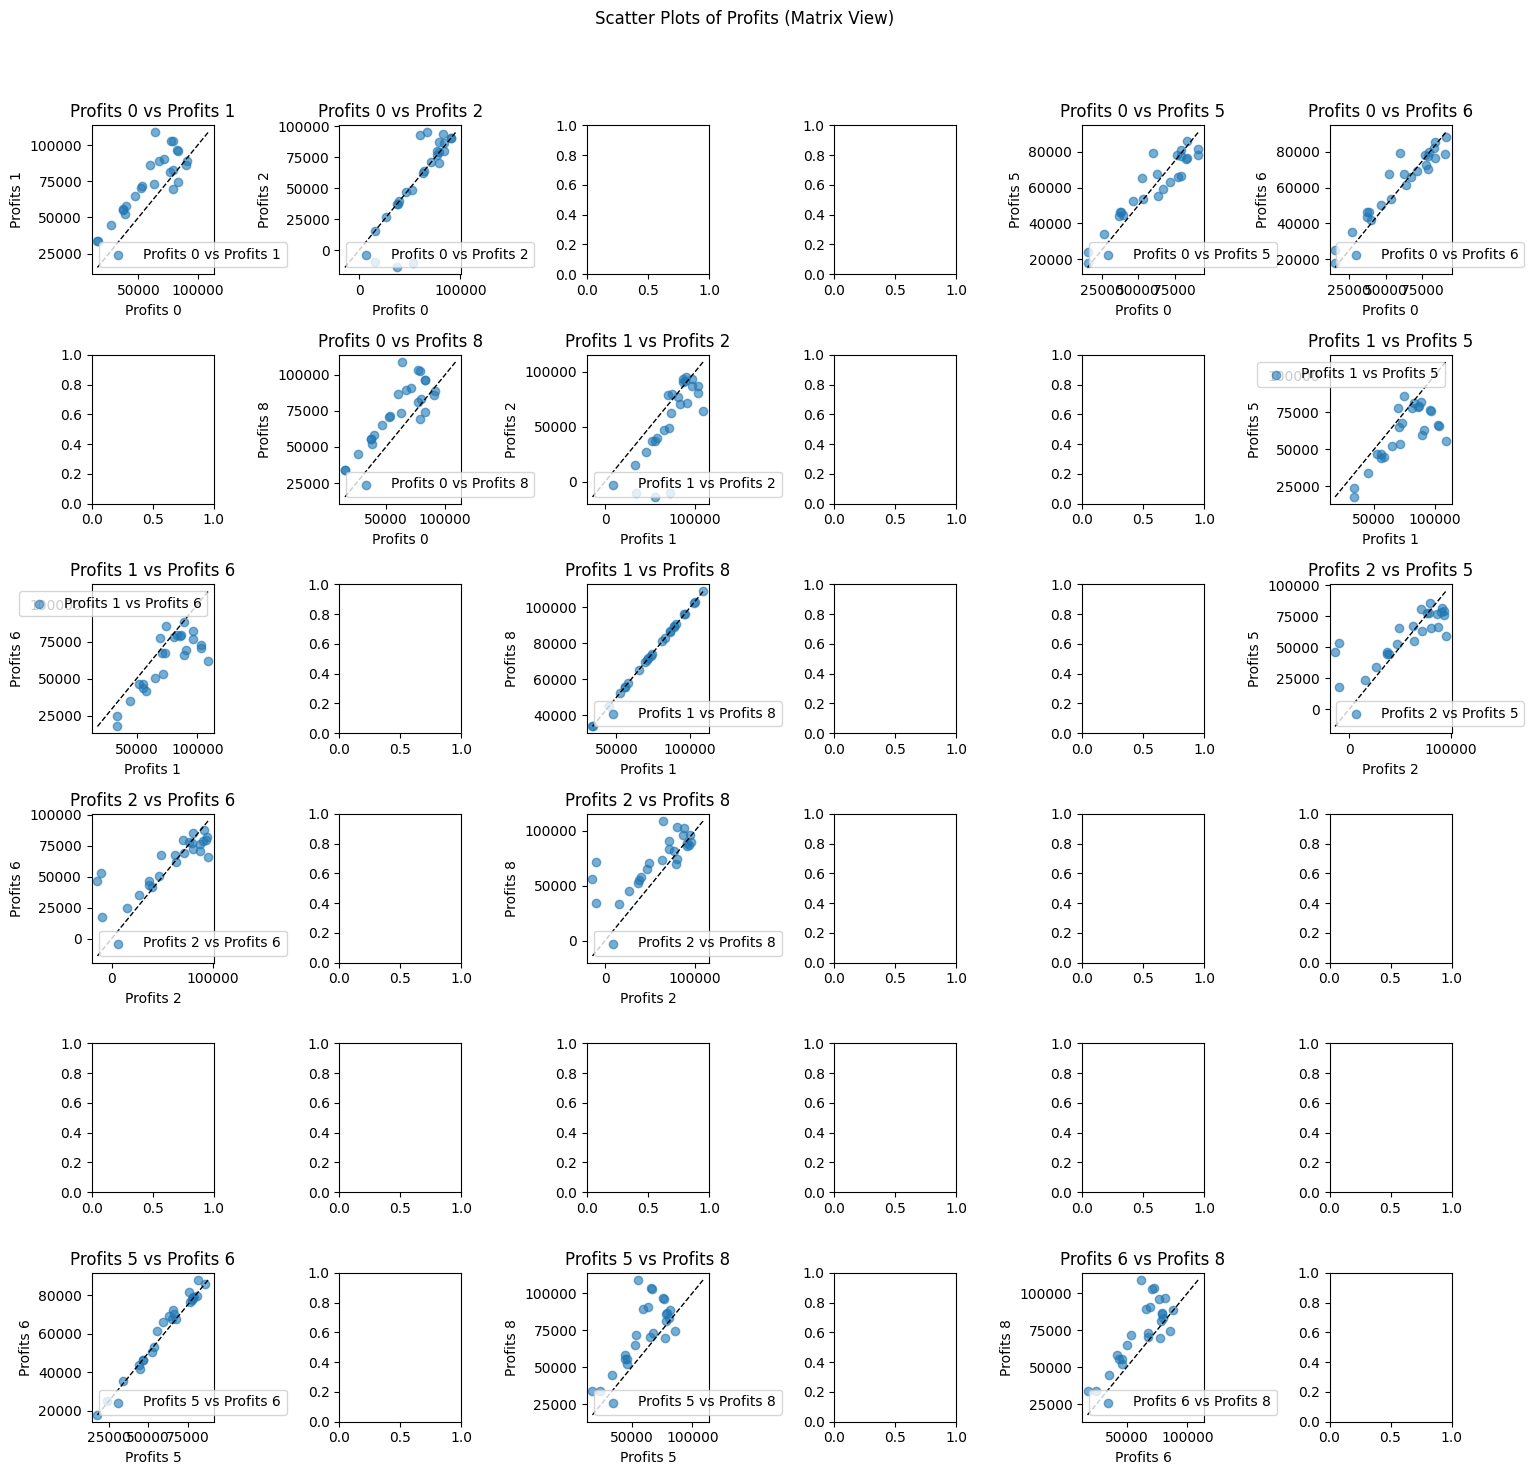

In [ ]:
dfs = [
    test_stimulation_df_baseline,
    test_stimulation_results_df_1,
    test_stimulation_results_df_2,
    test_stimulation_results_df_3,
    test_stimulation_results_df_4,
    test_stimulation_results_df_5,
    test_stimulation_results_df_6,
    test_stimulation_results_df_7,
    test_stimulation_results_df_8,
]

plot_strategies_profits_scatter(f"{status}_{model_prefix}", dfs)

##### Profit Deviation

Baseline is: 60373.43767370916
S1's profit: 74858.82514525519
S2's profit: 57569.86150773253
S3's profit: -1
S4's profit: -1
S5's profit: 60886.089879725216
S6's profit: 62472.21651984764
S7's profit: -1
S8's profit: 74858.82514525519
Plot saved as plots/plot_relative_profit_deviation_test_linear_constraint_med_with_holding_cost_0_50_202411271120.png


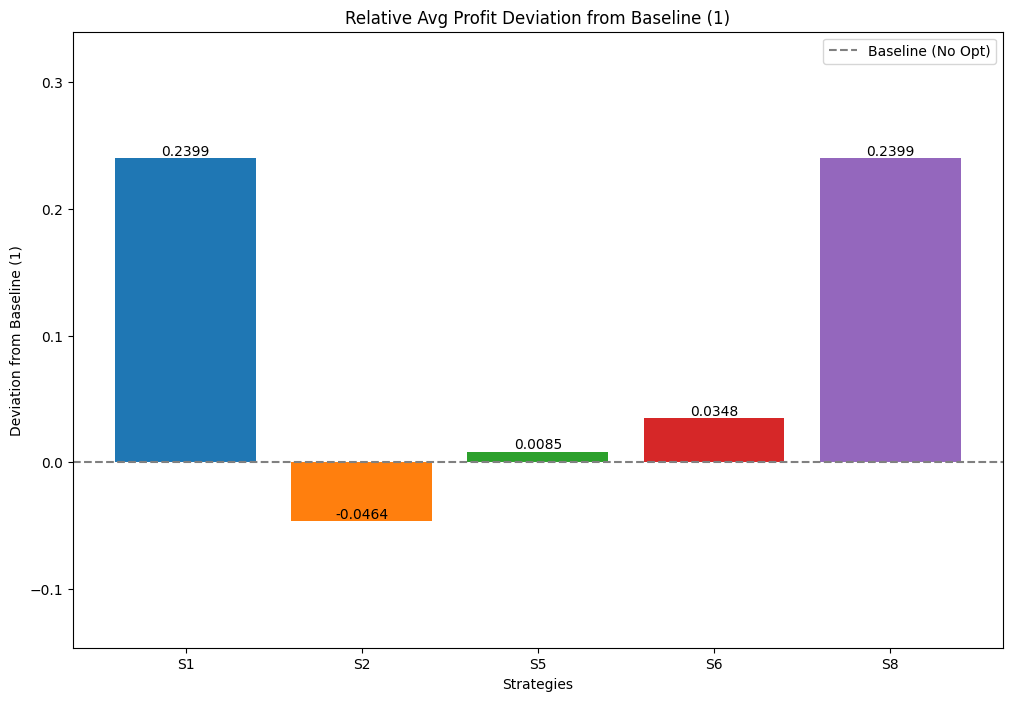

In [ ]:
test_max_profits = [
    (
        test_results_df_1.iloc[0]["average_profits"]
        if test_results_df_1 is not None
        else -1
    ),
    (
        test_results_df_2.iloc[0]["average_profits"]
        if test_results_df_2 is not None
        else -1
    ),
    (
        test_results_df_3.iloc[0]["average_profits"]
        if test_results_df_3 is not None
        else -1
    ),
    (
        test_results_df_4.iloc[0]["average_profits"]
        if test_results_df_4 is not None
        else -1
    ),
    (
        test_results_df_5.iloc[0]["average_profits"]
        if test_results_df_5 is not None
        else -1
    ),
    (
        test_results_df_6.iloc[0]["average_profits"]
        if test_results_df_6 is not None
        else -1
    ),
    (
        test_results_df_7.iloc[0]["average_profits"]
        if test_results_df_7 is not None
        else -1
    ),
    (
        test_results_df_8.iloc[0]["average_profits"]
        if test_results_df_8 is not None
        else -1
    ),
]
plot_relative_profit_deviation(
    f"{status}_{model_prefix}", test_baseline_avg_profits, test_max_profits
)

##### 二次補貨量

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_50_S1_202411271120.png


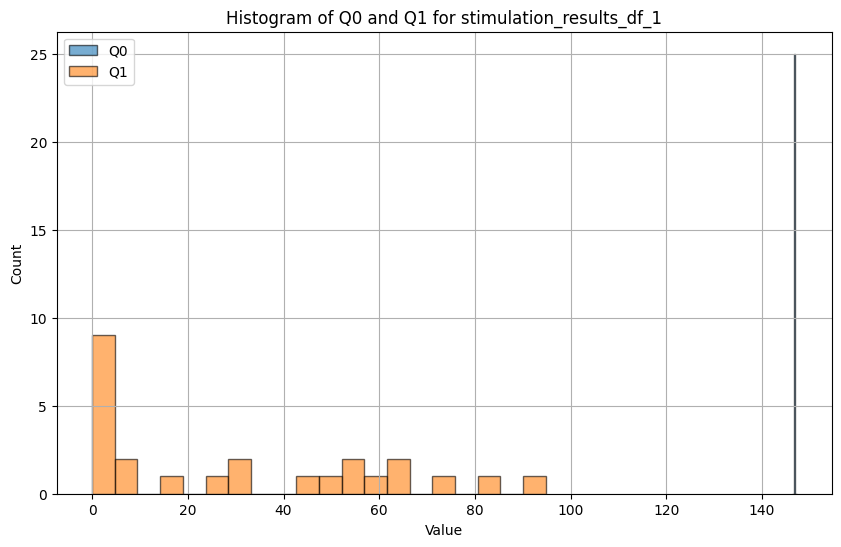

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_50_S2_202411271120.png


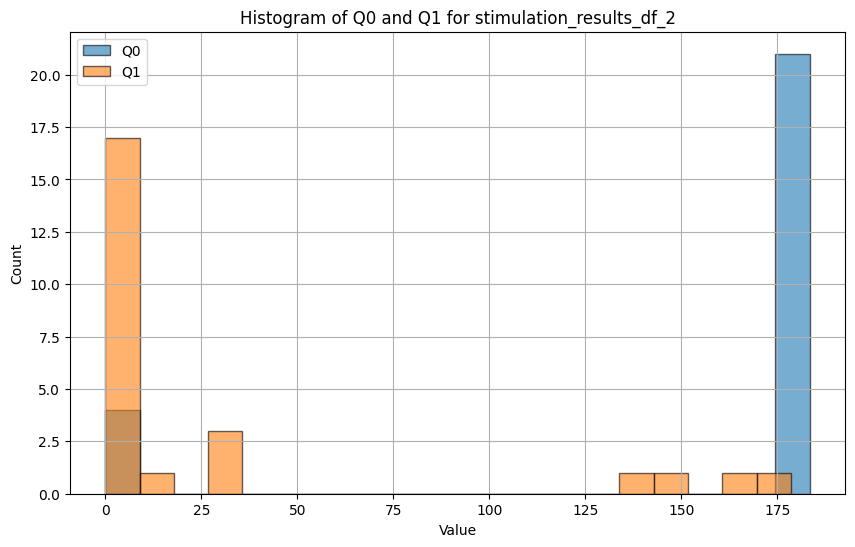

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_50_S5_202411271120.png


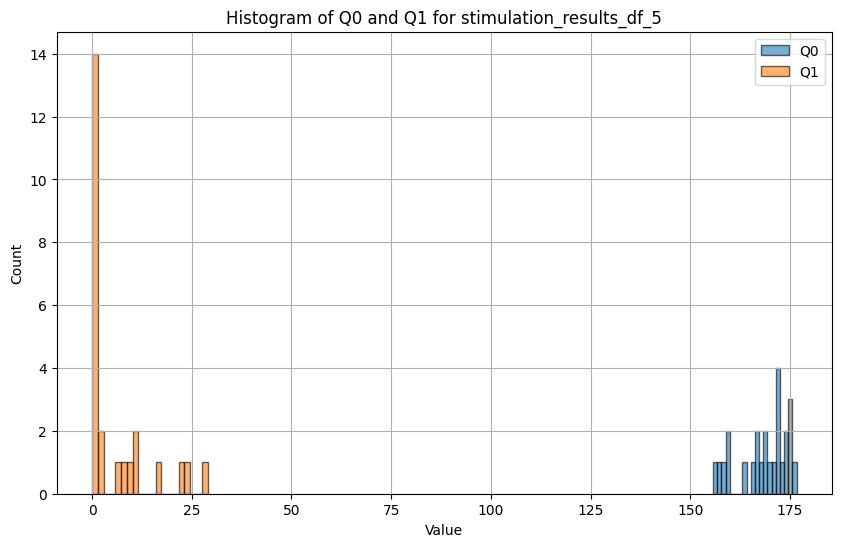

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_50_S6_202411271120.png


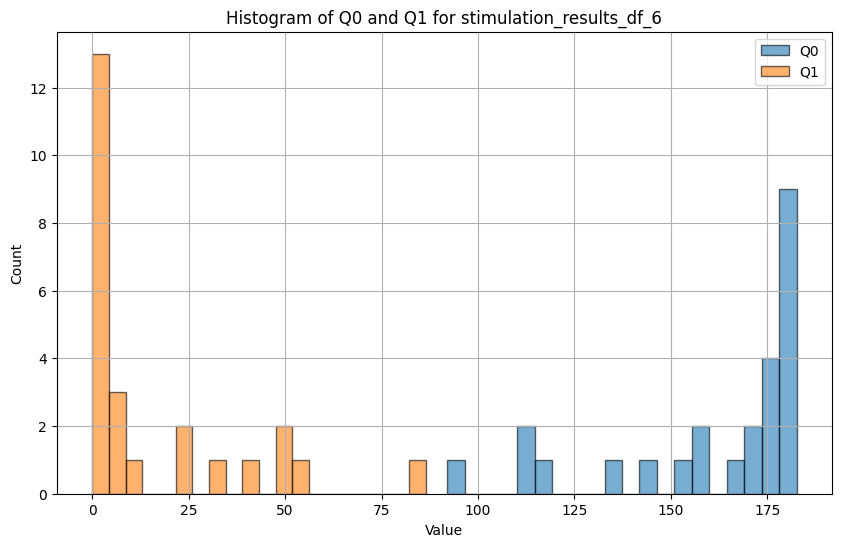

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_50_S8_202411271120.png


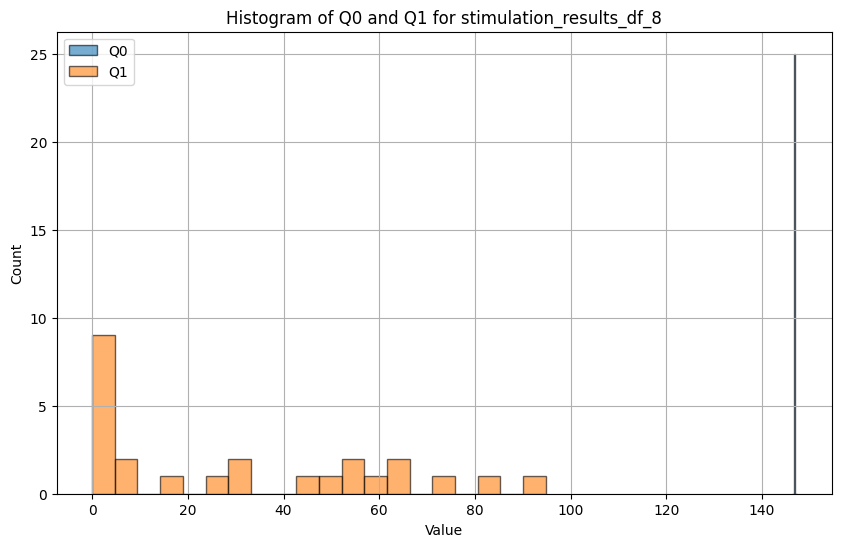

In [ ]:
plot_Q0_Q1_distribution(f"{status}_{model_prefix}", dfs[1:])

##### 每一個 profits 對 Baseline 的 Deviation

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_50_S1_202411271120.png


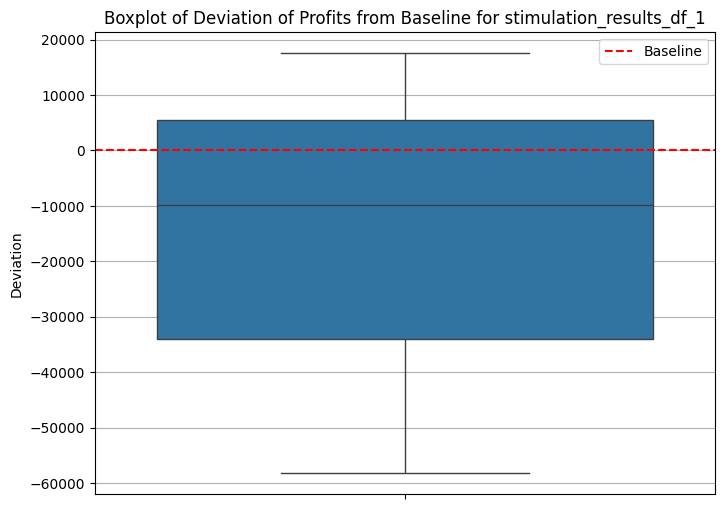

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_50_S2_202411271120.png


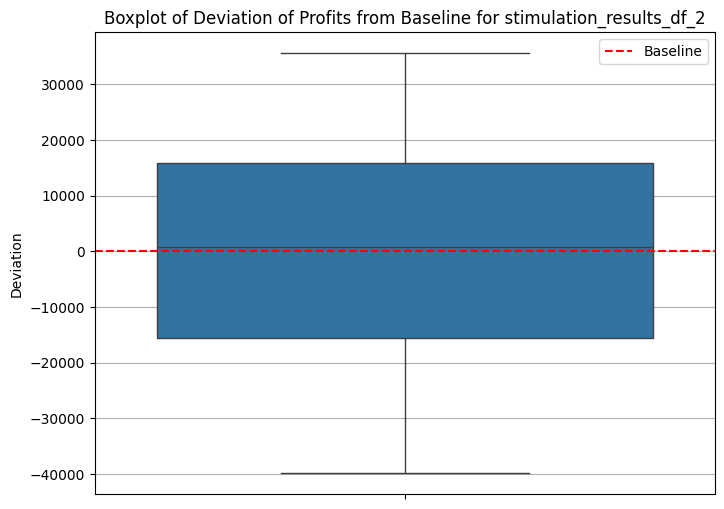

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_50_S3_202411271120.png


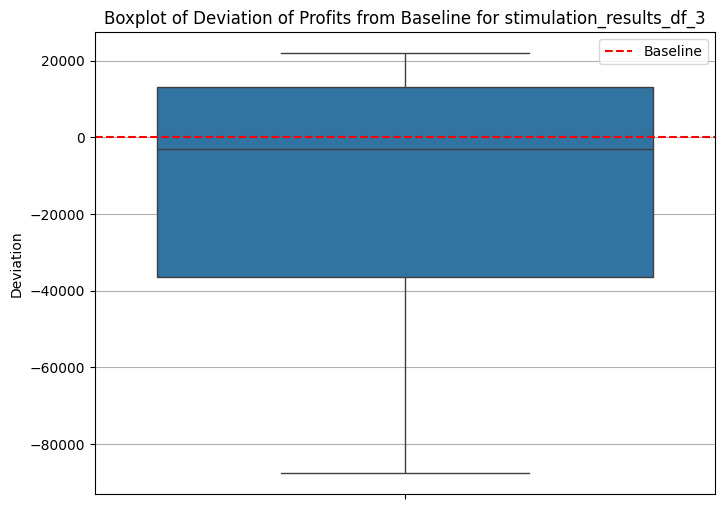

Skipping stimulation_results_df_4: Missing 'profits' column.
Skipping stimulation_results_df_5: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_50_S6_202411271120.png


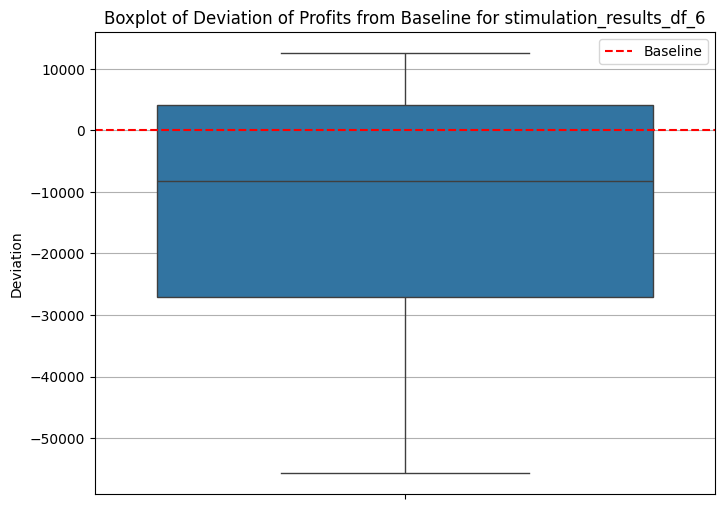

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_50_S7_202411271120.png


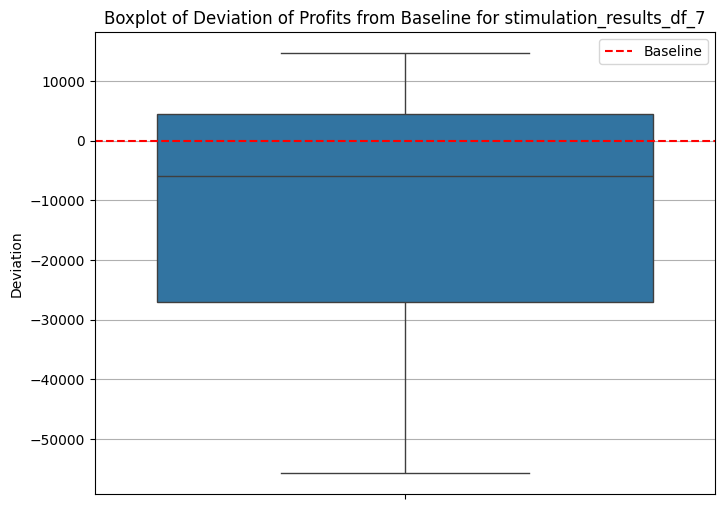

Skipping stimulation_results_df_8: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_50_S9_202411271120.png


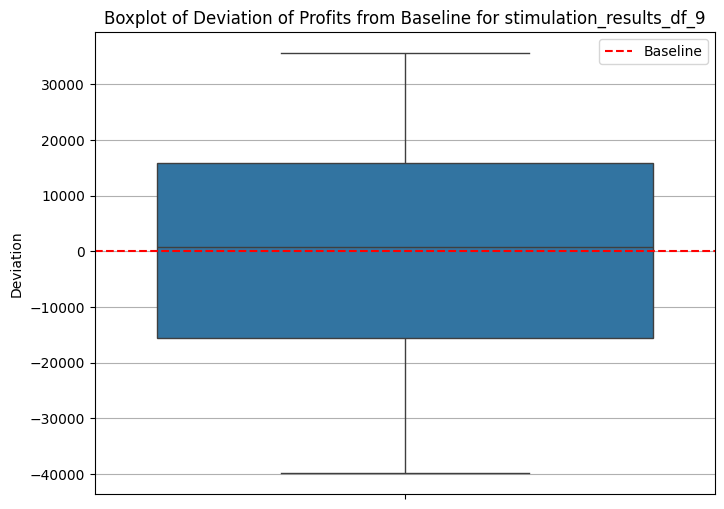

In [ ]:
plot_profits_deviation_box_plot(f"{status}_{model_prefix}", dfs, baseline_avg_profits)

#### 訓練 vs. 測試

與各自的 Baseline 相比

Plot saved as plots/plot_relative_profit_comparison_test_linear_constraint_med_with_holding_cost_0_50_202411271120.png


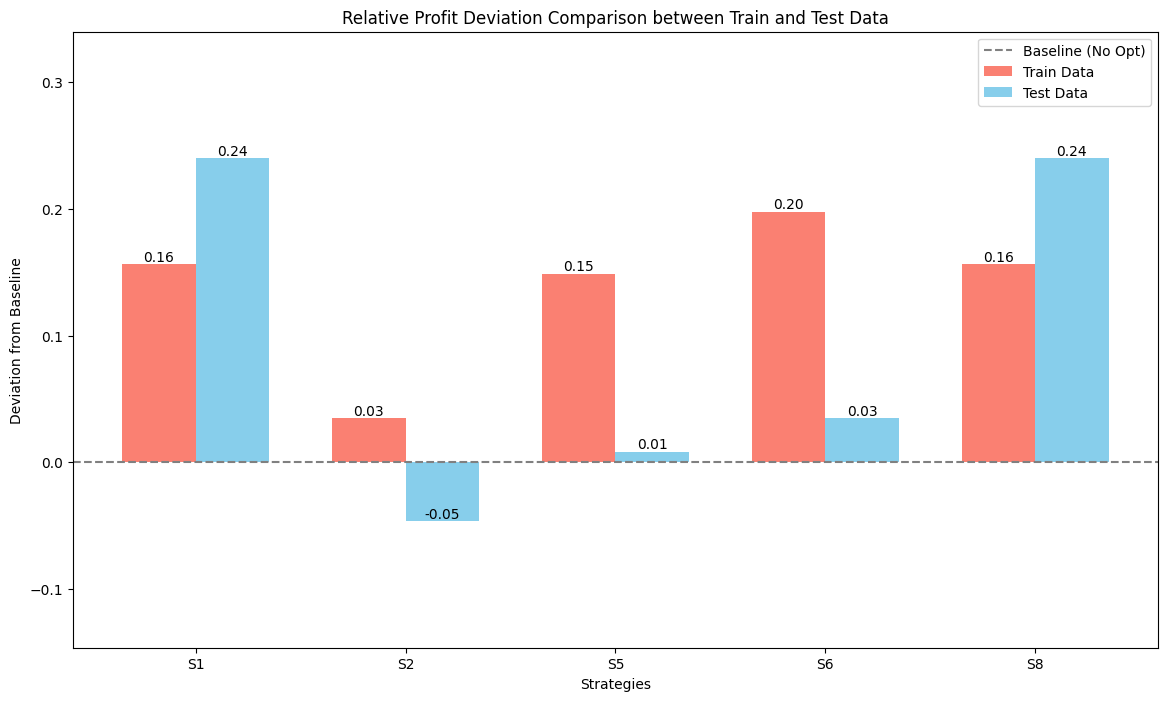

In [ ]:
# Plot the comparison
plot_relative_profit_comparison(
    save_type=f"{status}_{model_prefix}",
    train_baseline_profit=baseline_avg_profits,
    test_baseline_profit=test_baseline_avg_profits,
    test_max_profits=test_max_profits,
    train_max_profits=train_max_profits,
)

因為 baseline 的 hc 計算是低估的，所以通常其他的策略會比較低是正常的。

因此可以看 S8 的表現來進行相對性的評估會比較正確。

#### Root Analysis

將參數 show 出來比較與分析

### Preparation

In [ ]:
# 將變數名稱存取為此 Margin 特別的變數
# overview
low_test_results_df_1 = test_results_df_1
low_test_results_df_2 = test_results_df_2
low_test_results_df_3 = test_results_df_3
low_test_results_df_4 = test_results_df_4
low_test_results_df_5 = test_results_df_5
low_test_results_df_6 = test_results_df_6
low_test_results_df_7 = test_results_df_7
low_test_results_df_8 = test_results_df_8

# max stimulation result
low_test_stimulation_results_df_1 = test_stimulation_results_df_1
low_test_stimulation_results_df_2 = test_stimulation_results_df_2
low_test_stimulation_results_df_3 = test_stimulation_results_df_3
low_test_stimulation_results_df_4 = test_stimulation_results_df_4
low_test_stimulation_results_df_5 = test_stimulation_results_df_5
low_test_stimulation_results_df_6 = test_stimulation_results_df_6
low_test_stimulation_results_df_7 = test_stimulation_results_df_7
low_test_stimulation_results_df_8 = test_stimulation_results_df_8

# max value
low_test_baseline_profit = test_baseline_avg_profits
low_test_max_profit_for_s1 = test_max_profits[0]
low_test_max_profit_for_s2 = test_max_profits[1]
low_test_max_profit_for_s3 = test_max_profits[2]
low_test_max_profit_for_s4 = test_max_profits[3]
low_test_max_profit_for_s5 = test_max_profits[4]
low_test_max_profit_for_s6 = test_max_profits[5]
low_test_max_profit_for_s7 = test_max_profits[6]
low_test_max_profit_for_s8 = test_max_profits[7]

In [ ]:
# # 測試 HC 與 最佳 R, F 的變化

# def visualize_holding_cost_changes(holding_cost_list, best_Rs, best_Fs, best_profits):
#     plt.figure(figsize=(15, 10))

#     # Plot R changes
#     plt.subplot(3, 1, 1)
#     plt.plot(holding_cost_list, best_Rs, marker="o", label="Best R")
#     plt.title("HC vs. Best R(T)")
#     plt.xlabel("Holding Cost (HC)")
#     plt.ylabel("R(T)")
#     plt.grid(True)
#     plt.legend()

#     # Plot F changes
#     plt.subplot(3, 1, 2)
#     plt.plot(holding_cost_list, best_Fs, marker="o", color="orange", label="Best F")
#     plt.title("HC vs. Best F")
#     plt.xlabel("Holding Cost (HC)")
#     plt.ylabel("F")
#     plt.grid(True)
#     plt.legend()

#     # Plot profits
#     plt.subplot(3, 1, 3)
#     plt.plot(
#         holding_cost_list,
#         best_profits,
#         marker="o",
#         color="green",
#         label="Average Profits",
#     )
#     plt.title("HC vs. Average Profits")
#     plt.xlabel("Holding Cost (HC)")
#     plt.ylabel("Average Profits")
#     plt.grid(True)
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# holding_cost_list = [x for x in range(0, 1050, 50)]
# margins = [
#     {
#         "type": "low",
#         "price": 1000,
#         "cost": 800,
#         "salvage_value": 0,
#     },
#     {
#         "type": "med",
#         "price": 1000,
#         "cost": 500,
#         "salvage_value": 0,
#     },
#     {
#         "type": "high",
#         "price": 1000,
#         "cost": 200,
#         "salvage_value": 0,
#     },
# ]

# for margin in margins:

#     price = margin["price"]
#     cost = margin["cost"]
#     salvage_value = margin["salvage_value"]

#     service_lv = calculate_service_level(
#         salvage_value=salvage_value, cost=cost, price=price
#     )
#     Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)

#     best_Rs = []
#     best_Fs = []
#     best_profits = []

#     for holding_cost in holding_cost_list:

#         results_df_8, stimulation_results_df_8 = grid_fixed_F_fixed_R_with_holding_cost(
#             assigned_Ts=ASSIGNED_TS,
#             assigned_Fs=ASSIGNED_FS,
#             cost=cost,
#             price=price,
#             salvage_value=salvage_value,
#             Qk_hat_df=Qk_hat_df_train,
#             demand_df_train=demand_df_train,
#             Q_star=Q_star,
#             holding_cost=holding_cost,
#         )

#         best_Rs.append(results_df_8.iloc[0]["R(T)"])
#         best_Fs.append(results_df_8.iloc[0]["F"])
#         best_profits.append(results_df_8.iloc[0]["average_profits"])

#     print(f"Now at {margin['type']}...\n")
#     visualize_holding_cost_changes(holding_cost_list, best_Rs, best_Fs, best_profits)